In [3]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
sys.path.append('/home/elizabeth/lens_codes_v3.7')
sys.path.append('/home/elizabeth/Documentos/Astronomia/proyectos/HALO-SHAPE/MICE/codes_fit_MICE_profiles')
import argparse
from fit_profiles_curvefit import *
from models_profiles import *
from fit_models import *
from scipy import stats
from colossus.cosmology import cosmology  
from colossus.lss import peaks
from astropy.cosmology import LambdaCDM
from hide_cell import *
from colossus.halo import concentration
params = {'flat': True, 'H0': 70.0, 'Om0': 0.25, 'Ob0': 0.044, 'sigma8': 0.8, 'ns': 0.95}
cosmology.addCosmology('MICE', params)
cosmo = cosmology.setCosmology('MICE')
cosmo_as = LambdaCDM(H0=100, Om0=0.25, Ode0=0.75)

# plot_path = '/home/elizabeth/plot_paper_HSMice'
plot_path = '/home/eli/Documentos/Astronomia/proyectos/HALO-SHAPE/MICE/plot_paper_HSMice/'

mp = 2.927e10
nrings = 25
hide_toggle()

In [4]:
def c200_duffy(M,z,model = 'NFW',relax=False):
    #calculo de c usando la relacion de Duffy et al 2008
    if model == 'NFW' and not relax:
        return 5.71*((M/2.e12)**-0.084)*((1.+z)**-0.47)
    if model == 'NFW' and relax:
        return 6.71*((M/2.e12)**-0.091)*((1.+z)**-0.44)
    if model == 'Einasto' and not relax:
        return 6.4*((M/2.e12)**-0.108)*((1.+z)**-0.62)
    if model == 'Einasto' and relax:
        return 7.74*((M/2.e12)**-0.123)*((1.+z)**-0.60)


def q_75(y):
    return np.quantile(y, 0.75)

def q_25(y):
    return np.quantile(y, 0.25)


def binned(x,y,nbins=10):
    
    
    bined = stats.binned_statistic(x,y,statistic='mean', bins=nbins)
    x_b = 0.5*(bined.bin_edges[:-1] + bined.bin_edges[1:])
    ymean     = bined.statistic

    bined = stats.binned_statistic(x,y,statistic='median', bins=nbins)
    x_b = 0.5*(bined.bin_edges[:-1] + bined.bin_edges[1:])
    q50     = bined.statistic
    
    bined = stats.binned_statistic(x,y,statistic=q_25, bins=nbins)
    q25     = bined.statistic

    bined = stats.binned_statistic(x,y,statistic=q_75, bins=nbins)
    q75     = bined.statistic

    bined = stats.binned_statistic(x,y,statistic='count', bins=nbins)
    N     = bined.statistic

    bined = stats.binned_statistic(x,y,statistic='std', bins=nbins)
    sigma = bined.statistic
    
    dig   = np.digitize(x,bined.bin_edges)
    mz    = np.ones(len(x))
    for j in range(nbins):
        mbin = dig == (j+1)
        mz[mbin] = y[mbin] >= q50[j]   
    mz = mz.astype(bool)
    return x_b,q50,q25,q75,mz,ymean,sigma/np.sqrt(N)
            

def make_plot(X,Y,Z,zlim=0.3,nbins=20,plt=plt,error = False):
    plt.figure()
    x,q50,q25,q75,nada,ymean,ers = binned(X,Y,nbins)
    plt.scatter(X,Y, c=Z, alpha=0.3,s=1,vmax=zlim)
    if error:
        plt.plot(x,ymean,'C3')
        plt.plot(x,ymean+ers,'C3--')
        plt.plot(x,ymean-ers,'C3--')    
    else:
        plt.plot(x,q50,'C3')
        plt.plot(x,q25,'C3--')
        plt.plot(x,q75,'C3--')
    plt.colorbar()

def make_plot2(X,Y,color='C0',nbins=20,plt=plt,label='',error = False,lw=1,lt='-'):
    x,q50,q25,q75,nada,ymean,ers = binned(X,Y,nbins)
    if error:
        plt.plot(x,ymean,lt,color=color,label=label,lw=lw)
        plt.fill_between(x,ymean+ers,ymean-ers,color=color,alpha=0.2)
    else:
        plt.plot(x,q50,lt,color=color,label=label,lw=lw)
        plt.fill_between(x,q75,q25,color=color,alpha=0.2)


def fit_profile(pro,z,plot=True,halo=''):
     
         r,rho,rho_E,S,S_E   = pro
         
         a_t = 1./(1.+ z)
         
         rin = 10.
         rbins = ((np.arange(nrings+1)*((1000.-rin)/float(nrings)))+rin)/1000.
         mpV = mp/((4./3.)*np.pi*(rbins[1:]**3 - rbins[:-1]**3)) # mp/V
         mpA = mp/(np.pi*(rbins[1:]**2 - rbins[:-1]**2)) # mp/A
                  
         mrho = (rho > 0.)*(r > 0.05)
         mS = (S > 0.)*(r > 0.05)
         mrhoe = (rho_E > 0.)*(r > 0.05)
         mSe = (S_E > 0.)*(r > 0.05)         
         
         
         if mrho.sum() > 4. and mS.sum() > 4. and mrhoe.sum() > 4. and mSe.sum() > 4.:

            rho_f    = rho_fit(r[mrho],rho[mrho],mpV[mrho],z)
            rho_E_f    = rho_fit(r[mrhoe],rho_E[mrhoe],mpV[mrhoe],z)
            S_f      = Sigma_fit(r[mS],S[mS],mpA[mS],z)
            S_E_f      = Sigma_fit(r[mSe],S_E[mSe],mpA[mSe],z)
            rho_f_E    = rho_fit(r[mrho],rho[mrho],mpV[mrho],z,'Einasto',rho_f.M200,rho_f.c200)
            rho_E_f_E    = rho_fit(r[mrhoe],rho_E[mrhoe],mpV[mrhoe],z,'Einasto',rho_f.M200,rho_f.c200)
            S_f_E      = Sigma_fit(r[mS],S[mS],mpA[mS],z,'Einasto',rho_f.M200,rho_f.c200)
            S_E_f_E      = Sigma_fit(r[mSe],S_E[mSe],mpA[mSe],z,'Einasto',rho_f.M200,rho_f.c200)
            
            if plot:
                
                
                m = rho_f.xplot > r[r>0.].min()
                m1 = rho_E_f.xplot >  r[r>0.].min()
                m2 = S_f.xplot >  r[r>0.].min()
                m3 = S_E_f.xplot > r[r>0.].min()
                
            
                f,ax = plt.subplots()                              
                ax.fill_between(r[mrho],(rho+mpV*0.5)[mrho],(rho-mpV*0.5)[mrho],color='C0',alpha=0.5)
                ax.plot(r[mrho],rho[mrho],'C7',lw=4)
                ax.plot(rho_f.xplot[m],rho_f.yplot[m],'C2',label='NFW')
                ax.plot(rho_f_E.xplot[m],rho_f_E.yplot[m],'C3',label='Einasto')
                ax.fill_between(r[mrhoe],(rho_E+mpV*0.5)[mrhoe],(rho_E-mpV*0.5)[mrhoe],color='C1',alpha=0.5)
                ax.plot(r[mrhoe],rho_E[mrhoe],'C7--',lw=4)
                ax.plot(rho_E_f.xplot[m1],rho_E_f.yplot[m1],'C2--')
                ax.plot(rho_E_f_E.xplot[m1],rho_E_f_E.yplot[m1],'C3--')
                # ax.axvline(0.7*a_t*pro[1]*1.e-3)
                
                f2,ax2 = plt.subplots()                 
                ax2.fill_between(r[mS],(S+mpA*0.5)[mS],(S-mpA*0.5)[mS],color='C0',alpha=0.5)
                ax2.plot(r[mS],S[mS],'C7',lw=4)
                ax2.fill_between(r[mSe],(S_E+mpA*0.5)[mSe],(S_E-mpA*0.5)[mSe],color='C1',alpha=0.5)
                ax2.plot(r[mSe],S_E[mSe],'C7--',lw=4)
                ax2.plot(S_f.xplot[m2],S_f.yplot[m2],'C2',label='NFW')
                ax2.plot(S_f_E.xplot[m2],S_f_E.yplot[m2],'C3',label='Einasto')
                ax2.plot(S_E_f.xplot[m3],S_E_f.yplot[m3],'C2--')
                ax2.plot(S_E_f_E.xplot[m3],S_E_f_E.yplot[m3],'C3--')
                # ax2.axvline(0.7*a_t*pro[1]*1.e-3)
            
                ax.legend()
                ax2.legend()
                ax.set_xscale('log')
                ax.set_yscale('log')
                ax2.set_xscale('log')
                ax2.set_yscale('log')
                ax.set_ylim([1.e11,5.e15])
                ax2.set_ylim([1.e11,1.e15])
                ax.set_ylabel(r'$\rho [M_\odot h^2/Mpc^3]$')
                ax.set_xlabel('$r[Mpc/h]$')
                ax2.set_ylabel(r'$\Sigma [M_\odot h/Mpc^2]$')
                ax2.set_xlabel('$R[Mpc/h]$')            
            
                print(np.log10(rho_f.M200),rho_f.c200)
         
                f.savefig(plot_path+'profile_rho_'+part+'_'+halo+'.png')
                f2.savefig(plot_path+'profile_S_'+part+'_'+halo+'.png')
    
hide_toggle()

## LOAD CATALOG AND PARAMETERS

In [5]:
params = np.loadtxt('/home/eli/Documentos/Astronomia/proyectos/HALO-SHAPE/MICE/HALO_Props_MICE.cat').T
lgMvir, Rvir, Cvir = np.loadtxt('/home/eli/Documentos/Astronomia/proyectos/HALO-SHAPE/MICE/HALO_Props_vir.cat')

halo_id = params[0]
Npart   = params[1]
lgM     = params[2]
xc      = params[3]
yc      = params[4]
zc      = params[5]
xc_rc   = params[6]
yc_rc   = params[7]
zc_rc   = params[8]
z       = params[9]
r_max   = params[10]
vxc     = params[11]
vyc     = params[12]
vzc     = params[13]
Jx      = params[14]
Jy      = params[15]
Jz      = params[16]
K       = params[17]
U       = params[18]
a2D     = params[19]
b2D     = params[20]
a2Dx    = params[21]
a2Dy    = params[22]
b2Dx    = params[23]
b2Dy    = params[24]
a2Dr    = params[25]
b2Dr    = params[26]
a2Drx   = params[27]
a2Dry   = params[28]
b2Drx   = params[29]
b2Dry   = params[30]
a3D     = params[31]
b3D     = params[32]
c3D     = params[33]
a3Dx    = params[34]
a3Dy    = params[35]
a3Dz    = params[36]
b3Dx    = params[37]
b3Dy    = params[38]
b3Dz    = params[39]
c3Dx    = params[40]
c3Dy    = params[41]
c3Dz    = params[42]
a3Dr    = params[43]
b3Dr    = params[44]
c3Dr    = params[45]
a3Drx   = params[46]
a3Dry   = params[47]
a3Drz   = params[48]
b3Drx   = params[49]
b3Dry   = params[50]
b3Drz   = params[51]
c3Drx   = params[52]
c3Dry   = params[53]
c3Drz   = params[54]
R       = params[55:80]/1.e3
rho     = params[80:105]
rhoE    = params[105:130]
S       = params[130:155]
SE      = params[155:180]
lgMDelta     = params[180]
Delta        = params[181]
lgMNFW_rho   = params[182]
cNFW_rho     = params[183]
resNFW_rho   = params[184]
nb_rho       = params[185]
lgMNFW_rho_E = params[186]
cNFW_rho_E   = params[187]
resNFW_rho_E = params[188]
nb_rho_E     = params[189]
lgMNFW_S     = params[190]
cNFW_S       = params[191]
resNFW_S     = params[192]
nb_S         = params[193]
lgMNFW_S_E   = params[194]
cNFW_S_E     = params[195]
resNFW_S_E   = params[196]
nb_S_E       = params[197]
lgMEin_rho   = params[198]
cEin_rho     = params[199]
alpha_rho    = params[200]
resEin_rho   = params[201]
lgMEin_rho_E = params[202]
cEin_rho_E   = params[203]
alpha_rho_E  = params[204]
resEin_rho_E = params[205]
lgMEin_S     = params[206]
cEin_S       = params[207]
alpha_S      = params[208]
resEin_S     = params[209]
lgMEin_S_E   = params[210]
cEin_S_E     = params[211]
alpha_S_E    = params[212]
resEin_S_E   = params[213]

a_t = 1./(1.+ z)
roc_mpc = cosmo_as.critical_density(z).to(u.Msun/(u.Mpc)**3).value

Eratio = (2.*K/abs(U))

nu = peaks.peakHeight(10**lgMvir, z)

rc = np.array(np.sqrt((xc - xc_rc)**2 + (yc - yc_rc)**2 + (zc - zc_rc)**2))
offset = rc/r_max
index = np.arange(len(params.T))


### Shape parameters and volume

[0.54243051 0.54928047 0.52536462 ... 0.31087818 0.39963492 0.29253928]


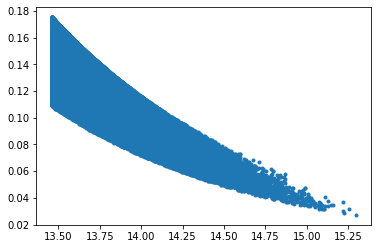

In [6]:
s    = c3D/a3D
q    = b3D/a3D
q2d  = b2D/a2D
sr   = c3Dr/a3Dr
qr   = b3Dr/a3Dr
q2dr = b2Dr/a2Dr

T = (1. - q**2)/(1. - s**2)
Tr = (1. - qr**2)/(1. - sr**2)

V = (4./3.)*np.pi*(((a_t*r_max*1.e-3)**3))
dens3d = ((mp*Npart)/V)/roc_mpc

Ve = (4./3.)*np.pi*(((a_t*r_max*1.e-3)**3)*q*s)
dens3de = ((mp*Npart)/Ve)/roc_mpc

r200 = R200_NFW(0.8*(10**lgM),z,cosmo_as)
print(r200)

plt.plot(lgM,(0.05/r200),'.')

### DEFINE MASKS 

In [7]:
#mraro = ((index > 229238)*(index < 241750))+((index > 423721)*(index < 430222))+((index > 464672)*(index < 468526))
mfit_NFW = (cNFW_rho > 1.)*(cNFW_S > 1.)*(cNFW_S_E > 1.)*(cNFW_rho_E > 1.)*(lgMNFW_rho > 12)*(lgMNFW_S > 12)*(lgMNFW_S_E > 12)*(lgMNFW_rho_E > 12)*(cNFW_rho < 15)*(cNFW_S < 15)*(cNFW_S_E < 15)*(cNFW_rho_E < 15)
mfit_Ein = (cEin_rho > 1.)*(cEin_S > 1.)*(cEin_S_E > 1.)*(cEin_rho_E > 1.)*(lgMEin_rho > 12)*(lgMEin_S > 12)*(lgMEin_S_E > 12)*(lgMEin_rho_E > 12)*(cEin_rho < 15)*(cEin_S < 15)*(cEin_S_E < 15)*(cEin_rho_E < 15)*(alpha_rho > 0.)*(alpha_rho_E > 0.)

mfit = mfit_NFW*mfit_Ein#*(~mraro)

mrelax = (offset < 0.1)*(Eratio < 1.35)

mres1 = mfit*(dens3d > 20)*(dens3d < 40)
mres2 = mfit*(dens3de > 100)*(dens3de < 150)

#mres2 = ((a_t*r_max*1.e-3) > 1.)*((a_t*r_max*1.e-3 )< 1.5)*mfit

## Density comparison

ALL HALOS 

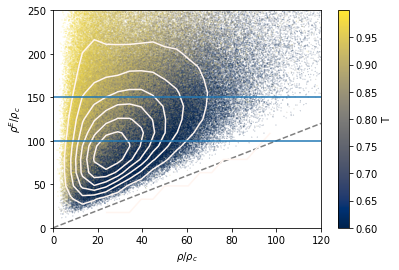

In [6]:
m = mfit*(dens3de < 250)*(dens3d < 150)*(dens3de > 10)

plt.figure(figsize=(6,4))
plt.scatter(dens3d[mfit],dens3de[mfit],c=T[mfit],s=0.01,vmin=0.6,cmap='cividis')
plt.plot([0,250],[0,250],'C7--')
plt.colorbar(label='T')

xedges = np.linspace(-2.,2.,50)
yedges = np.linspace(-2.,2.,50)
xcenters = (xedges[:-1] + xedges[1:]) / 2.
ycenters = (yedges[:-1] + yedges[1:]) / 2.
xedges = np.linspace(0,100.,20)
yedges = np.linspace(10.,300,20)
xcenters = (xedges[:-1] + xedges[1:]) / 2.
ycenters = (yedges[:-1] + yedges[1:]) / 2.
xcenters = (xedges[:-1] + xedges[1:]) / 2.
ycenters = (yedges[:-1] + yedges[1:]) / 2.
X,Y = np.meshgrid(xcenters,ycenters)
H, xedges, yedges = np.histogram2d(dens3d[m],dens3de[m], bins=(xedges, yedges))
H2, xedges, yedges = np.histogram2d(dens3d[m*mrelax],dens3de[m*mrelax], bins=(xedges, yedges))
plt.contour(X, Y, H.T,cmap='Reds',vmin=5000)
#plt.contour(X, Y, H2.T,cmap='Spectral',vmin=1000)
plt.axis([0,120,0,250])
plt.axhline(150)
plt.axhline(100)
plt.xlabel(r'$\rho / \rho_c$')
plt.ylabel(r'$\rho^E / \rho_c$')

#plt.savefig(plot_path+'dens.pdf',bbox_inches='tight')
plt.savefig(plot_path+'dens.png',bbox_inches='tight')
hide_toggle()


RELAXED HALOS

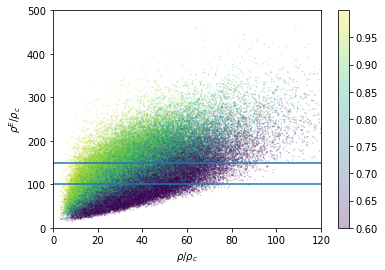

In [12]:
plt.figure(figsize=(6,4))
plt.scatter(dens3d[mfit*mrelax],dens3de[mfit*mrelax],c=T[mfit*mrelax],s=0.2,alpha=0.3,vmin=0.6)
plt.axis([0,150,0,600])
plt.axis([0,120,0,500])
plt.axhline(150)
plt.axhline(100)
plt.xlabel(r'$\rho / \rho_c$')
plt.ylabel(r'$\rho^E / \rho_c$')
plt.colorbar()
plt.savefig(plot_path+'dens_relax.pdf',bbox_inches='tight')


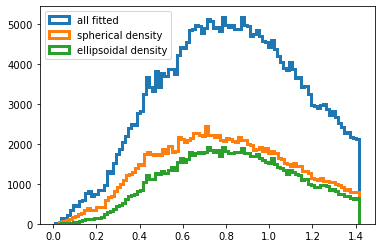

In [32]:
plt.hist(z[mfit],100,histtype='step',lw=3,label='all fitted')
plt.hist(z[mres1],100,histtype='step',lw=3,label='spherical density')
plt.hist(z[mres2],100,histtype='step',lw=3,label='ellipsoidal density')
plt.legend(loc = 2)

## Evaluate residuals

### Selected with the same elliptical density

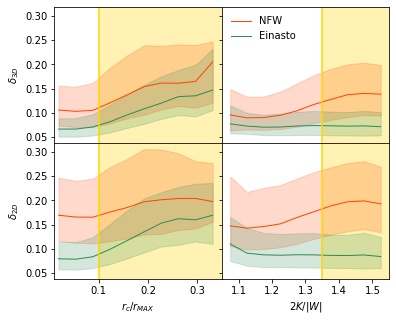

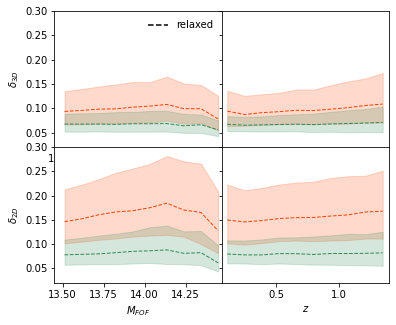

In [16]:
#-------------------
# WITH OFFSET
mres = mres2
f, ax = plt.subplots(2,2, figsize=(6,5),sharey=True)
f.subplots_adjust(hspace=0,wspace=0)
ax1 = ax[0]
ax2 = ax[1]

m = mres*(offset < 0.35)
ax1[0].axvspan(0.1,0.35,ymin=0.0,ymax=1.,color='gold',alpha=0.3)
ax2[0].axvspan(0.1,0.35,ymin=0.0,ymax=1.,color='gold',alpha=0.3)
make_plot2(offset[m],resNFW_rho[m],'orangered',10,plt=ax1[0],label='NFW')
make_plot2(offset[m],resEin_rho[m],'seagreen',10,plt=ax1[0],label='Einasto')
make_plot2(offset[m],resNFW_S[m],'orangered',10,plt=ax2[0],label='NFW')
make_plot2(offset[m],resEin_S[m],'seagreen',10,plt=ax2[0],label='Einasto')
ax1[0].axvline(0.1,color='gold')
ax2[0].axvline(0.1,color='gold')
ax1[0].set_xlim([0.01,0.35])
ax2[0].set_xlim([0.01,0.35])
ax1[0].set_xlabel(r'$r_c/r_{MAX}$')
ax2[0].set_xlabel(r'$r_c/r_{MAX}$')
ax1[0].set_ylabel('$\delta_{3D}$')
ax2[0].set_ylabel('$\delta_{2D}$')
# ------------------------
# WITH ERATIO
m = mres*(Eratio > 1.05)*(Eratio < 1.55)
ax1[1].axvspan(1.35,1.55,ymin=0.0,ymax=1.,color='gold',alpha=0.3)
ax2[1].axvspan(1.35,1.55,ymin=0.0,ymax=1.,color='gold',alpha=0.3)
# m = mfit*(Eratio < 1.5)*(Npart>10000)*(Npart<11000)*(cNFW_rho >2)*(cNFW_rho < 6)
make_plot2(Eratio[m],resNFW_rho[m],'orangered',10,plt=ax1[1],label='NFW')
make_plot2(Eratio[m],resEin_rho[m],'seagreen',10,plt=ax1[1],label='Einasto')
ax1[1].legend(loc=2,frameon=False)
make_plot2(Eratio[m],resNFW_S[m],'orangered',10,plt=ax2[1],label='NFW')
make_plot2(Eratio[m],resEin_S[m],'seagreen',10,plt=ax2[1],label='Einasto')
ax1[1].axvline(1.35,color='gold')
ax2[1].axvline(1.35,color='gold')
ax1[1].set_xlim([1.05,1.55])
ax2[1].set_xlim([1.05,1.55])
ax1[1].set_xlabel(r'$2K/|W|$')
ax2[1].set_xlabel(r'$2K/|W|$')
f.savefig(plot_path+'res_E.pdf',bbox_inches='tight')
# ------------------------
f, ax = plt.subplots(2,2, figsize=(6,5),sharey=True)
f.subplots_adjust(hspace=0,wspace=0)
ax1 = ax[0]
ax2 = ax[1]
ax1[0].set_ylabel('$\delta_{3D}$')
ax2[0].set_ylabel('$\delta_{2D}$')


# WITH M200
# 3D
m = mres*mrelax*(lgM < 14.5)
ax1[0].plot([-1,-1],[-2,-1],'k--',label='relaxed')
ax1[0].legend(frameon=False)
make_plot2(lgM[m],resNFW_rho[m],'orangered',10,plt=ax1[0],label='NFW',lt='--')
make_plot2(lgM[m],resNFW_S[m],'orangered',10,plt=ax2[0],label='NFW',lt='--')
make_plot2(lgM[m],resEin_rho[m],'seagreen',10,plt=ax1[0],label='Einasto',lt='--')
make_plot2(lgM[m],resEin_S[m],'seagreen',10,plt=ax2[0],label='Einasto',lt='--')
ax1[0].set_xlim([13.45,14.47])
ax2[0].set_xlim([13.45,14.47])
ax2[0].set_xlabel(r'$M_{FOF}$')
# ------------------------
# WITH z
# 3D
m = mres*mrelax
make_plot2(z[m],resNFW_rho[m],'orangered',10,plt=ax1[1],label='NFW',lt='--')
make_plot2(z[m],resEin_rho[m],'seagreen',10,plt=ax1[1],label='Einasto',lt='--')
make_plot2(z[m],resNFW_S[m],'orangered',10,plt=ax2[1],label='NFW',lt='--')
make_plot2(z[m],resEin_S[m],'seagreen',10,plt=ax2[1],label='Einasto',lt='--')
ax1[1].set_xlim([0.07,1.4])
ax2[1].set_xlim([0.07,1.4])
ax1[1].set_xlabel(r'$z$')
ax2[1].set_xlabel(r'$z$')
ax2[1].set_ylim([0.02,0.3])
f.savefig(plot_path+'res_relax_E.pdf',bbox_inches='tight')
hide_toggle()


### Selected with the same spherical density

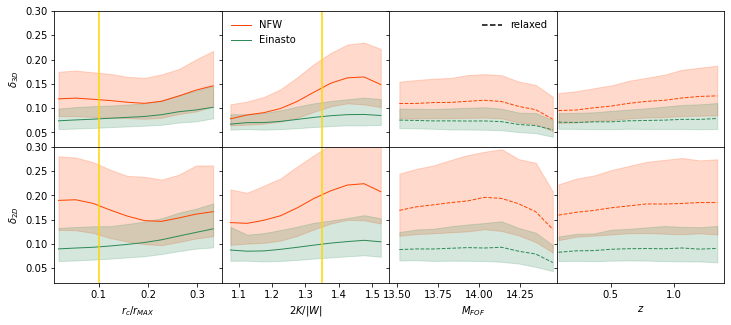

In [30]:
#-------------------
# WITH OFFSET
mres = mres1
f, ax = plt.subplots(2,4, figsize=(12,5),sharey=True)
f.subplots_adjust(hspace=0,wspace=0)
ax1 = ax[0]
ax2 = ax[1]

m = mres*(offset < 0.35)
make_plot2(offset[m],resNFW_rho[m],'orangered',10,plt=ax1[0],label='NFW')
make_plot2(offset[m],resEin_rho[m],'seagreen',10,plt=ax1[0],label='Einasto')
make_plot2(offset[m],resNFW_S[m],'orangered',10,plt=ax2[0],label='NFW')
make_plot2(offset[m],resEin_S[m],'seagreen',10,plt=ax2[0],label='Einasto')
ax1[0].axvline(0.1,color='gold')
ax2[0].axvline(0.1,color='gold')
ax1[0].set_xlim([0.01,0.35])
ax2[0].set_xlim([0.01,0.35])
ax1[0].set_xlabel(r'$r_c/r_{MAX}$')
ax2[0].set_xlabel(r'$r_c/r_{MAX}$')
ax1[0].set_ylabel('$\delta_{3D}$')
ax2[0].set_ylabel('$\delta_{2D}$')
# ------------------------
# WITH ERATIO
m = mres*(Eratio > 1.05)*(Eratio < 1.55)
# m = mfit*(Eratio < 1.5)*(Npart>10000)*(Npart<11000)*(cNFW_rho >2)*(cNFW_rho < 6)
make_plot2(Eratio[m],resNFW_rho[m],'orangered',10,plt=ax1[1],label='NFW')
make_plot2(Eratio[m],resEin_rho[m],'seagreen',10,plt=ax1[1],label='Einasto')
ax1[1].legend(loc=2,frameon=False)
make_plot2(Eratio[m],resNFW_S[m],'orangered',10,plt=ax2[1],label='NFW')
make_plot2(Eratio[m],resEin_S[m],'seagreen',10,plt=ax2[1],label='Einasto')
ax1[1].axvline(1.35,color='gold')
ax2[1].axvline(1.35,color='gold')
ax1[1].set_xlim([1.05,1.55])
ax2[1].set_xlim([1.05,1.55])
ax1[1].set_xlabel(r'$2K/|W|$')
ax2[1].set_xlabel(r'$2K/|W|$')
# ------------------------
# WITH M200
# 3D
m = mres*mrelax*(lgM < 14.5)
ax1[2].plot([-1,-1],[-2,-1],'k--',label='relaxed')
ax1[2].legend(frameon=False)
make_plot2(lgM[m],resNFW_rho[m],'orangered',10,plt=ax1[2],label='NFW',lt='--')
make_plot2(lgM[m],resNFW_S[m],'orangered',10,plt=ax2[2],label='NFW',lt='--')
make_plot2(lgM[m],resEin_rho[m],'seagreen',10,plt=ax1[2],label='Einasto',lt='--')
make_plot2(lgM[m],resEin_S[m],'seagreen',10,plt=ax2[2],label='Einasto',lt='--')
ax1[2].set_xlim([13.45,14.47])
ax2[2].set_xlim([13.45,14.47])
ax2[2].set_xlabel(r'$M_{FOF}$')
# ------------------------
# WITH z
# 3D
m = mres*mrelax
make_plot2(z[m],resNFW_rho[m],'orangered',10,plt=ax1[3],label='NFW',lt='--')
make_plot2(z[m],resEin_rho[m],'seagreen',10,plt=ax1[3],label='Einasto',lt='--')
make_plot2(z[m],resNFW_S[m],'orangered',10,plt=ax2[3],label='NFW',lt='--')
make_plot2(z[m],resEin_S[m],'seagreen',10,plt=ax2[3],label='Einasto',lt='--')
ax1[3].set_xlim([0.07,1.4])
ax2[3].set_xlim([0.07,1.4])
ax1[3].set_xlabel(r'$z$')
ax2[3].set_xlabel(r'$z$')
ax2[3].set_ylim([0.02,0.3])
#f.savefig(plot_path+'res_relax_E.pdf',bbox_inches='tight')
hide_toggle()


### Residuals with shape

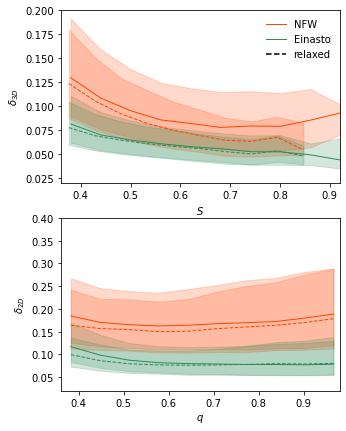

In [32]:
f, ax = plt.subplots(2,1, figsize=(5,7))
mres = mres2
m = mres*(s > 0.35)
make_plot2(s[m],resNFW_rho[m],'orangered',10,plt=ax[0],label='NFW')
make_plot2(s[m],resEin_rho[m],'seagreen',10,plt=ax[0],label='Einasto')
ax[0].plot([-1,-1],[-2,-1],'k--',label='relaxed')
ax[0].legend(frameon=False)
m = mres*mrelax*(s > 0.35)
make_plot2(s[m],resNFW_rho[m],'orangered',10,plt=ax[0],label='NFW',lt='--')
make_plot2(s[m],resEin_rho[m],'seagreen',10,plt=ax[0],label='Einasto',lt='--')
m = mres*(q2d > 0.35)
make_plot2(q2d[m],resNFW_S[m],'orangered',10,plt=ax[1],label='NFW')
make_plot2(q2d[m],resEin_S[m],'seagreen',10,plt=ax[1],label='Einasto')
m = mres*mrelax*(q2d > 0.35)
make_plot2(q2d[m],resNFW_S[m],'orangered',10,plt=ax[1],label='NFW',lt='--')
make_plot2(q2d[m],resEin_S[m],'seagreen',10,plt=ax[1],label='Einasto',lt='--')
ax[0].set_ylim([0.02,0.20])
ax[1].set_ylim([0.02,0.40])
ax[0].set_xlim([0.36,0.92])
ax[1].set_xlim([0.36,0.98])
ax[1].set_xlabel('$q$')
ax[0].set_xlabel('$S$')
ax[1].set_ylabel('$\delta_{2D}$')
ax[0].set_ylabel('$\delta_{3D}$')
f.savefig(plot_path+'res_relax_shape_E.pdf',bbox_inches='tight')
hide_toggle()


### Selected with the same spherical volume

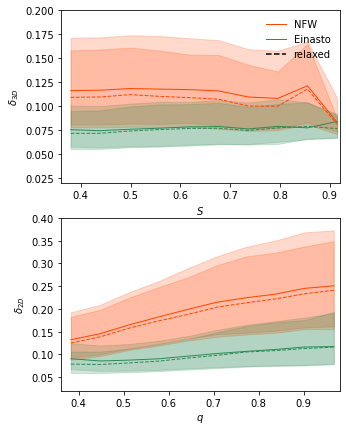

In [33]:
f, ax = plt.subplots(2,1, figsize=(5,7))
mres = mres1
m = mres*(s > 0.35)
make_plot2(s[m],resNFW_rho[m],'orangered',10,plt=ax[0],label='NFW')
make_plot2(s[m],resEin_rho[m],'seagreen',10,plt=ax[0],label='Einasto')
ax[0].plot([-1,-1],[-2,-1],'k--',label='relaxed')
ax[0].legend(frameon=False)
m = mres*mrelax*(s > 0.35)
make_plot2(s[m],resNFW_rho[m],'orangered',10,plt=ax[0],label='NFW',lt='--')
make_plot2(s[m],resEin_rho[m],'seagreen',10,plt=ax[0],label='Einasto',lt='--')
m = mres*(q2d > 0.35)
make_plot2(q2d[m],resNFW_S[m],'orangered',10,plt=ax[1],label='NFW')
make_plot2(q2d[m],resEin_S[m],'seagreen',10,plt=ax[1],label='Einasto')
m = mres*mrelax*(q2d > 0.35)
make_plot2(q2d[m],resNFW_S[m],'orangered',10,plt=ax[1],label='NFW',lt='--')
make_plot2(q2d[m],resEin_S[m],'seagreen',10,plt=ax[1],label='Einasto',lt='--')
ax[0].set_ylim([0.02,0.20])
ax[1].set_ylim([0.02,0.40])
ax[0].set_xlim([0.36,0.92])
ax[1].set_xlim([0.36,0.98])
ax[1].set_xlabel('$q$')
ax[0].set_xlabel('$S$')
ax[1].set_ylabel('$\delta_{2D}$')
ax[0].set_ylabel('$\delta_{3D}$')
#f.savefig(plot_path+'res_relax_shape_E.pdf',bbox_inches='tight')
hide_toggle()


## Comparison M_FOF vs M200

### Comparison with mass and z
### Same spherical volume

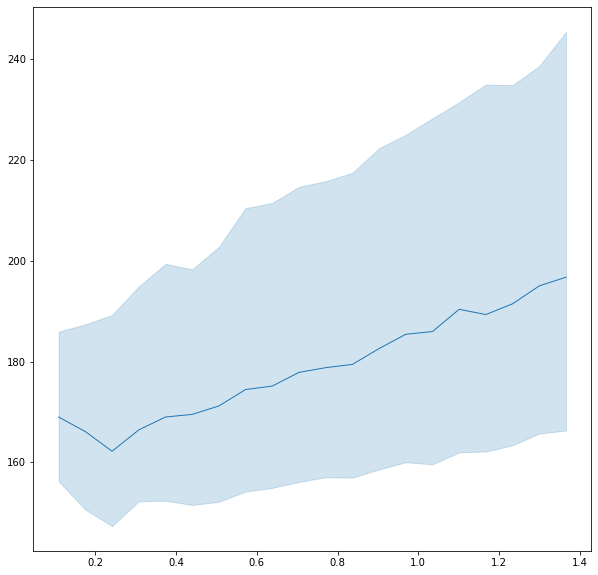

In [44]:
m = mfit*(dens3de > 120)*(dens3de > 140)*(z > 0.07)*(z < 1.4)*(lgM > 13.5)*(lgM < 13.7)
plt.figure(figsize=(10,10))
#plt.plot(z[m],dens3de[m],'.')
#plt.plot(z[m],dens3d[m],'.')
make_plot2(z[m],dens3de[m])

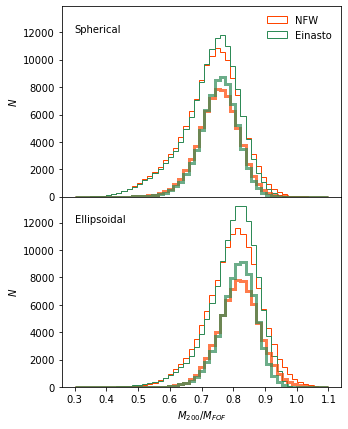

In [20]:
f, ax = plt.subplots(2,1, figsize=(5,7),sharey=True,sharex=True)
f.subplots_adjust(hspace=0,wspace=0)
msel = mres1
m = msel
ax[0].hist(10**(lgMNFW_rho - lgM)[m],np.linspace(0.3,1.1,50),color='orangered',histtype='step',lw=1,label='NFW')
ax[0].hist(10**(lgMEin_rho - lgM)[m],np.linspace(0.3,1.1,50),color='seagreen',histtype='step',lw=1,label='Einasto')
ax[0].legend(frameon=False)
ax[1].hist(10**(lgMNFW_rho_E - lgM)[m],np.linspace(0.3,1.1,50),color='orangered',histtype='step',lw=1,label='NFW')
ax[1].hist(10**(lgMEin_rho_E - lgM)[m],np.linspace(0.3,1.1,50),color='seagreen',histtype='step',lw=1,label='Einasto')

m = msel*mrelax
ax[0].hist(10**(lgMNFW_rho - lgM)[m],np.linspace(0.3,1.1,50),color='orangered',histtype='step',lw=3,alpha=0.7)
ax[0].hist(10**(lgMEin_rho - lgM)[m],np.linspace(0.3,1.1,50),color='seagreen',histtype='step',lw=3,alpha=0.7)
ax[1].hist(10**(lgMNFW_rho_E - lgM)[m],np.linspace(0.3,1.1,50),color='orangered',histtype='step',lw=3,alpha=0.7)
ax[1].hist(10**(lgMEin_rho_E - lgM)[m],np.linspace(0.3,1.1,50),color='seagreen',histtype='step',lw=3,alpha=0.7)
ax[1].set_xlabel('$M_{200}/M_{FOF}$')
ax[1].set_ylabel('$N$')
ax[0].set_ylabel('$N$')

ax[0].text(0.3,12000,'Spherical')
ax[1].text(0.3,12000,'Ellipsoidal')
plt.savefig(plot_path+'MFOF_M200_hist.pdf',bbox_inches='tight')

hide_toggle()

In [19]:
print('$p_{25}$ &',np.round(q_25(10**(lgMNFW_rho - lgM)[msel]),2),' & ',np.round(q_25(10**(lgMNFW_rho - lgM)[msel*mrelax]),2),' & ',np.round(q_25(10**(lgMEin_rho - lgM)[msel]),2),' & ',np.round(q_25(10**(lgMEin_rho - lgM)[msel*mrelax]),2),'&',np.round(q_25(10**(lgMNFW_rho_E - lgM)[msel]),2),' & ',np.round(q_25(10**(lgMNFW_rho_E - lgM)[msel*mrelax]),2),' & ',np.round(q_25(10**(lgMEin_rho_E - lgM)[msel]),2),' & ',np.round(q_25(10**(lgMEin_rho_E - lgM)[msel*mrelax]),2),r' \\ ')
print('$p_{50}$ &',np.round(np.median(10**(lgMNFW_rho - lgM)[msel]),2),' & ',np.round(np.median(10**(lgMNFW_rho - lgM)[msel*mrelax]),2),' & ',np.round(np.median(10**(lgMEin_rho - lgM)[msel]),2),' & ',np.round(np.median(10**(lgMEin_rho - lgM)[msel*mrelax]),2),'&',np.round(np.median(10**(lgMNFW_rho_E - lgM)[msel]),2),' & ',np.round(np.median(10**(lgMNFW_rho_E - lgM)[msel*mrelax]),2),' & ',np.round(np.median(10**(lgMEin_rho_E - lgM)[msel]),2),' & ',np.round(np.median(10**(lgMEin_rho_E - lgM)[msel*mrelax]),2),r' \\ ')
print('$p_{75}$ &',np.round(q_75(10**(lgMNFW_rho - lgM)[msel]),2),' & ',np.round(q_75(10**(lgMNFW_rho - lgM)[msel*mrelax]),2),' & ',np.round(q_75(10**(lgMEin_rho - lgM)[msel]),2),' & ',np.round(q_75(10**(lgMEin_rho - lgM)[msel*mrelax]),2),'&',np.round(q_75(10**(lgMNFW_rho_E - lgM)[msel]),2),' & ',np.round(q_75(10**(lgMNFW_rho_E - lgM)[msel*mrelax]),2),' & ',np.round(q_75(10**(lgMEin_rho_E - lgM)[msel]),2),' & ',np.round(q_75(10**(lgMEin_rho_E - lgM)[msel*mrelax]),2),r' \\ ')


$p_{25}$ & 0.67  &  0.71  &  0.68  &  0.72 & 0.75  &  0.78  &  0.76  &  0.78  \\ 
$p_{50}$ & 0.74  &  0.75  &  0.74  &  0.76 & 0.81  &  0.82  &  0.81  &  0.82  \\ 
$p_{75}$ & 0.79  &  0.8  &  0.79  &  0.79 & 0.86  &  0.86  &  0.85  &  0.85  \\ 


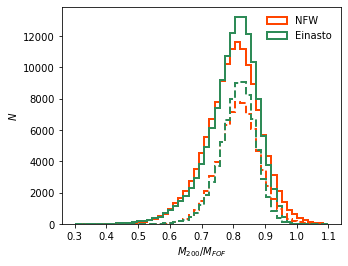

In [25]:
plt.figure(figsize=(5,4))
msel = mfit*mres1
m = msel
plt.hist(10**(lgMNFW_rho_E - lgM)[m],np.linspace(0.3,1.1,50),color='orangered',histtype='step',lw=2,label='NFW')
plt.hist(10**(lgMEin_rho_E - lgM)[m],np.linspace(0.3,1.1,50),color='seagreen',histtype='step',lw=2,label='Einasto')
plt.legend(frameon=False)
m = msel*mrelax
plt.hist(10**(lgMNFW_rho_E - lgM)[m],np.linspace(0.3,1.1,50),color='orangered',histtype='step',lw=2,ls='--')
plt.hist(10**(lgMEin_rho_E - lgM)[m],np.linspace(0.3,1.1,50),color='seagreen',histtype='step',lw=2,ls='--')
plt.xlabel('$M_{200}/M_{FOF}$')
plt.ylabel('$N$')
plt.savefig(plot_path+'MFOF_M200_hist.pdf',bbox_inches='tight')
hide_toggle()

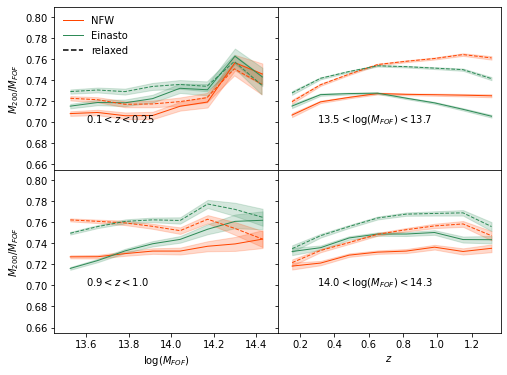

In [8]:
f, ax = plt.subplots(2,2, figsize=(8,6),sharey=True)
f.subplots_adjust(hspace=0,wspace=0)

mres = mres1
m = mres*(z > 0.1)*(z < 0.25)*(lgM < 14.5)
make_plot2(lgM[m],10**(lgMNFW_rho - lgM)[m],'orangered',8,label='NFW',error=True,lw=1,plt=ax[0,0])
make_plot2(lgM[m],10**(lgMEin_rho - lgM)[m],'seagreen',8,label='Einasto',error=True,lw=1,plt=ax[0,0])
ax[0,0].plot([-1,-1],[-1,-1],'k--',label='relaxed')
ax[0,0].legend(loc=2,frameon=False)

m = mres*(z > 0.1)*(z < 0.25)*mrelax*(lgM < 14.5)
make_plot2(lgM[m],10**(lgMNFW_rho - lgM)[m],'orangered',8,label='NFW',error=True,lw=1,plt=ax[0,0],lt='--')
make_plot2(lgM[m],10**(lgMEin_rho - lgM)[m],'seagreen',8,label='Einasto',error=True,lw=1,plt=ax[0,0],lt='--')

ax[0,0].set_ylabel(r'$M_{200}/M_{FOF}$')
ax[1,0].set_ylabel(r'$M_{200}/M_{FOF}$')
ax[0,0].set_xlim([13.45,14.5])
ax[1,0].set_xlim([13.45,14.5])

m = mres*(z > 0.9)*(z < 1)*(lgM < 14.5)
make_plot2(lgM[m],10**(lgMNFW_rho - lgM)[m],'orangered',8,label='NFW',error=True,lw=1,plt=ax[1,0])
make_plot2(lgM[m],10**(lgMEin_rho - lgM)[m],'seagreen',8,label='Einasto',error=True,lw=1,plt=ax[1,0])
m = mres*(z > 0.9)*(z < 1)*(lgM < 14.5)*mrelax
make_plot2(lgM[m],10**(lgMNFW_rho - lgM)[m],'orangered',8,label='NFW',error=True,lw=1,plt=ax[1,0],lt='--')
make_plot2(lgM[m],10**(lgMEin_rho - lgM)[m],'seagreen',8,label='Einasto',error=True,lw=1,plt=ax[1,0],lt='--')

ax[1,0].set_xlabel(r'$\log (M_{FOF})$')
ax[0,0].text(13.6,0.7,'$0.1 < z < 0.25$')
ax[1,0].text(13.6,0.7,'$0.9 < z < 1.0$')

m = mres*(z > 0.07)*(z < 1.4)*(lgM > 13.5)*(lgM < 13.7)
make_plot2(z[m],10**(lgMNFW_rho - lgM)[m],'orangered',8,label='NFW',error=True,lw=1,plt=ax[0,1])
make_plot2(z[m],10**(lgMEin_rho - lgM)[m],'seagreen',8,label='Einasto',error=True,lw=1,plt=ax[0,1])
m = mres*(z > 0.07)*(z < 1.4)*(lgM > 13.5)*(lgM < 13.7)*mrelax
make_plot2(z[m],10**(lgMNFW_rho - lgM)[m],'orangered',8,label='NFW',error=True,lw=1,plt=ax[0,1],lt='--')
make_plot2(z[m],10**(lgMEin_rho - lgM)[m],'seagreen',8,label='Einasto',error=True,lw=1,plt=ax[0,1],lt='--')

ax[0,1].set_xlim([0.07,1.37])
ax[1,1].set_xlim([0.07,1.37])

m = mres*(z > 0.07)*(z < 1.4)*(lgM > 14.0)*(lgM < 14.3)
make_plot2(z[m],10**(lgMNFW_rho - lgM)[m],'orangered',8,label='NFW',error=True,lw=1,plt=ax[1,1])
make_plot2(z[m],10**(lgMEin_rho - lgM)[m],'seagreen',8,label='Einasto',error=True,lw=1,plt=ax[1,1])
m = mres*(z > 0.07)*(z < 1.4)*(lgM > 14.0)*(lgM < 14.3)*mrelax
make_plot2(z[m],10**(lgMNFW_rho - lgM)[m],'orangered',8,label='NFW',error=True,lw=1,plt=ax[1,1],lt='--')
make_plot2(z[m],10**(lgMEin_rho - lgM)[m],'seagreen',8,label='Einasto',error=True,lw=1,plt=ax[1,1],lt='--')

# ax[1,1].set_ylim([0.65,0.82])
ax[1,1].set_xlabel(r'$z$')
ax[0,1].text(0.3,0.7,'$13.5 < \log(M_{FOF}) < 13.7$')
ax[1,1].text(0.3,0.7,'$14.0 < \log(M_{FOF}) < 14.3$')
ax[1,1].set_ylim([0.655,0.81])
f.savefig(plot_path+'MFOF_M200.pdf',bbox_inches='tight')
hide_toggle()

### Selected with the same elliptical density

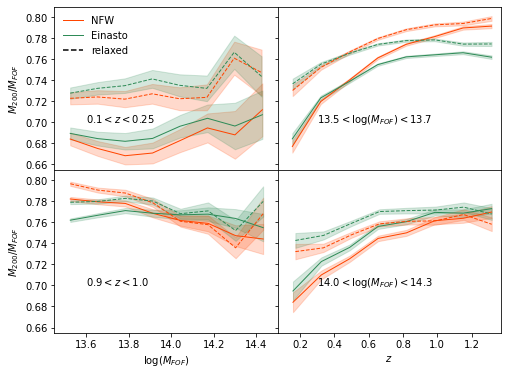

In [35]:
f, ax = plt.subplots(2,2, figsize=(8,6),sharey=True)
f.subplots_adjust(hspace=0,wspace=0)

mres = mres2
m = mres*(z > 0.1)*(z < 0.25)*(lgM < 14.5)
make_plot2(lgM[m],10**(lgMNFW_rho - lgM)[m],'orangered',8,label='NFW',error=True,lw=1,plt=ax[0,0])
make_plot2(lgM[m],10**(lgMEin_rho - lgM)[m],'seagreen',8,label='Einasto',error=True,lw=1,plt=ax[0,0])
ax[0,0].plot([-1,-1],[-1,-1],'k--',label='relaxed')
ax[0,0].legend(loc=2,frameon=False)

m = mres*(z > 0.1)*(z < 0.25)*mrelax*(lgM < 14.5)
make_plot2(lgM[m],10**(lgMNFW_rho - lgM)[m],'orangered',8,label='NFW',error=True,lw=1,plt=ax[0,0],lt='--')
make_plot2(lgM[m],10**(lgMEin_rho - lgM)[m],'seagreen',8,label='Einasto',error=True,lw=1,plt=ax[0,0],lt='--')

ax[0,0].set_ylabel(r'$M_{200}/M_{FOF}$')
ax[1,0].set_ylabel(r'$M_{200}/M_{FOF}$')
ax[0,0].set_xlim([13.45,14.5])
ax[1,0].set_xlim([13.45,14.5])

m = mres*(z > 0.9)*(z < 1)*(lgM < 14.5)
make_plot2(lgM[m],10**(lgMNFW_rho - lgM)[m],'orangered',8,label='NFW',error=True,lw=1,plt=ax[1,0])
make_plot2(lgM[m],10**(lgMEin_rho - lgM)[m],'seagreen',8,label='Einasto',error=True,lw=1,plt=ax[1,0])
m = mres*(z > 0.9)*(z < 1)*(lgM < 14.5)*mrelax
make_plot2(lgM[m],10**(lgMNFW_rho - lgM)[m],'orangered',8,label='NFW',error=True,lw=1,plt=ax[1,0],lt='--')
make_plot2(lgM[m],10**(lgMEin_rho - lgM)[m],'seagreen',8,label='Einasto',error=True,lw=1,plt=ax[1,0],lt='--')

ax[1,0].set_xlabel(r'$\log (M_{FOF})$')
ax[0,0].text(13.6,0.7,'$0.1 < z < 0.25$')
ax[1,0].text(13.6,0.7,'$0.9 < z < 1.0$')

m = mres*(z > 0.07)*(z < 1.4)*(lgM > 13.5)*(lgM < 13.7)
make_plot2(z[m],10**(lgMNFW_rho - lgM)[m],'orangered',8,label='NFW',error=True,lw=1,plt=ax[0,1])
make_plot2(z[m],10**(lgMEin_rho - lgM)[m],'seagreen',8,label='Einasto',error=True,lw=1,plt=ax[0,1])
m = mres*(z > 0.07)*(z < 1.4)*(lgM > 13.5)*(lgM < 13.7)*mrelax
make_plot2(z[m],10**(lgMNFW_rho - lgM)[m],'orangered',8,label='NFW',error=True,lw=1,plt=ax[0,1],lt='--')
make_plot2(z[m],10**(lgMEin_rho - lgM)[m],'seagreen',8,label='Einasto',error=True,lw=1,plt=ax[0,1],lt='--')

ax[0,1].set_xlim([0.07,1.37])
ax[1,1].set_xlim([0.07,1.37])

m = mres*(z > 0.07)*(z < 1.4)*(lgM > 14.0)*(lgM < 14.3)
make_plot2(z[m],10**(lgMNFW_rho - lgM)[m],'orangered',8,label='NFW',error=True,lw=1,plt=ax[1,1])
make_plot2(z[m],10**(lgMEin_rho - lgM)[m],'seagreen',8,label='Einasto',error=True,lw=1,plt=ax[1,1])
m = mres*(z > 0.07)*(z < 1.4)*(lgM > 14.0)*(lgM < 14.3)*mrelax
make_plot2(z[m],10**(lgMNFW_rho - lgM)[m],'orangered',8,label='NFW',error=True,lw=1,plt=ax[1,1],lt='--')
make_plot2(z[m],10**(lgMEin_rho - lgM)[m],'seagreen',8,label='Einasto',error=True,lw=1,plt=ax[1,1],lt='--')

# ax[1,1].set_ylim([0.65,0.82])
ax[1,1].set_xlabel(r'$z$')
ax[0,1].text(0.3,0.7,'$13.5 < \log(M_{FOF}) < 13.7$')
ax[1,1].text(0.3,0.7,'$14.0 < \log(M_{FOF}) < 14.3$')
ax[1,1].set_ylim([0.655,0.81])
f.savefig(plot_path+'MFOF_M200.pdf',bbox_inches='tight')
hide_toggle()

### Comparison with shape

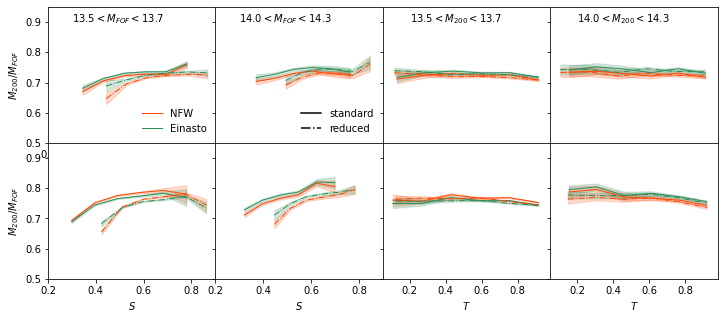

In [45]:
f, ax = plt.subplots(2,4, figsize=(12,5),sharey=True)
f.subplots_adjust(hspace=0,wspace=0)
mres = mres1
m = mres*(z > 0.1)*(z < 0.25)*(lgM > 13.5)*(lgM < 13.7)*mrelax
make_plot2(s[m],10**(lgMNFW_rho - lgM)[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[0,0])
m = mres*(z > 0.1)*(z < 0.25)*(lgM > 13.5)*(lgM < 13.7)*mrelax
make_plot2(s[m],10**(lgMEin_rho - lgM)[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[0,0])
ax[0,0].legend(loc=4,frameon=False)

m = mres*(z > 0.1)*(z < 0.25)*(lgM > 13.5)*mrelax*(lgMNFW_rho < 13.7)
make_plot2(sr[m],10**(lgMNFW_rho - lgM)[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[0,0],lt='-.')
m = mres*(z > 0.1)*(z < 0.25)*(lgM > 13.5)*mrelax*(lgMEin_rho < 13.7)
make_plot2(sr[m],10**(lgMEin_rho - lgM)[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[0,0],lt='-.')

ax[0,0].set_ylabel(r'$M_{200}/M_{FOF}$')
ax[1,0].set_ylabel(r'$M_{200}/M_{FOF}$')

ax[0,1].plot([-1,-1],[-1,-1],'k-',label='standard')
ax[0,1].plot([-1,-1],[-1,-1],'k-.',label='reduced')
ax[0,1].legend(loc=4,frameon=False)

m = mres*(z > 0.9)*(z < 1)*(lgM > 13.5)*(lgM < 13.7)*mrelax
make_plot2(s[m],10**(lgMNFW_rho - lgM)[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[1,0])
m = mres*(z > 0.9)*(z < 1)*(lgM > 13.5)*(lgM < 13.7)*mrelax
make_plot2(s[m],10**(lgMEin_rho - lgM)[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[1,0])

m = mres*(z > 0.9)*(z < 1)*(lgM > 13.5)*mrelax*(lgMNFW_rho < 13.7)
make_plot2(sr[m],10**(lgMNFW_rho - lgM)[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[1,0],lt='-.')
m = mres*(z > 0.9)*(z < 1)*(lgM > 13.5)*mrelax*(lgMEin_rho < 13.7)
make_plot2(sr[m],10**(lgMEin_rho - lgM)[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[1,0],lt='-.')

ax[1,0].set_xlabel(r'$S$')

ax[0,0].text(0.3,0.9,'$13.5 < M_{FOF} < 13.7$')
ax[0,1].text(0.3,0.9,'$14.0 < M_{FOF} < 14.3$')

m = mres*(z > 0.1)*(z < 0.25)*(lgM > 14.)*(lgM < 14.3)*mrelax
make_plot2(s[m],10**(lgMNFW_rho - lgM)[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[0,1])
m = mres*(z > 0.1)*(z < 0.25)*(lgM > 14.)*(lgM < 14.3)*mrelax
make_plot2(s[m],10**(lgMEin_rho - lgM)[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[0,1])

m = mres*(z > 0.1)*(z < 0.25)*(lgM > 14)*(lgM < 14.3)*mrelax
make_plot2(sr[m],10**(lgMNFW_rho - lgM)[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[0,1],lt='-.')
m = mres*(z > 0.1)*(z < 0.25)*(lgM > 14)*(lgM < 14.3)*mrelax
make_plot2(sr[m],10**(lgMEin_rho - lgM)[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[0,1],lt='-.')

m = mres*(z > 0.9)*(z < 1.)*(lgM > 14)*(lgM < 14.3)*mrelax
make_plot2(s[m],10**(lgMNFW_rho - lgM)[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[1,1])
m = mres*(z > 0.9)*(z < 1.)*(lgM > 14)*(lgM < 14.3)*mrelax
make_plot2(s[m],10**(lgMEin_rho - lgM)[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[1,1])

m = mres*(z > 0.9)*(z < 1.)*(lgM > 14)*mrelax*(lgMNFW_rho < 14.3)
make_plot2(sr[m],10**(lgMNFW_rho - lgM)[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[1,1],lt='-.')
m = mres*(z > 0.9)*(z < 1.)*(lgM > 14)*mrelax*(lgMEin_rho < 14.3)
make_plot2(sr[m],10**(lgMEin_rho - lgM)[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[1,1],lt='-.')

ax[1,1].set_xlabel(r'$S$')

m = mres*(z > 0.1)*(z < 0.25)*(lgM > 13.5)*(lgM < 13.7)*mrelax
make_plot2(T[m],10**(lgMNFW_rho - lgM)[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[0,2])
m = mres*(z > 0.1)*(z < 0.25)*(lgM > 13.5)*(lgM < 13.7)*mrelax
make_plot2(T[m],10**(lgMEin_rho - lgM)[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[0,2])

m = mres*(z > 0.1)*(z < 0.25)*(lgM > 13.5)*mrelax*(lgMNFW_rho < 13.7)
make_plot2(Tr[m],10**(lgMNFW_rho - lgM)[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[0,2],lt='-.')
m = mres*(z > 0.1)*(z < 0.25)*(lgM > 13.5)*mrelax*(lgMEin_rho < 13.7)
make_plot2(Tr[m],10**(lgMEin_rho - lgM)[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[0,2],lt='-.')

m = mres*(z > 0.9)*(z < 1)*(lgM > 13.5)*(lgM < 13.7)*mrelax
make_plot2(T[m],10**(lgMNFW_rho - lgM)[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[1,2])
m = mres*(z > 0.9)*(z < 1)*(lgM > 13.5)*(lgM < 13.7)*mrelax
make_plot2(T[m],10**(lgMEin_rho - lgM)[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[1,2])

m = mres*(z > 0.9)*(z < 1)*(lgM > 13.5)*mrelax*(lgMNFW_rho < 13.7)
make_plot2(Tr[m],10**(lgMNFW_rho - lgM)[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[1,2],lt='-.')
m = mres*(z > 0.9)*(z < 1)*(lgM > 13.5)*mrelax*(lgMEin_rho < 13.7)
make_plot2(Tr[m],10**(lgMEin_rho - lgM)[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[1,2],lt='-.')

ax[1,2].set_xlabel(r'$T$')
ax[0,2].text(0.2,0.9,'$13.5 < M_{200} < 13.7$')
ax[0,3].text(0.2,0.9,'$14.0 < M_{200} < 14.3$')

m = mres*(z > 0.1)*(z < 0.25)*(lgM > 14.)*(lgM < 14.3)*mrelax
make_plot2(T[m],10**(lgMNFW_rho - lgM)[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[0,3])
m = mres*(z > 0.1)*(z < 0.25)*(lgM > 14.)*(lgM < 14.3)*mrelax
make_plot2(T[m],10**(lgMEin_rho - lgM)[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[0,3])

m = mres*(z > 0.1)*(z < 0.25)*(lgM > 14)*(lgM < 14.3)*mrelax
make_plot2(Tr[m],10**(lgMNFW_rho - lgM)[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[0,3],lt='-.')
m = mres*(z > 0.1)*(z < 0.25)*(lgM > 14)*(lgM < 14.3)*mrelax
make_plot2(Tr[m],10**(lgMEin_rho - lgM)[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[0,3],lt='-.')

m = mres*(z > 0.9)*(z < 1.)*(lgM > 14)*(lgM < 14.3)*mrelax
make_plot2(T[m],10**(lgMNFW_rho - lgM)[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[1,3])
m = mres*(z > 0.9)*(z < 1.)*(lgM > 14)*(lgM < 14.3)*mrelax
make_plot2(T[m],10**(lgMEin_rho - lgM)[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[1,3])

m = mres*(z > 0.9)*(z < 1.)*(lgM > 14)*mrelax*(lgMNFW_rho < 14.3)
make_plot2(Tr[m],10**(lgMNFW_rho - lgM)[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[1,3],lt='-.')
m = mres*(z > 0.9)*(z < 1.)*(lgM > 14)*mrelax*(lgMEin_rho < 14.3)
make_plot2(Tr[m],10**(lgMEin_rho - lgM)[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[1,3],lt='-.')

ax[1,3].set_xlabel(r'$T$')

ax[0,0].set_xlim([0.2,0.9])
ax[1,0].set_xlim([0.2,0.9])
ax[0,1].set_xlim([0.2,0.9])
ax[1,1].set_xlim([0.2,0.9])

ax[0,2].set_xlim([0.05,0.98])
ax[1,2].set_xlim([0.05,0.98])
ax[0,3].set_xlim([0.05,0.98])
ax[1,3].set_xlim([0.05,0.98])
ax[1,0].set_ylim([0.5,0.95])

#f.savefig(plot_path+'MFOF_M200_shape.pdf',bbox_inches='tight')
hide_toggle()


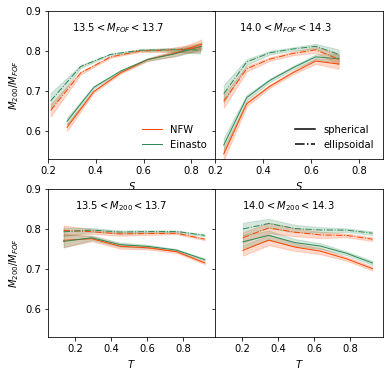

In [12]:
f, ax_all = plt.subplots(2,2, figsize=(6,6),sharey=True)
f.subplots_adjust(wspace=0)
ax = [ax_all[0,0],ax_all[0,1],ax_all[1,0],ax_all[1,1]]

msel = mfit*mrelax*(z > 0.35)*(z < 0.40)
m = msel*(lgM > 13.5)*(lgM < 13.7)*mrelax
make_plot2(s[m],10**(lgMNFW_rho - lgM)[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[0])
m = msel*(lgM > 13.5)*(lgM < 13.7)*mrelax
make_plot2(s[m],10**(lgMEin_rho - lgM)[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[0])
ax[0].legend(loc=4,frameon=False)

m = msel*(lgM > 13.5)*mrelax*(lgMNFW_rho < 13.7)
make_plot2(s[m],10**(lgMNFW_rho_E - lgM)[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[0],lt='-.')
m = msel*(lgM > 13.5)*mrelax*(lgMEin_rho < 13.7)
make_plot2(s[m],10**(lgMEin_rho_E - lgM)[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[0],lt='-.')


ax[0].set_ylabel(r'$M_{200}/M_{FOF}$')
ax[2].set_ylabel(r'$M_{200}/M_{FOF}$')

ax[1].plot([-1,-1],[-1,-1],'k-',label='spherical')
ax[1].plot([-1,-1],[-1,-1],'k-.',label='ellipsoidal')
ax[1].legend(loc=4,frameon=False)

ax[0].set_xlabel(r'$S$')

ax[0].text(0.3,0.85,'$13.5 < M_{FOF} < 13.7$')
ax[1].text(0.3,0.85,'$14.0 < M_{FOF} < 14.3$')

m = msel*(lgM > 14.)*(lgM < 14.3)*mrelax
make_plot2(s[m],10**(lgMNFW_rho - lgM)[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[1])
m = msel*(lgM > 14.)*(lgM < 14.3)*mrelax
make_plot2(s[m],10**(lgMEin_rho - lgM)[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[1])

m = msel*(lgM > 14)*(lgM < 14.3)*mrelax
make_plot2(s[m],10**(lgMNFW_rho_E - lgM)[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[1],lt='-.')
m = msel*(lgM > 14)*(lgM < 14.3)*mrelax
make_plot2(s[m],10**(lgMEin_rho_E - lgM)[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[1],lt='-.')

ax[1].set_xlabel(r'$S$')

m = msel*(lgM > 13.5)*(lgM < 13.7)*mrelax
make_plot2(T[m],10**(lgMNFW_rho - lgM)[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[2])
m = msel*(lgM > 13.5)*(lgM < 13.7)*mrelax
make_plot2(T[m],10**(lgMEin_rho - lgM)[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[2])

m = msel*(lgM > 13.5)*mrelax*(lgMNFW_rho < 13.7)
make_plot2(T[m],10**(lgMNFW_rho_E - lgM)[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[2],lt='-.')
m = msel*(lgM > 13.5)*mrelax*(lgMEin_rho < 13.7)
make_plot2(T[m],10**(lgMEin_rho_E - lgM)[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[2],lt='-.')


ax[2].set_xlabel(r'$T$')
ax[2].text(0.2,0.85,'$13.5 < M_{200} < 13.7$')
ax[3].text(0.2,0.85,'$14.0 < M_{200} < 14.3$')

m = msel*(lgM > 14.)*(lgM < 14.3)*mrelax
make_plot2(T[m],10**(lgMNFW_rho - lgM)[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[3])
m = msel*(lgM > 14.)*(lgM < 14.3)*mrelax
make_plot2(T[m],10**(lgMEin_rho - lgM)[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[3])

m = msel*(lgM > 14)*(lgM < 14.3)*mrelax
make_plot2(T[m],10**(lgMNFW_rho_E - lgM)[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[3],lt='-.')
m = msel*(lgM > 14)*(lgM < 14.3)*mrelax
make_plot2(T[m],10**(lgMEin_rho_E - lgM)[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[3],lt='-.')


ax[3].set_xlabel(r'$T$')

ax[0].set_xlim([0.2,0.9])
ax[1].set_xlim([0.2,0.9])
ax[2].set_xlim([0.05,0.98])
ax[3].set_xlim([0.05,0.98])
ax[1].set_ylim([0.53,0.9])

f.savefig(plot_path+'MFOF_M200_shape.pdf',bbox_inches='tight')
hide_toggle()


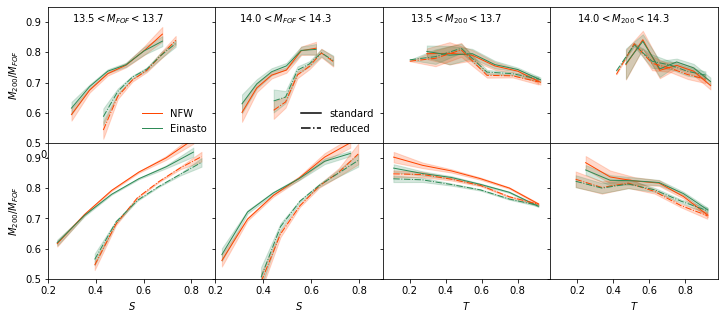

In [53]:
f, ax = plt.subplots(2,4, figsize=(12,5),sharey=True)
f.subplots_adjust(hspace=0,wspace=0)
mres = mres2*mrelax
m = mres*(z > 0.1)*(z < 0.25)*(lgM > 13.5)*(lgM < 13.7)*mrelax
make_plot2(s[m],10**(lgMNFW_rho - lgM)[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[0,0])
m = mres*(z > 0.1)*(z < 0.25)*(lgM > 13.5)*(lgM < 13.7)*mrelax
make_plot2(s[m],10**(lgMEin_rho - lgM)[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[0,0])
ax[0,0].legend(loc=4,frameon=False)

m = mres*(z > 0.1)*(z < 0.25)*(lgM > 13.5)*mrelax*(lgMNFW_rho < 13.7)
make_plot2(sr[m],10**(lgMNFW_rho - lgM)[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[0,0],lt='-.')
m = mres*(z > 0.1)*(z < 0.25)*(lgM > 13.5)*mrelax*(lgMEin_rho < 13.7)
make_plot2(sr[m],10**(lgMEin_rho - lgM)[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[0,0],lt='-.')

ax[0,0].set_ylabel(r'$M_{200}/M_{FOF}$')
ax[1,0].set_ylabel(r'$M_{200}/M_{FOF}$')

ax[0,1].plot([-1,-1],[-1,-1],'k-',label='standard')
ax[0,1].plot([-1,-1],[-1,-1],'k-.',label='reduced')
ax[0,1].legend(loc=4,frameon=False)

m = mres*(z > 0.9)*(z < 1)*(lgM > 13.5)*(lgM < 13.7)*mrelax
make_plot2(s[m],10**(lgMNFW_rho - lgM)[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[1,0])
m = mres*(z > 0.9)*(z < 1)*(lgM > 13.5)*(lgM < 13.7)*mrelax
make_plot2(s[m],10**(lgMEin_rho - lgM)[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[1,0])

m = mres*(z > 0.9)*(z < 1)*(lgM > 13.5)*mrelax*(lgMNFW_rho < 13.7)
make_plot2(sr[m],10**(lgMNFW_rho - lgM)[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[1,0],lt='-.')
m = mres*(z > 0.9)*(z < 1)*(lgM > 13.5)*mrelax*(lgMEin_rho < 13.7)
make_plot2(sr[m],10**(lgMEin_rho - lgM)[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[1,0],lt='-.')

ax[1,0].set_xlabel(r'$S$')

ax[0,0].text(0.3,0.9,'$13.5 < M_{FOF} < 13.7$')
ax[0,1].text(0.3,0.9,'$14.0 < M_{FOF} < 14.3$')

m = mres*(z > 0.1)*(z < 0.25)*(lgM > 14.)*(lgM < 14.3)*mrelax
make_plot2(s[m],10**(lgMNFW_rho - lgM)[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[0,1])
m = mres*(z > 0.1)*(z < 0.25)*(lgM > 14.)*(lgM < 14.3)*mrelax
make_plot2(s[m],10**(lgMEin_rho - lgM)[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[0,1])

m = mres*(z > 0.1)*(z < 0.25)*(lgM > 14)*(lgM < 14.3)*mrelax
make_plot2(sr[m],10**(lgMNFW_rho - lgM)[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[0,1],lt='-.')
m = mres*(z > 0.1)*(z < 0.25)*(lgM > 14)*(lgM < 14.3)*mrelax
make_plot2(sr[m],10**(lgMEin_rho - lgM)[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[0,1],lt='-.')

m = mres*(z > 0.9)*(z < 1.)*(lgM > 14)*(lgM < 14.3)*mrelax
make_plot2(s[m],10**(lgMNFW_rho - lgM)[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[1,1])
m = mres*(z > 0.9)*(z < 1.)*(lgM > 14)*(lgM < 14.3)*mrelax
make_plot2(s[m],10**(lgMEin_rho - lgM)[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[1,1])

m = mres*(z > 0.9)*(z < 1.)*(lgM > 14)*mrelax*(lgMNFW_rho < 14.3)
make_plot2(sr[m],10**(lgMNFW_rho - lgM)[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[1,1],lt='-.')
m = mres*(z > 0.9)*(z < 1.)*(lgM > 14)*mrelax*(lgMEin_rho < 14.3)
make_plot2(sr[m],10**(lgMEin_rho - lgM)[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[1,1],lt='-.')

ax[1,1].set_xlabel(r'$S$')

m = mres*(z > 0.1)*(z < 0.25)*(lgM > 13.5)*(lgM < 13.7)*mrelax
make_plot2(T[m],10**(lgMNFW_rho - lgM)[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[0,2])
m = mres*(z > 0.1)*(z < 0.25)*(lgM > 13.5)*(lgM < 13.7)*mrelax
make_plot2(T[m],10**(lgMEin_rho - lgM)[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[0,2])

m = mres*(z > 0.1)*(z < 0.25)*(lgM > 13.5)*mrelax*(lgMNFW_rho < 13.7)
make_plot2(Tr[m],10**(lgMNFW_rho - lgM)[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[0,2],lt='-.')
m = mres*(z > 0.1)*(z < 0.25)*(lgM > 13.5)*mrelax*(lgMEin_rho < 13.7)
make_plot2(Tr[m],10**(lgMEin_rho - lgM)[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[0,2],lt='-.')

m = mres*(z > 0.9)*(z < 1)*(lgM > 13.5)*(lgM < 13.7)*mrelax
make_plot2(T[m],10**(lgMNFW_rho - lgM)[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[1,2])
m = mres*(z > 0.9)*(z < 1)*(lgM > 13.5)*(lgM < 13.7)*mrelax
make_plot2(T[m],10**(lgMEin_rho - lgM)[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[1,2])

m = mres*(z > 0.9)*(z < 1)*(lgM > 13.5)*mrelax*(lgMNFW_rho < 13.7)
make_plot2(Tr[m],10**(lgMNFW_rho - lgM)[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[1,2],lt='-.')
m = mres*(z > 0.9)*(z < 1)*(lgM > 13.5)*mrelax*(lgMEin_rho < 13.7)
make_plot2(Tr[m],10**(lgMEin_rho - lgM)[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[1,2],lt='-.')

ax[1,2].set_xlabel(r'$T$')
ax[0,2].text(0.2,0.9,'$13.5 < M_{200} < 13.7$')
ax[0,3].text(0.2,0.9,'$14.0 < M_{200} < 14.3$')

m = mres*(z > 0.1)*(z < 0.25)*(lgM > 14.)*(lgM < 14.3)*mrelax
make_plot2(T[m],10**(lgMNFW_rho - lgM)[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[0,3])
m = mres*(z > 0.1)*(z < 0.25)*(lgM > 14.)*(lgM < 14.3)*mrelax
make_plot2(T[m],10**(lgMEin_rho - lgM)[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[0,3])

m = mres*(z > 0.1)*(z < 0.25)*(lgM > 14)*(lgM < 14.3)*mrelax
make_plot2(Tr[m],10**(lgMNFW_rho - lgM)[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[0,3],lt='-.')
m = mres*(z > 0.1)*(z < 0.25)*(lgM > 14)*(lgM < 14.3)*mrelax
make_plot2(Tr[m],10**(lgMEin_rho - lgM)[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[0,3],lt='-.')

m = mres*(z > 0.9)*(z < 1.)*(lgM > 14)*(lgM < 14.3)*mrelax
make_plot2(T[m],10**(lgMNFW_rho - lgM)[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[1,3])
m = mres*(z > 0.9)*(z < 1.)*(lgM > 14)*(lgM < 14.3)*mrelax
make_plot2(T[m],10**(lgMEin_rho - lgM)[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[1,3])

m = mres*(z > 0.9)*(z < 1.)*(lgM > 14)*mrelax*(lgMNFW_rho < 14.3)
make_plot2(Tr[m],10**(lgMNFW_rho - lgM)[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[1,3],lt='-.')
m = mres*(z > 0.9)*(z < 1.)*(lgM > 14)*mrelax*(lgMEin_rho < 14.3)
make_plot2(Tr[m],10**(lgMEin_rho - lgM)[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[1,3],lt='-.')

ax[1,3].set_xlabel(r'$T$')

ax[0,0].set_xlim([0.2,0.9])
ax[1,0].set_xlim([0.2,0.9])
ax[0,1].set_xlim([0.2,0.9])
ax[1,1].set_xlim([0.2,0.9])

ax[0,2].set_xlim([0.05,0.98])
ax[1,2].set_xlim([0.05,0.98])
ax[0,3].set_xlim([0.05,0.98])
ax[1,3].set_xlim([0.05,0.98])
ax[1,0].set_ylim([0.5,0.95])

f.savefig(plot_path+'MFOF_M200_shape.pdf',bbox_inches='tight')
hide_toggle()


## SPHERICAL vs ELLIPTICAL 

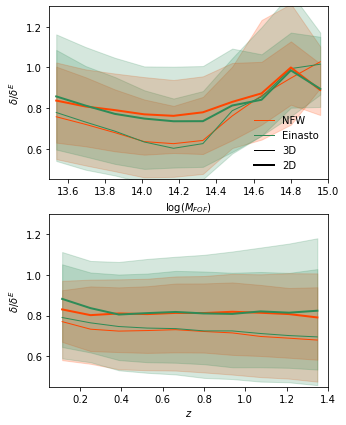

In [48]:
f, ax = plt.subplots(2,1, figsize=(5,7))
# f.subplots_adjust(hspace=0,wspace=0)
m = mres2*mrelax
make_plot2(lgM[m],(resNFW_rho/resNFW_rho_E)[m],'orangered',10,label='NFW',lw=1,plt=ax[0])
make_plot2(lgM[m],(resEin_rho/resEin_rho_E)[m],'seagreen',10,label='Einasto',lw=1,plt=ax[0])
ax[0].plot([-1,-1],[-2,-1],'k',label='3D',lw=1)
ax[0].plot([-1,-1],[-2,-1],'k',label='2D',lw=2)
ax[0].legend(loc=4,frameon=False)
make_plot2(lgM[m],(resNFW_S/resNFW_S_E)[m],'orangered',10,label='NFW',lw=2,plt=ax[0])
make_plot2(lgM[m],(resEin_S/resEin_S_E)[m],'seagreen',10,label='NFW',lw=2,plt=ax[0])
# m = mfit*(Npart > 10000)
make_plot2(z[m],(resNFW_rho/resNFW_rho_E)[m],'orangered',10,label='NFW',lw=1,plt=ax[1])
make_plot2(z[m],(resEin_rho/resEin_rho_E)[m],'seagreen',10,label='Einasto',lw=1,plt=ax[1])
make_plot2(z[m],(resNFW_S/resNFW_S_E)[m],'orangered',10,label='NFW',lw=2,plt=ax[1])
make_plot2(z[m],(resEin_S/resEin_S_E)[m],'seagreen',10,label='NFW',lw=2,plt=ax[1])
ax[0].set_xlabel('$\log(M_{FOF})$')
ax[1].set_xlabel('$z$')
ax[0].set_ylabel('$\delta / \delta^E$')
ax[1].set_ylabel('$\delta / \delta^E$')
ax[0].set_xlim([13.5,15])
ax[1].set_xlim([0.05,1.4])
ax[0].set_ylim([0.45,1.3])
ax[1].set_ylim([0.45,1.3])
f.savefig(plot_path+'res_ellip.pdf',bbox_inches='tight')
hide_toggle()


### For a massive subsample

/tmp/ipykernel_12561/3094128948.py:45: RuntimeWarning: divide by zero encountered in true_divide
  make_plot2(q2d[m],(alpha_S[m]/alpha_S_E[m]),'seagreen',7,label='Einasto',plt=ax[3,1])
/home/eli/miniconda3/envs/py3env2/lib/python3.9/site-packages/numpy/core/_methods.py:230: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


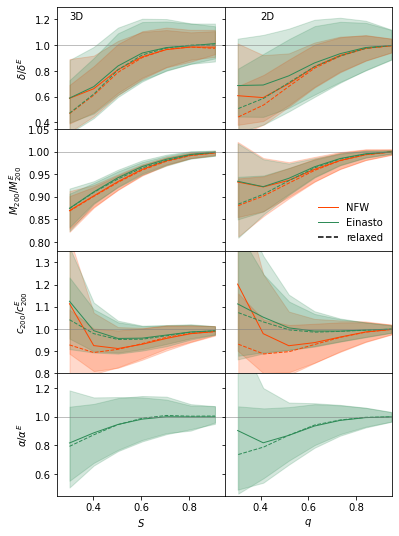

In [7]:
f, ax = plt.subplots(4,2, figsize=(6,9))
f.subplots_adjust(hspace=0,wspace=0)
msel = mfit*(s<1.)*(s>0.25)*(lgM>13)#*(lgM<14.)#*mres2

m = msel
make_plot2(s[m],(resNFW_rho/resNFW_rho_E)[m],'orangered',7,label='NFW',error=False,lw=1,plt=ax[0,0])
make_plot2(s[m],(resEin_rho/resEin_rho_E)[m],'seagreen',7,label='Einasto',error=False,lw=1,plt=ax[0,0])
make_plot2(q2d[m],(resNFW_S/resNFW_S_E)[m],'orangered',7,label='Einasto',error=False,plt=ax[0,1])
make_plot2(q2d[m],(resEin_S/resEin_S_E)[m],'seagreen',7,label='Einasto',error=False,plt=ax[0,1])

m = msel*mrelax
make_plot2(s[m],(resNFW_rho/resNFW_rho_E)[m],'orangered',7,label='NFW',error=False,lw=1,plt=ax[0,0],lt='--')
make_plot2(s[m],(resEin_rho/resEin_rho_E)[m],'seagreen',7,label='Einasto',error=False,lw=1,plt=ax[0,0],lt='--')
make_plot2(q2d[m],(resNFW_S/resNFW_S_E)[m],'orangered',7,label='Einasto',error=False,plt=ax[0,1],lt='--')
make_plot2(q2d[m],(resEin_S/resEin_S_E)[m],'seagreen',7,label='Einasto',error=False,plt=ax[0,1],lt='--')

m = msel
make_plot2(s[m],10**(lgMNFW_rho-lgMNFW_rho_E)[m],'orangered',7,label='NFW',error=False,plt=ax[1,0])
make_plot2(s[m],10**(lgMEin_rho-lgMEin_rho_E)[m],'seagreen',7,label='Einasto',error=False,plt=ax[1,0])
make_plot2(q2d[m],10**(lgMNFW_S-lgMNFW_S_E)[m],'orangered',7,label='NFW',error=False,plt=ax[1,1])
make_plot2(q2d[m],10**(lgMEin_S-lgMEin_S_E)[m],'seagreen',7,label='Einasto',error=False,plt=ax[1,1])
ax[1,1].plot([-1,0],[-1,0],'k--',label='relaxed')
ax[1,1].legend(loc=4,frameon=False)

m = msel*mrelax
make_plot2(s[m],10**(lgMNFW_rho-lgMNFW_rho_E)[m],'orangered',7,label='NFW',error=False,lw=1,plt=ax[1,0],lt='--')
make_plot2(s[m],10**(lgMEin_rho-lgMEin_rho_E)[m],'seagreen',7,label='Einasto',error=False,plt=ax[1,0],lt='--')
make_plot2(q2d[m],10**(lgMNFW_S-lgMNFW_S_E)[m],'orangered',7,label='NFW',error=False,plt=ax[1,1],lt='--')
make_plot2(q2d[m],10**(lgMEin_S-lgMEin_S_E)[m],'seagreen',7,label='Einasto',error=False,plt=ax[1,1],lt='--')

m = msel
make_plot2(s[m],(cNFW_rho[m]/cNFW_rho_E[m]),'orangered',7,label='NFW',error=False,lw=1,plt=ax[2,0])
make_plot2(s[m],(cEin_rho[m]/cEin_rho_E[m]),'seagreen',7,label='Einasto',error=False,lw=1,plt=ax[2,0])
make_plot2(q2d[m],(cNFW_S[m]/cNFW_S_E[m]),'orangered',7,label='NFW',error=False,plt=ax[2,1])
make_plot2(q2d[m],(cEin_S[m]/cEin_S_E[m]),'seagreen',7,label='Einasto',error=False,plt=ax[2,1])

m = msel*mrelax
make_plot2(s[m],(cNFW_rho[m]/cNFW_rho_E[m]),'orangered',7,label='NFW',error=False,lw=1,plt=ax[2,0],lt='--')
make_plot2(s[m],(cEin_rho[m]/cEin_rho_E[m]),'seagreen',7,label='Einasto',error=False,lw=1,plt=ax[2,0],lt='--')
make_plot2(q2d[m],(cNFW_S[m]/cNFW_S_E[m]),'orangered',7,label='NFW',error=False,plt=ax[2,1],lt='--')
make_plot2(q2d[m],(cEin_S[m]/cEin_S_E[m]),'seagreen',7,label='Einasto',error=False,plt=ax[2,1],lt='--')

m = msel
make_plot2(s[m],(alpha_rho[m]/alpha_rho_E[m]),'seagreen',7,label='Einasto',error=False,lw=1,plt=ax[3,0])
make_plot2(q2d[m],(alpha_S[m]/alpha_S_E[m]),'seagreen',7,label='Einasto',plt=ax[3,1])

m = msel*mrelax
make_plot2(s[m],(alpha_rho[m]/alpha_rho_E[m]),'seagreen',7,label='Einasto',error=False,lw=1,plt=ax[3,0],lt='--')
make_plot2(q2d[m],(alpha_S[m]/alpha_S_E[m]),'seagreen',7,label='Einasto',plt=ax[3,1],lt='--')

ax[0,0].text(0.3,1.2,'3D')
ax[0,1].text(0.4,1.2,'2D')

ax[0,0].set_ylim([0.35,1.3])
ax[0,1].set_ylim([0.35,1.3])
ax[1,0].set_ylim([0.78,1.05])
ax[1,1].set_ylim([0.78,1.05])
ax[2,0].set_ylim([0.8,1.35])
ax[2,1].set_ylim([0.8,1.35])
ax[3,0].set_ylim([0.45,1.3])
ax[3,1].set_ylim([0.45,1.3])

for j in range(4):
    ax[j,0].plot([0,1.4],[1,1],'C7',lw=0.5)
    ax[j,1].plot([0,1.4],[1,1],'C7',lw=0.5)
    ax[j,1].set_yticklabels([])
    ax[j,0].set_xlim([0.25,0.95])
    ax[j,1].set_xlim([0.25,0.95])

ax[3,0].set_xlabel('$S$')
ax[3,1].set_xlabel('$q$')
ax[0,0].set_ylabel('$\delta/\delta^E$')
ax[1,0].set_ylabel('$M_{200}/M^E_{200}$')
ax[2,0].set_ylabel('$c_{200}/c^E_{200}$')
ax[3,0].set_ylabel(r'$\alpha/\alpha^E$')
f.savefig(plot_path+'spherical_elliptical.pdf',bbox_inches='tight')
hide_toggle()

/tmp/ipykernel_3100/1200194334.py:45: RuntimeWarning: divide by zero encountered in true_divide
  make_plot2(lgM[m],(alpha_S[m]/alpha_S_E[m]),'seagreen',7,label='Einasto',plt=ax[3,1])
/home/eli/miniconda3/envs/py3env2/lib/python3.9/site-packages/numpy/core/_methods.py:230: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


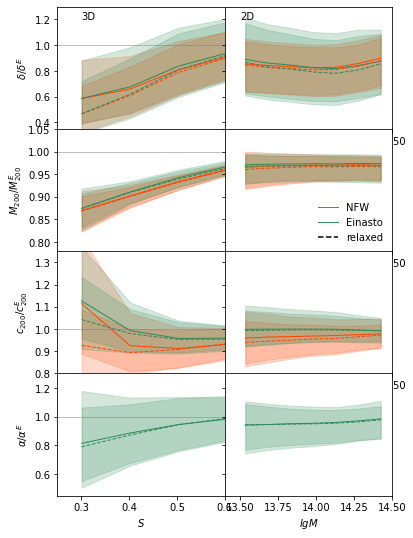

In [14]:
f, ax = plt.subplots(4,2, figsize=(6,9))
f.subplots_adjust(hspace=0,wspace=0)
msel = mfit*(s>0.25)*(lgM<14.5)#*(lgM<14.)#*mres2

m = msel
make_plot2(s[m],(resNFW_rho/resNFW_rho_E)[m],'orangered',7,label='NFW',error=False,lw=1,plt=ax[0,0])
make_plot2(s[m],(resEin_rho/resEin_rho_E)[m],'seagreen',7,label='Einasto',error=False,lw=1,plt=ax[0,0])
make_plot2(lgM[m],(resNFW_S/resNFW_S_E)[m],'orangered',7,label='Einasto',error=False,plt=ax[0,1])
make_plot2(lgM[m],(resEin_S/resEin_S_E)[m],'seagreen',7,label='Einasto',error=False,plt=ax[0,1])

m = msel*mrelax
make_plot2(s[m],(resNFW_rho/resNFW_rho_E)[m],'orangered',7,label='NFW',error=False,lw=1,plt=ax[0,0],lt='--')
make_plot2(s[m],(resEin_rho/resEin_rho_E)[m],'seagreen',7,label='Einasto',error=False,lw=1,plt=ax[0,0],lt='--')
make_plot2(lgM[m],(resNFW_S/resNFW_S_E)[m],'orangered',7,label='Einasto',error=False,plt=ax[0,1],lt='--')
make_plot2(lgM[m],(resEin_S/resEin_S_E)[m],'seagreen',7,label='Einasto',error=False,plt=ax[0,1],lt='--')

m = msel
make_plot2(s[m],10**(lgMNFW_rho-lgMNFW_rho_E)[m],'orangered',7,label='NFW',error=False,plt=ax[1,0])
make_plot2(s[m],10**(lgMEin_rho-lgMEin_rho_E)[m],'seagreen',7,label='Einasto',error=False,plt=ax[1,0])
make_plot2(lgM[m],10**(lgMNFW_S-lgMNFW_S_E)[m],'orangered',7,label='NFW',error=False,plt=ax[1,1])
make_plot2(lgM[m],10**(lgMEin_S-lgMEin_S_E)[m],'seagreen',7,label='Einasto',error=False,plt=ax[1,1])
ax[1,1].plot([-1,0],[-1,0],'k--',label='relaxed')
ax[1,1].legend(loc=4,frameon=False)

m = msel*mrelax
make_plot2(s[m],10**(lgMNFW_rho-lgMNFW_rho_E)[m],'orangered',7,label='NFW',error=False,lw=1,plt=ax[1,0],lt='--')
make_plot2(s[m],10**(lgMEin_rho-lgMEin_rho_E)[m],'seagreen',7,label='Einasto',error=False,plt=ax[1,0],lt='--')
make_plot2(lgM[m],10**(lgMNFW_S-lgMNFW_S_E)[m],'orangered',7,label='NFW',error=False,plt=ax[1,1],lt='--')
make_plot2(lgM[m],10**(lgMEin_S-lgMEin_S_E)[m],'seagreen',7,label='Einasto',error=False,plt=ax[1,1],lt='--')

m = msel
make_plot2(s[m],(cNFW_rho[m]/cNFW_rho_E[m]),'orangered',7,label='NFW',error=False,lw=1,plt=ax[2,0])
make_plot2(s[m],(cEin_rho[m]/cEin_rho_E[m]),'seagreen',7,label='Einasto',error=False,lw=1,plt=ax[2,0])
make_plot2(lgM[m],(cNFW_S[m]/cNFW_S_E[m]),'orangered',7,label='NFW',error=False,plt=ax[2,1])
make_plot2(lgM[m],(cEin_S[m]/cEin_S_E[m]),'seagreen',7,label='Einasto',error=False,plt=ax[2,1])

m = msel*mrelax
make_plot2(s[m],(cNFW_rho[m]/cNFW_rho_E[m]),'orangered',7,label='NFW',error=False,lw=1,plt=ax[2,0],lt='--')
make_plot2(s[m],(cEin_rho[m]/cEin_rho_E[m]),'seagreen',7,label='Einasto',error=False,lw=1,plt=ax[2,0],lt='--')
make_plot2(lgM[m],(cNFW_S[m]/cNFW_S_E[m]),'orangered',7,label='NFW',error=False,plt=ax[2,1],lt='--')
make_plot2(lgM[m],(cEin_S[m]/cEin_S_E[m]),'seagreen',7,label='Einasto',error=False,plt=ax[2,1],lt='--')

m = msel
make_plot2(s[m],(alpha_rho[m]/alpha_rho_E[m]),'seagreen',7,label='Einasto',error=False,lw=1,plt=ax[3,0])
make_plot2(lgM[m],(alpha_S[m]/alpha_S_E[m]),'seagreen',7,label='Einasto',plt=ax[3,1])

m = msel*mrelax
make_plot2(s[m],(alpha_rho[m]/alpha_rho_E[m]),'seagreen',7,label='Einasto',error=False,lw=1,plt=ax[3,0],lt='--')
make_plot2(lgM[m],(alpha_S[m]/alpha_S_E[m]),'seagreen',7,label='Einasto',plt=ax[3,1],lt='--')

ax[0,0].text(0.3,1.2,'3D')
ax[0,1].text(13.5,1.2,'2D')

ax[0,0].set_ylim([0.35,1.3])
ax[0,1].set_ylim([0.35,1.3])
ax[1,0].set_ylim([0.78,1.05])
ax[1,1].set_ylim([0.78,1.05])
ax[2,0].set_ylim([0.8,1.35])
ax[2,1].set_ylim([0.8,1.35])
ax[3,0].set_ylim([0.45,1.3])
ax[3,1].set_ylim([0.45,1.3])

for j in range(4):
    ax[j,0].plot([0,1.4],[1,1],'C7',lw=0.5)
    ax[j,1].plot([0,1.4],[1,1],'C7',lw=0.5)
    ax[j,1].set_yticklabels([])
    ax[j,0].set_xlim([0.25,0.6])
    ax[j,1].set_xlim([13.4,14.5])

ax[3,0].set_xlabel('$S$')
ax[3,1].set_xlabel('$lgM$')
ax[0,0].set_ylabel('$\delta/\delta^E$')
ax[1,0].set_ylabel('$M_{200}/M^E_{200}$')
ax[2,0].set_ylabel('$c_{200}/c^E_{200}$')
ax[3,0].set_ylabel(r'$\alpha/\alpha^E$')
f.savefig(plot_path+'spherical_elliptical_mass.pdf',bbox_inches='tight')
hide_toggle()

## COMPARISON 3D vs 2D

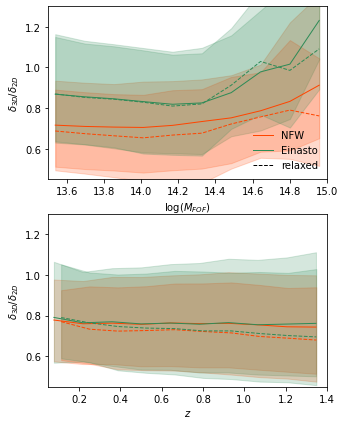

In [78]:
f, ax = plt.subplots(2,1, figsize=(5,7))
# f.subplots_adjust(hspace=0,wspace=0)
mres = mres2
m = mres
make_plot2(lgM[m],(resNFW_rho/resNFW_S)[m],'orangered',10,label='NFW',lw=1,plt=ax[0])
make_plot2(lgM[m],(resEin_rho/resEin_S)[m],'seagreen',10,label='Einasto',lw=1,plt=ax[0])
ax[0].plot([-1,-1],[-2,-1],'k--',label='relaxed',lw=1)
ax[0].legend(loc=4,frameon=False)
m = mres*mrelax
make_plot2(lgM[m],(resNFW_rho/resNFW_S)[m],'orangered',10,label='NFW',lt='--',plt=ax[0])
make_plot2(lgM[m],(resEin_rho/resEin_S)[m],'seagreen',10,label='Einasto',lt='--',plt=ax[0])

m = mres
make_plot2(z[m],(resNFW_rho/resNFW_rho_E)[m],'orangered',10,label='NFW',lw=1,plt=ax[1])
make_plot2(z[m],(resEin_rho/resEin_rho_E)[m],'seagreen',10,label='Einasto',lw=1,plt=ax[1])
m = mres*mrelax
make_plot2(z[m],(resNFW_rho/resNFW_rho_E)[m],'orangered',10,label='NFW',lt='--',plt=ax[1])
make_plot2(z[m],(resEin_rho/resEin_rho_E)[m],'seagreen',10,label='Einasto',lt='--',plt=ax[1])

ax[0].set_xlabel('$\log(M_{FOF})$')
ax[1].set_xlabel('$z$')
ax[0].set_ylabel('$\delta_{3D} / \delta_{2D}$')
ax[1].set_ylabel('$\delta_{3D} / \delta_{2D}$')
ax[0].set_xlim([13.5,15])
ax[1].set_xlim([0.05,1.4])
ax[0].set_ylim([0.45,1.3])
ax[1].set_ylim([0.45,1.3])
f.savefig(plot_path+'res_2D3D.pdf',bbox_inches='tight')
hide_toggle()


### Selected with same elliptical density

In [24]:
print(np.median(10**(lgMNFW_rho-lgMNFW_S)[mfit]))
print(np.median(10**(lgMEin_rho-lgMEin_S)[mfit]))

1.0676281100588392
1.0435950248188932


In [ ]:
f, ax = plt.subplots(4,2, figsize=(6,9))
f.subplots_adjust(hspace=0,wspace=0)
msel = mfit*(q2d > 0.6)*(T > 0.8)#*(lgM > 14)*(lgM < 14.5)*(z < 0.45)*(z > 0.3)

m = msel*(s>0.25)
make_plot2(s[m],(resNFW_rho/resNFW_S)[m],'orangered',7,label='NFW',error=False,lw=1,plt=ax[0,0])
make_plot2(s[m],(resEin_rho/resEin_S)[m],'seagreen',7,label='Einasto',error=False,lw=1,plt=ax[0,0])
m = msel*(lgM < 14.5)
make_plot2(lgM[m],(resNFW_rho/resNFW_S)[m],'orangered',7,label='NFW',error=False,lw=1,plt=ax[0,1])
make_plot2(lgM[m],(resEin_rho/resEin_S)[m],'seagreen',7,label='Einasto',error=False,lw=1,plt=ax[0,1])

m = msel*(s>0.25)*mrelax
make_plot2(s[m],(resNFW_rho/resNFW_S)[m],'orangered',7,label='NFW',error=False,lw=1,plt=ax[0,0],lt='--')
make_plot2(s[m],(resEin_rho/resEin_S)[m],'seagreen',7,label='Einasto',error=False,lw=1,plt=ax[0,0],lt='--')
m = msel*(lgM < 14.5)*mrelax
make_plot2(lgM[m],(resNFW_rho/resNFW_S)[m],'orangered',7,label='NFW',error=False,lw=1,plt=ax[0,1],lt='--')
make_plot2(lgM[m],(resEin_rho/resEin_S)[m],'seagreen',7,label='Einasto',error=False,lw=1,plt=ax[0,1],lt='--')

m = msel*(s>0.25)
make_plot2(s[m],10**(lgMNFW_rho-lgMNFW_S)[m],'orangered',7,label='NFW',error=False,plt=ax[1,0])
make_plot2(s[m],10**(lgMEin_rho-lgMEin_S)[m],'seagreen',7,label='Einasto',error=False,plt=ax[1,0])
m = msel*(lgM < 14.5)
make_plot2(lgM[m],10**(lgMNFW_rho-lgMNFW_S)[m],'orangered',7,label='NFW',error=False,plt=ax[1,1])
make_plot2(lgM[m],10**(lgMEin_rho-lgMEin_S)[m],'seagreen',7,label='Einasto',error=False,plt=ax[1,1])
ax[1,1].plot([-1,0],[-1,0],'k--',label='relaxed')
ax[1,1].legend(frameon=False,ncol=2)

m = msel*(s>0.25)*mrelax
make_plot2(s[m],10**(lgMNFW_rho-lgMNFW_S)[m],'orangered',7,label='NFW',error=False,lw=1,plt=ax[1,0],lt='--')
make_plot2(s[m],10**(lgMEin_rho-lgMEin_S)[m],'seagreen',7,label='Einasto',error=False,plt=ax[1,0],lt='--')
m = msel*(lgM < 14.5)*mrelax
make_plot2(lgM[m],10**(lgMNFW_rho-lgMNFW_S)[m],'orangered',7,label='NFW',error=False,lw=1,plt=ax[1,1],lt='--')
make_plot2(lgM[m],10**(lgMEin_rho-lgMEin_S)[m],'seagreen',7,label='Einasto',error=False,plt=ax[1,1],lt='--')

m = msel*(s>0.25)
make_plot2(s[m],(cNFW_rho[m]/cNFW_S[m]),'orangered',7,label='NFW',error=False,lw=1,plt=ax[2,0])
make_plot2(s[m],(cEin_rho[m]/cEin_S[m]),'seagreen',7,label='Einasto',error=False,lw=1,plt=ax[2,0])
m = msel*(lgM < 14.5)
make_plot2(lgM[m],(cNFW_rho[m]/cNFW_S[m]),'orangered',7,label='NFW',error=False,lw=1,plt=ax[2,1])
make_plot2(lgM[m],(cEin_rho[m]/cEin_S[m]),'seagreen',7,label='Einasto',error=False,lw=1,plt=ax[2,1])

m = msel*(s>0.25)*mrelax
make_plot2(s[m],(cNFW_rho[m]/cNFW_S[m]),'orangered',7,label='NFW',error=False,lw=1,plt=ax[2,0],lt='--')
make_plot2(s[m],(cEin_rho[m]/cEin_S[m]),'seagreen',7,label='Einasto',error=False,lw=1,plt=ax[2,0],lt='--')
m = msel*(lgM < 14.5)*mrelax
make_plot2(lgM[m],(cNFW_rho[m]/cNFW_S[m]),'orangered',7,label='NFW',error=False,lw=1,plt=ax[2,1],lt='--')
make_plot2(lgM[m],(cEin_rho[m]/cEin_S[m]),'seagreen',7,label='Einasto',error=False,lw=1,plt=ax[2,1],lt='--')

m = msel*(s>0.25)
make_plot2(s[m],(alpha_rho[m]/alpha_S[m]),'seagreen',7,label='Einasto',error=False,lw=1,plt=ax[3,0])
m = msel*(lgM < 14.5)
make_plot2(lgM[m],(alpha_rho[m]/alpha_S[m]),'seagreen',7,label='Einasto',error=False,lw=1,plt=ax[3,1])

m = msel*(s>0.25)*mrelax
make_plot2(s[m],(alpha_rho[m]/alpha_S[m]),'seagreen',7,label='Einasto',error=False,lw=1,plt=ax[3,0],lt='--')
m = msel*(lgM < 14.5)*mrelax
make_plot2(lgM[m],(alpha_rho[m]/alpha_S[m]),'seagreen',7,label='Einasto',error=False,lw=1,plt=ax[3,1],lt='--')

ax[0,0].set_ylim([0.41,1.3])
ax[0,1].set_ylim([0.41,1.3])
ax[1,0].set_ylim([0.82,1.3])
ax[1,1].set_ylim([0.82,1.3])
ax[2,0].set_ylim([0.45,1.4])
ax[2,1].set_ylim([0.45,1.4])
ax[3,0].set_ylim([0.5,1.5])
ax[3,1].set_ylim([0.5,1.5])

for j in range(4):
    ax[j,0].plot([0,1.4],[1,1],'k--',lw=0.5)
    ax[j,1].plot([13.4,15],[1,1],'k--',lw=0.5)
    ax[j,1].set_yticklabels([])
    ax[j,0].set_xlim([0.27,0.95])
    ax[j,1].set_xlim([13.47,14.45])

ax[3,0].set_xlabel('$S$')
ax[3,1].set_xlabel(r'$\log M_{FOF}$')
ax[0,0].set_ylabel('$\delta/\delta_{2D}$')
ax[1,0].set_ylabel('$M_{200}/M^{2D}_{200}$')
ax[2,0].set_ylabel('$c_{200}/c^{2D}_{200}$')
ax[3,0].set_ylabel(r'$\alpha/\alpha^{2D}$')
f.savefig(plot_path+'3D2D_parameters.pdf',bbox_inches='tight')
hide_toggle()

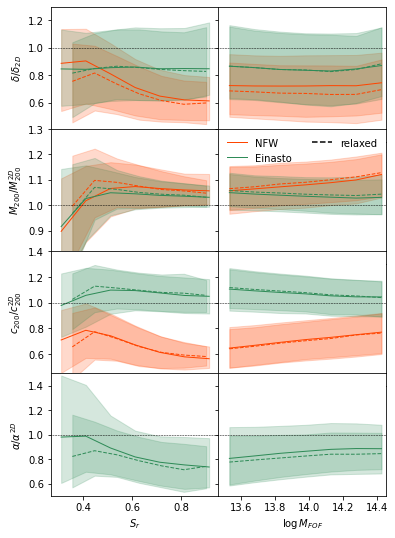

In [20]:
f, ax = plt.subplots(4,2, figsize=(6,9))
f.subplots_adjust(hspace=0,wspace=0)
msel = mfit#*(lgM > 14)*(lgM < 14.5)*(z < 0.45)*(z > 0.3)

m = msel*(sr>0.25)
make_plot2(sr[m],(resNFW_rho/resNFW_S)[m],'orangered',7,label='NFW',error=False,lw=1,plt=ax[0,0])
make_plot2(sr[m],(resEin_rho/resEin_S)[m],'seagreen',7,label='Einasto',error=False,lw=1,plt=ax[0,0])
m = msel*(lgM < 14.5)
make_plot2(lgM[m],(resNFW_rho/resNFW_S)[m],'orangered',7,label='NFW',error=False,lw=1,plt=ax[0,1])
make_plot2(lgM[m],(resEin_rho/resEin_S)[m],'seagreen',7,label='Einasto',error=False,lw=1,plt=ax[0,1])

m = msel*(sr>0.25)*mrelax
make_plot2(sr[m],(resNFW_rho/resNFW_S)[m],'orangered',7,label='NFW',error=False,lw=1,plt=ax[0,0],lt='--')
make_plot2(sr[m],(resEin_rho/resEin_S)[m],'seagreen',7,label='Einasto',error=False,lw=1,plt=ax[0,0],lt='--')
m = msel*(lgM < 14.5)*mrelax
make_plot2(lgM[m],(resNFW_rho/resNFW_S)[m],'orangered',7,label='NFW',error=False,lw=1,plt=ax[0,1],lt='--')
make_plot2(lgM[m],(resEin_rho/resEin_S)[m],'seagreen',7,label='Einasto',error=False,lw=1,plt=ax[0,1],lt='--')

m = msel*(sr>0.25)
make_plot2(sr[m],10**(lgMNFW_rho-lgMNFW_S)[m],'orangered',7,label='NFW',error=False,plt=ax[1,0])
make_plot2(sr[m],10**(lgMEin_rho-lgMEin_S)[m],'seagreen',7,label='Einasto',error=False,plt=ax[1,0])
m = msel*(lgM < 14.5)
make_plot2(lgM[m],10**(lgMNFW_rho-lgMNFW_S)[m],'orangered',7,label='NFW',error=False,plt=ax[1,1])
make_plot2(lgM[m],10**(lgMEin_rho-lgMEin_S)[m],'seagreen',7,label='Einasto',error=False,plt=ax[1,1])
ax[1,1].plot([-1,0],[-1,0],'k--',label='relaxed')
ax[1,1].legend(frameon=False,ncol=2)

m = msel*(sr>0.25)*mrelax
make_plot2(sr[m],10**(lgMNFW_rho-lgMNFW_S)[m],'orangered',7,label='NFW',error=False,lw=1,plt=ax[1,0],lt='--')
make_plot2(sr[m],10**(lgMEin_rho-lgMEin_S)[m],'seagreen',7,label='Einasto',error=False,plt=ax[1,0],lt='--')
m = msel*(lgM < 14.5)*mrelax
make_plot2(lgM[m],10**(lgMNFW_rho-lgMNFW_S)[m],'orangered',7,label='NFW',error=False,lw=1,plt=ax[1,1],lt='--')
make_plot2(lgM[m],10**(lgMEin_rho-lgMEin_S)[m],'seagreen',7,label='Einasto',error=False,plt=ax[1,1],lt='--')

m = msel*(sr>0.25)
make_plot2(sr[m],(cNFW_rho[m]/cNFW_S[m]),'orangered',7,label='NFW',error=False,lw=1,plt=ax[2,0])
make_plot2(sr[m],(cEin_rho[m]/cEin_S[m]),'seagreen',7,label='Einasto',error=False,lw=1,plt=ax[2,0])
m = msel*(lgM < 14.5)
make_plot2(lgM[m],(cNFW_rho[m]/cNFW_S[m]),'orangered',7,label='NFW',error=False,lw=1,plt=ax[2,1])
make_plot2(lgM[m],(cEin_rho[m]/cEin_S[m]),'seagreen',7,label='Einasto',error=False,lw=1,plt=ax[2,1])

m = msel*(sr>0.25)*mrelax
make_plot2(sr[m],(cNFW_rho[m]/cNFW_S[m]),'orangered',7,label='NFW',error=False,lw=1,plt=ax[2,0],lt='--')
make_plot2(sr[m],(cEin_rho[m]/cEin_S[m]),'seagreen',7,label='Einasto',error=False,lw=1,plt=ax[2,0],lt='--')
m = msel*(lgM < 14.5)*mrelax
make_plot2(lgM[m],(cNFW_rho[m]/cNFW_S[m]),'orangered',7,label='NFW',error=False,lw=1,plt=ax[2,1],lt='--')
make_plot2(lgM[m],(cEin_rho[m]/cEin_S[m]),'seagreen',7,label='Einasto',error=False,lw=1,plt=ax[2,1],lt='--')

m = msel*(sr>0.25)
make_plot2(sr[m],(alpha_rho[m]/alpha_S[m]),'seagreen',7,label='Einasto',error=False,lw=1,plt=ax[3,0])
m = msel*(lgM < 14.5)
make_plot2(lgM[m],(alpha_rho[m]/alpha_S[m]),'seagreen',7,label='Einasto',error=False,lw=1,plt=ax[3,1])

m = msel*(sr>0.25)*mrelax
make_plot2(sr[m],(alpha_rho[m]/alpha_S[m]),'seagreen',7,label='Einasto',error=False,lw=1,plt=ax[3,0],lt='--')
m = msel*(lgM < 14.5)*mrelax
make_plot2(lgM[m],(alpha_rho[m]/alpha_S[m]),'seagreen',7,label='Einasto',error=False,lw=1,plt=ax[3,1],lt='--')

ax[0,0].set_ylim([0.41,1.3])
ax[0,1].set_ylim([0.41,1.3])
ax[1,0].set_ylim([0.82,1.3])
ax[1,1].set_ylim([0.82,1.3])
ax[2,0].set_ylim([0.45,1.4])
ax[2,1].set_ylim([0.45,1.4])
ax[3,0].set_ylim([0.5,1.5])
ax[3,1].set_ylim([0.5,1.5])

for j in range(4):
    ax[j,0].plot([0,1.4],[1,1],'k--',lw=0.5)
    ax[j,1].plot([13.4,15],[1,1],'k--',lw=0.5)
    ax[j,1].set_yticklabels([])
    ax[j,0].set_xlim([0.27,0.95])
    ax[j,1].set_xlim([13.47,14.45])

ax[3,0].set_xlabel('$S_r$')
ax[3,1].set_xlabel(r'$\log M_{FOF}$')
ax[0,0].set_ylabel('$\delta/\delta_{2D}$')
ax[1,0].set_ylabel('$M_{200}/M^{2D}_{200}$')
ax[2,0].set_ylabel('$c_{200}/c^{2D}_{200}$')
ax[3,0].set_ylabel(r'$\alpha/\alpha^{2D}$')
f.savefig(plot_path+'3D2D_parameters_reduced.pdf',bbox_inches='tight')
hide_toggle()

/tmp/ipykernel_3545/3723035812.py:50: RuntimeWarning: divide by zero encountered in true_divide
  make_plot2(s[m],(alpha_rho_E[m]/alpha_S_E[m]),'seagreen',7,label='Einasto',error=False,lw=1,plt=ax[3,0])
/home/eli/miniconda3/envs/py3env2/lib/python3.9/site-packages/numpy/core/_methods.py:230: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/tmp/ipykernel_3545/3723035812.py:52: RuntimeWarning: divide by zero encountered in true_divide
  make_plot2(lgM[m],(alpha_rho_E[m]/alpha_S_E[m]),'seagreen',7,label='Einasto',error=False,lw=1,plt=ax[3,1])
/home/eli/miniconda3/envs/py3env2/lib/python3.9/site-packages/numpy/core/_methods.py:230: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


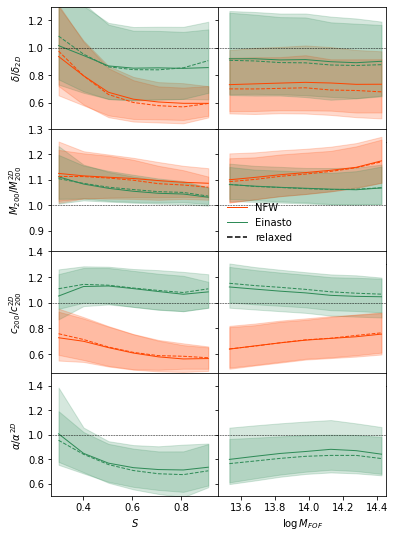

In [18]:
f, ax = plt.subplots(4,2, figsize=(6,9))
f.subplots_adjust(hspace=0,wspace=0)
msel = mfit

m = msel*(s>0.25)
make_plot2(s[m],(resNFW_rho_E/resNFW_S_E)[m],'orangered',7,label='NFW',error=False,lw=1,plt=ax[0,0])
make_plot2(s[m],(resEin_rho_E/resEin_S_E)[m],'seagreen',7,label='Einasto',error=False,lw=1,plt=ax[0,0])
m = msel*(lgM < 14.5)
make_plot2(lgM[m],(resNFW_rho_E/resNFW_S_E)[m],'orangered',7,label='NFW',error=False,lw=1,plt=ax[0,1])
make_plot2(lgM[m],(resEin_rho_E/resEin_S_E)[m],'seagreen',7,label='Einasto',error=False,lw=1,plt=ax[0,1])

m = msel*(s>0.25)*mrelax
make_plot2(s[m],(resNFW_rho_E/resNFW_S_E)[m],'orangered',7,label='NFW',error=False,lw=1,plt=ax[0,0],lt='--')
make_plot2(s[m],(resEin_rho_E/resEin_S_E)[m],'seagreen',7,label='Einasto',error=False,lw=1,plt=ax[0,0],lt='--')
m = msel*(lgM < 14.5)*mrelax
make_plot2(lgM[m],(resNFW_rho_E/resNFW_S_E)[m],'orangered',7,label='NFW',error=False,lw=1,plt=ax[0,1],lt='--')
make_plot2(lgM[m],(resEin_rho_E/resEin_S_E)[m],'seagreen',7,label='Einasto',error=False,lw=1,plt=ax[0,1],lt='--')

m = msel*(s>0.25)
make_plot2(s[m],10**(lgMNFW_rho_E-lgMNFW_S_E)[m],'orangered',7,label='NFW',error=False,plt=ax[1,0])
make_plot2(s[m],10**(lgMEin_rho_E-lgMEin_S_E)[m],'seagreen',7,label='Einasto',error=False,plt=ax[1,0])
m = msel*(lgM < 14.5)
make_plot2(lgM[m],10**(lgMNFW_rho_E-lgMNFW_S_E)[m],'orangered',7,label='NFW',error=False,plt=ax[1,1])
make_plot2(lgM[m],10**(lgMEin_rho_E-lgMEin_S_E)[m],'seagreen',7,label='Einasto',error=False,plt=ax[1,1])
ax[1,1].plot([-1,0],[-1,0],'k--',label='relaxed')
ax[1,1].legend(frameon=False)

m = msel*(s>0.25)*mrelax
make_plot2(s[m],10**(lgMNFW_rho_E-lgMNFW_S_E)[m],'orangered',7,label='NFW',error=False,lw=1,plt=ax[1,0],lt='--')
make_plot2(s[m],10**(lgMEin_rho_E-lgMEin_S_E)[m],'seagreen',7,label='Einasto',error=False,plt=ax[1,0],lt='--')
m = msel*(lgM < 14.5)*mrelax
make_plot2(lgM[m],10**(lgMNFW_rho_E-lgMNFW_S_E)[m],'orangered',7,label='NFW',error=False,lw=1,plt=ax[1,1],lt='--')
make_plot2(lgM[m],10**(lgMEin_rho_E-lgMEin_S_E)[m],'seagreen',7,label='Einasto',error=False,plt=ax[1,1],lt='--')

m = msel*(s>0.25)
make_plot2(s[m],(cNFW_rho_E[m]/cNFW_S_E[m]),'orangered',7,label='NFW',error=False,lw=1,plt=ax[2,0])
make_plot2(s[m],(cEin_rho_E[m]/cEin_S_E[m]),'seagreen',7,label='Einasto',error=False,lw=1,plt=ax[2,0])
m = msel*(lgM < 14.5)
make_plot2(lgM[m],(cNFW_rho_E[m]/cNFW_S_E[m]),'orangered',7,label='NFW',error=False,lw=1,plt=ax[2,1])
make_plot2(lgM[m],(cEin_rho_E[m]/cEin_S_E[m]),'seagreen',7,label='Einasto',error=False,lw=1,plt=ax[2,1])

m = msel*(s>0.25)*mrelax
make_plot2(s[m],(cNFW_rho_E[m]/cNFW_S_E[m]),'orangered',7,label='NFW',error=False,lw=1,plt=ax[2,0],lt='--')
make_plot2(s[m],(cEin_rho_E[m]/cEin_S_E[m]),'seagreen',7,label='Einasto',error=False,lw=1,plt=ax[2,0],lt='--')
m = msel*(lgM < 14.5)*mrelax
make_plot2(lgM[m],(cNFW_rho_E[m]/cNFW_S_E[m]),'orangered',7,label='NFW',error=False,lw=1,plt=ax[2,1],lt='--')
make_plot2(lgM[m],(cEin_rho_E[m]/cEin_S_E[m]),'seagreen',7,label='Einasto',error=False,lw=1,plt=ax[2,1],lt='--')

m = msel*(s>0.25)
make_plot2(s[m],(alpha_rho_E[m]/alpha_S_E[m]),'seagreen',7,label='Einasto',error=False,lw=1,plt=ax[3,0])
m = msel*(lgM < 14.5)
make_plot2(lgM[m],(alpha_rho_E[m]/alpha_S_E[m]),'seagreen',7,label='Einasto',error=False,lw=1,plt=ax[3,1])

m = msel*(s>0.25)*mrelax
make_plot2(s[m],(alpha_rho_E[m]/alpha_S_E[m]),'seagreen',7,label='Einasto',error=False,lw=1,plt=ax[3,0],lt='--')
m = msel*(lgM < 14.5)*mrelax
make_plot2(lgM[m],(alpha_rho_E[m]/alpha_S_E[m]),'seagreen',7,label='Einasto',error=False,lw=1,plt=ax[3,1],lt='--')

ax[0,0].set_ylim([0.41,1.3])
ax[0,1].set_ylim([0.41,1.3])
ax[1,0].set_ylim([0.82,1.3])
ax[1,1].set_ylim([0.82,1.3])
ax[2,0].set_ylim([0.45,1.4])
ax[2,1].set_ylim([0.45,1.4])
ax[3,0].set_ylim([0.5,1.5])
ax[3,1].set_ylim([0.5,1.5])

for j in range(4):
    ax[j,0].plot([0,1.4],[1,1],'k--',lw=0.5)
    ax[j,1].plot([13.4,15],[1,1],'k--',lw=0.5)
    ax[j,1].set_yticklabels([])
    ax[j,0].set_xlim([0.27,0.95])
    ax[j,1].set_xlim([13.47,14.45])

ax[3,0].set_xlabel('$S$')
ax[3,1].set_xlabel(r'$\log M_{FOF}$')
ax[0,0].set_ylabel('$\delta/\delta_{2D}$')
ax[1,0].set_ylabel('$M_{200}/M^{2D}_{200}$')
ax[2,0].set_ylabel('$c_{200}/c^{2D}_{200}$')
ax[3,0].set_ylabel(r'$\alpha/\alpha^{2D}$')
f.savefig(plot_path+'3D2D_parameters_E.pdf',bbox_inches='tight')
hide_toggle()

/tmp/ipykernel_3100/2662777961.py:42: RuntimeWarning: divide by zero encountered in true_divide
  cEin = (cEin_rho - cEin_S)/cEin_rho
/tmp/ipykernel_3100/2662777961.py:42: RuntimeWarning: invalid value encountered in true_divide
  cEin = (cEin_rho - cEin_S)/cEin_rho
/tmp/ipykernel_3100/2662777961.py:58: RuntimeWarning: divide by zero encountered in true_divide
  alpha = (alpha_rho-alpha_S)/alpha_rho
/tmp/ipykernel_3100/2662777961.py:58: RuntimeWarning: invalid value encountered in true_divide
  alpha = (alpha_rho-alpha_S)/alpha_rho


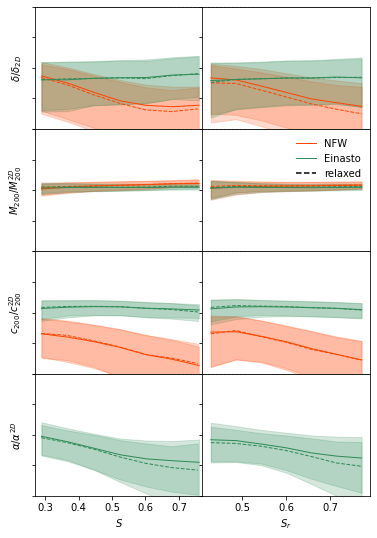

In [7]:
f, ax = plt.subplots(4,2, figsize=(6,9),sharey=True)
f.subplots_adjust(hspace=0,wspace=0)
msel = mres2

resNFW = (resNFW_rho-resNFW_S)/resNFW_rho
resEin = (resEin_rho-resEin_S)/resEin_rho

m = msel*(s<0.8)*(s>0.25)
make_plot2(s[m],resNFW[m],'orangered',7,label='NFW',error=False,lw=1,plt=ax[0,0])
make_plot2(s[m],resEin[m],'seagreen',7,label='Einasto',error=False,lw=1,plt=ax[0,0])
m = msel*(sr<0.8)*(sr>0.4)
make_plot2(sr[m],resNFW[m],'orangered',7,label='NFW',error=False,lw=1,plt=ax[0,1])
make_plot2(sr[m],resEin[m],'seagreen',7,label='Einasto',error=False,lw=1,plt=ax[0,1])

m = msel*(s<0.8)*(s>0.25)*mrelax
make_plot2(s[m],resNFW[m],'orangered',7,label='NFW',error=False,lw=1,plt=ax[0,0],lt='--')
make_plot2(s[m],resEin[m],'seagreen',7,label='Einasto',error=False,lw=1,plt=ax[0,0],lt='--')
m = msel*(sr<0.8)*(sr>0.4)*mrelax
make_plot2(sr[m],resNFW[m],'orangered',7,label='NFW',error=False,lw=1,plt=ax[0,1],lt='--')
make_plot2(sr[m],resEin[m],'seagreen',7,label='Einasto',error=False,lw=1,plt=ax[0,1],lt='--')

MNFW = (10**lgMNFW_rho - 10**lgMNFW_S)/10**lgMNFW_rho
MEin = (10**lgMEin_rho - 10**lgMEin_S)/10**lgMEin_rho

m = msel*(s<0.8)*(s>0.25)
make_plot2(s[m],MNFW[m],'orangered',7,label='NFW',error=False,plt=ax[1,0])
make_plot2(s[m],MEin[m],'seagreen',7,label='Einasto',error=False,plt=ax[1,0])
m = msel*(sr<0.8)*(sr>0.4)
make_plot2(sr[m],MNFW[m],'orangered',7,label='NFW',error=False,plt=ax[1,1])
make_plot2(sr[m],MEin[m],'seagreen',7,label='Einasto',error=False,plt=ax[1,1])
ax[1,1].plot([-1,0],[-1,0],'k--',label='relaxed')
ax[1,1].legend(frameon=False)

m = msel*(s<0.8)*(s>0.25)*mrelax
make_plot2(s[m],MNFW[m],'orangered',7,label='NFW',error=False,lw=1,plt=ax[1,0],lt='--')
make_plot2(s[m],MEin[m],'seagreen',7,label='Einasto',error=False,plt=ax[1,0],lt='--')
m = msel*(sr<0.8)*(sr>0.4)*mrelax
make_plot2(sr[m],MNFW[m],'orangered',7,label='NFW',error=False,lw=1,plt=ax[1,1],lt='--')
make_plot2(sr[m],MEin[m],'seagreen',7,label='Einasto',error=False,plt=ax[1,1],lt='--')

cNFW = (cNFW_rho - cNFW_S)/cNFW_rho
cEin = (cEin_rho - cEin_S)/cEin_rho

m = msel*(s<0.8)*(s>0.25)
make_plot2(s[m],cNFW[m],'orangered',7,label='NFW',error=False,lw=1,plt=ax[2,0])
make_plot2(s[m],cEin[m],'seagreen',7,label='Einasto',error=False,lw=1,plt=ax[2,0])
m = msel*(sr<0.8)*(sr>0.4)
make_plot2(sr[m],cNFW[m],'orangered',7,label='NFW',error=False,lw=1,plt=ax[2,1])
make_plot2(sr[m],cEin[m],'seagreen',7,label='Einasto',error=False,lw=1,plt=ax[2,1])

m = msel*(s<0.8)*(s>0.25)*mrelax
make_plot2(s[m],cNFW[m],'orangered',7,label='NFW',error=False,lw=1,plt=ax[2,0],lt='--')
make_plot2(s[m],cEin[m],'seagreen',7,label='Einasto',error=False,lw=1,plt=ax[2,0],lt='--')
m = msel*(sr<0.8)*(sr>0.4)*mrelax
make_plot2(sr[m],cNFW[m],'orangered',7,label='NFW',error=False,lw=1,plt=ax[2,1],lt='--')
make_plot2(sr[m],cEin[m],'seagreen',7,label='Einasto',error=False,lw=1,plt=ax[2,1],lt='--')

alpha = (alpha_rho-alpha_S)/alpha_rho
m = msel*(s<0.8)*(s>0.25)
make_plot2(s[m],alpha[m],'seagreen',7,label='Einasto',error=False,lw=1,plt=ax[3,0])
m = msel*(sr<0.8)*(sr>0.4)
make_plot2(sr[m],alpha[m],'seagreen',7,label='Einasto',error=False,lw=1,plt=ax[3,1])

m = msel*(s<0.8)*(s>0.25)*mrelax
make_plot2(s[m],alpha[m],'seagreen',7,label='Einasto',error=False,lw=1,plt=ax[3,0],lt='--')
m = msel*(sr<0.8)*(sr>0.4)*mrelax
make_plot2(sr[m],alpha[m],'seagreen',7,label='Einasto',error=False,lw=1,plt=ax[3,1],lt='--')

#ax[0,0].set_ylim([0.2,1.3])
#ax[0,1].set_ylim([0.2,1.3])
#ax[1,0].set_ylim([0.82,1.3])
#ax[1,1].set_ylim([0.82,1.3])
#ax[2,0].set_ylim([0.45,1.4])
#ax[2,1].set_ylim([0.45,1.4])
#ax[3,0].set_ylim([0.5,1.5])
#ax[3,1].set_ylim([0.5,1.5])

ax[3,1].set_ylim([-1,1])

for j in range(4):
    ax[j,0].plot([0,1.4],[1,1],'k--',lw=0.5)
    ax[j,1].plot([0,1.4],[1,1],'k--',lw=0.5)
    ax[j,1].set_yticklabels([])
    ax[j,0].set_xlim([0.27,0.77])
    ax[j,1].set_xlim([0.41,0.79])

ax[3,0].set_xlabel('$S$')
ax[3,1].set_xlabel(r'$S_r$')
ax[0,0].set_ylabel('$\delta/\delta_{2D}$')
ax[1,0].set_ylabel('$M_{200}/M^{2D}_{200}$')
ax[2,0].set_ylabel('$c_{200}/c^{2D}_{200}$')
ax[3,0].set_ylabel(r'$\alpha/\alpha^{2D}$')
f.savefig(plot_path+'3D2D_parameters_ratio.pdf',bbox_inches='tight')
hide_toggle()

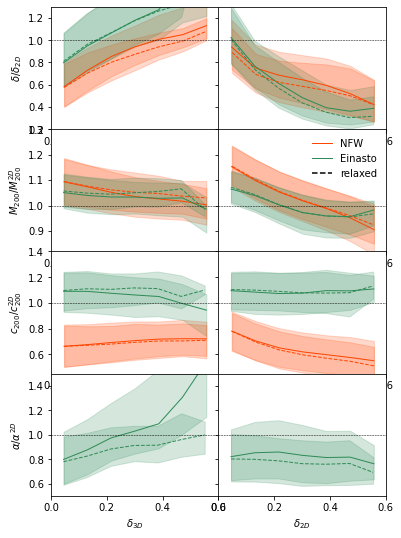

In [6]:
f, ax = plt.subplots(4,2, figsize=(6,9))
f.subplots_adjust(hspace=0,wspace=0)
msel = mfit*(resNFW_rho < 0.6)*(resEin_rho < 0.6)*(resNFW_S < 0.6)*(resEin_S < 0.6)

m = msel
make_plot2(resNFW_rho[m],(resNFW_rho/resNFW_S)[m],'orangered',7,label='NFW',error=False,lw=1,plt=ax[0,0])
make_plot2(resEin_rho[m],(resEin_rho/resEin_S)[m],'seagreen',7,label='Einasto',error=False,lw=1,plt=ax[0,0])
m = msel*(sr<0.8)*(sr>0.4)
make_plot2(resNFW_S[m],(resNFW_rho/resNFW_S)[m],'orangered',7,label='NFW',error=False,lw=1,plt=ax[0,1])
make_plot2(resEin_S[m],(resEin_rho/resEin_S)[m],'seagreen',7,label='Einasto',error=False,lw=1,plt=ax[0,1])

m = msel*mrelax
make_plot2(resNFW_rho[m],(resNFW_rho/resNFW_S)[m],'orangered',7,label='NFW',error=False,lw=1,plt=ax[0,0],lt='--')
make_plot2(resEin_rho[m],(resEin_rho/resEin_S)[m],'seagreen',7,label='Einasto',error=False,lw=1,plt=ax[0,0],lt='--')
m = msel*mrelax
make_plot2(resNFW_S[m],(resNFW_rho/resNFW_S)[m],'orangered',7,label='NFW',error=False,lw=1,plt=ax[0,1],lt='--')
make_plot2(resEin_S[m],(resEin_rho/resEin_S)[m],'seagreen',7,label='Einasto',error=False,lw=1,plt=ax[0,1],lt='--')

m = msel
make_plot2(resNFW_rho[m],10**(lgMNFW_rho-lgMNFW_S)[m],'orangered',7,label='NFW',error=False,plt=ax[1,0])
make_plot2(resEin_rho[m],10**(lgMEin_rho-lgMEin_S)[m],'seagreen',7,label='Einasto',error=False,plt=ax[1,0])
m = msel
make_plot2(resNFW_S[m],10**(lgMNFW_rho-lgMNFW_S)[m],'orangered',7,label='NFW',error=False,plt=ax[1,1])
make_plot2(resEin_S[m],10**(lgMEin_rho-lgMEin_S)[m],'seagreen',7,label='Einasto',error=False,plt=ax[1,1])
ax[1,1].plot([-1,0],[-1,0],'k--',label='relaxed')
ax[1,1].legend(frameon=False)

m = msel*mrelax
make_plot2(resNFW_rho[m],10**(lgMNFW_rho-lgMNFW_S)[m],'orangered',7,label='NFW',error=False,lw=1,plt=ax[1,0],lt='--')
make_plot2(resEin_rho[m],10**(lgMEin_rho-lgMEin_S)[m],'seagreen',7,label='Einasto',error=False,plt=ax[1,0],lt='--')
m = msel*mrelax
make_plot2(resNFW_S[m],10**(lgMNFW_rho-lgMNFW_S)[m],'orangered',7,label='NFW',error=False,lw=1,plt=ax[1,1],lt='--')
make_plot2(resEin_S[m],10**(lgMEin_rho-lgMEin_S)[m],'seagreen',7,label='Einasto',error=False,plt=ax[1,1],lt='--')

m = msel
make_plot2(resNFW_rho[m],(cNFW_rho[m]/cNFW_S[m]),'orangered',7,label='NFW',error=False,lw=1,plt=ax[2,0])
make_plot2(resEin_rho[m],(cEin_rho[m]/cEin_S[m]),'seagreen',7,label='Einasto',error=False,lw=1,plt=ax[2,0])
m = msel
make_plot2(resNFW_S[m],(cNFW_rho[m]/cNFW_S[m]),'orangered',7,label='NFW',error=False,lw=1,plt=ax[2,1])
make_plot2(resEin_S[m],(cEin_rho[m]/cEin_S[m]),'seagreen',7,label='Einasto',error=False,lw=1,plt=ax[2,1])

m = msel*mrelax
make_plot2(resNFW_rho[m],(cNFW_rho[m]/cNFW_S[m]),'orangered',7,label='NFW',error=False,lw=1,plt=ax[2,0],lt='--')
make_plot2(resEin_rho[m],(cEin_rho[m]/cEin_S[m]),'seagreen',7,label='Einasto',error=False,lw=1,plt=ax[2,0],lt='--')
m = msel*mrelax
make_plot2(resNFW_S[m],(cNFW_rho[m]/cNFW_S[m]),'orangered',7,label='NFW',error=False,lw=1,plt=ax[2,1],lt='--')
make_plot2(resEin_S[m],(cEin_rho[m]/cEin_S[m]),'seagreen',7,label='Einasto',error=False,lw=1,plt=ax[2,1],lt='--')

m = msel
make_plot2(resEin_rho[m],(alpha_rho[m]/alpha_S[m]),'seagreen',7,label='Einasto',error=False,lw=1,plt=ax[3,0])
m = msel
make_plot2(resEin_S[m],(alpha_rho[m]/alpha_S[m]),'seagreen',7,label='Einasto',error=False,lw=1,plt=ax[3,1])

m = msel*mrelax
make_plot2(resEin_rho[m],(alpha_rho[m]/alpha_S[m]),'seagreen',7,label='Einasto',error=False,lw=1,plt=ax[3,0],lt='--')
m = msel*mrelax
make_plot2(resEin_S[m],(alpha_rho[m]/alpha_S[m]),'seagreen',7,label='Einasto',error=False,lw=1,plt=ax[3,1],lt='--')

ax[0,0].set_ylim([0.2,1.3])
ax[0,1].set_ylim([0.2,1.3])
ax[1,0].set_ylim([0.82,1.3])
ax[1,1].set_ylim([0.82,1.3])
ax[2,0].set_ylim([0.45,1.4])
ax[2,1].set_ylim([0.45,1.4])
ax[3,0].set_ylim([0.5,1.5])
ax[3,1].set_ylim([0.5,1.5])

for j in range(4):
    ax[j,0].plot([0,1.4],[1,1],'k--',lw=0.5)
    ax[j,1].plot([0,1.4],[1,1],'k--',lw=0.5)
    ax[j,1].set_yticklabels([])
    ax[j,0].set_xlim([0.,0.6])
    ax[j,1].set_xlim([0.,0.6])

ax[3,0].set_xlabel('$\delta_{3D}$')
ax[3,1].set_xlabel(r'$\delta_{2D}$')
ax[0,0].set_ylabel('$\delta/\delta_{2D}$')
ax[1,0].set_ylabel('$M_{200}/M^{2D}_{200}$')
ax[2,0].set_ylabel('$c_{200}/c^{2D}_{200}$')
ax[3,0].set_ylabel(r'$\alpha/\alpha^{2D}$')
f.savefig(plot_path+'3D2D_parameters_res.pdf',bbox_inches='tight')
hide_toggle()

## Analysis of fitted profile parameters 

### Variation of concentration with mass and redshift

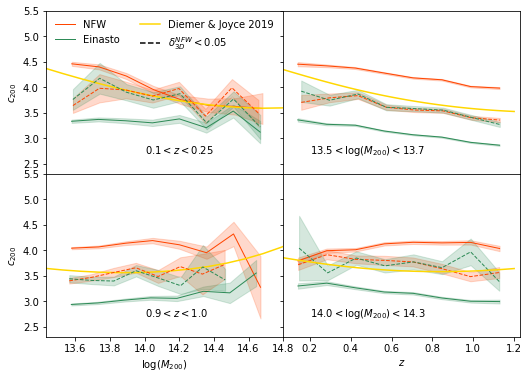

In [41]:
f, ax = plt.subplots(2,2, figsize=(8.5,6),sharey=True)
f.subplots_adjust(hspace=0,wspace=0)
#cmodel = 'bullock01'
#cmodel = 'ludlow16'
cmodel = 'diemer19'
#cmodel = 'prada12'
#cmodel = 'ishiyama21'
#cmodel = 'dutton14'
#cmodel = 'duffy08'
#cmodel = 'child18'
lM200 = np.linspace(13,15,20)

msel = mfit*mrelax

m = msel*(cNFW_rho > 0)*(cNFW_rho < 10)*(z > 0.1)*(z < 0.25)*(lgMNFW_rho > 13.5)*(lgMNFW_rho < 14.8)
make_plot2(lgMNFW_rho[m],cNFW_rho[m],'orangered',8,label='NFW',error=True,lw=1,plt=ax[0,0])
m = msel*(cEin_rho> 0)*(cEin_rho < 10)*(z > 0.1)*(z < 0.25)*(lgMEin_rho > 13.5)*(lgMEin_rho < 14.8)
make_plot2(lgMEin_rho[m],cEin_rho[m],'seagreen',8,label='Einasto',error=True,lw=1,plt=ax[0,0])
ax[0,0].plot(lM200,concentration.concentration(10**lM200, '200c', np.median(z[m]), model = cmodel),'gold')
ax[0,0].plot([-1,-1],[-1,-1],'gold',label='Diemer & Joyce 2019')
ax[0,0].plot([-1,-1],[-1,-1],'k--',label=r'$\delta^{NFW}_{3D} < 0.05$')
ax[0,0].legend(loc=2,frameon=False,ncol=2)

m = msel*(cNFW_rho > 0)*(cNFW_rho < 10)*(z > 0.1)*(z < 0.25)*(lgMNFW_rho > 13.5)*(lgMNFW_rho < 14.8)*(resNFW_rho < 0.05)
make_plot2(lgMNFW_rho[m],cNFW_rho[m],'orangered',8,label='NFW',error=True,lw=1,plt=ax[0,0],lt='--')
m = msel*(cEin_rho> 0)*(cEin_rho < 10)*(z > 0.1)*(z < 0.25)*(lgMEin_rho > 13.5)*(lgMNFW_rho < 14.8)*(resNFW_rho < 0.05)
make_plot2(lgMEin_rho[m],cEin_rho[m],'seagreen',8,label='Einasto',error=True,lw=1,plt=ax[0,0],lt='--')

ax[0,0].set_ylabel(r'$c_{200}$')
ax[1,0].set_ylabel(r'$c_{200}$')
ax[0,0].set_xlim([13.43,14.8])
ax[1,0].set_xlim([13.43,14.8])
ax[0,0].set_ylim([2.3,5.5])

m = msel*(cNFW_rho > 0)*(cNFW_rho < 10)*(z > 0.9)*(z < 1)*(lgMNFW_rho > 13.5)*(lgMNFW_rho < 14.8)
make_plot2(lgMNFW_rho[m],cNFW_rho[m],'orangered',8,label='NFW',error=True,lw=1,plt=ax[1,0])
ax[1,0].plot(lM200,concentration.concentration(10**lM200, '200c', np.median(z[m]), model = cmodel),'gold')
m = mres2*(cEin_rho> 0)*(cEin_rho < 10)*(z > 0.9)*(z < 1)*(lgMEin_rho > 13.5)*(lgMNFW_rho < 14.8)
make_plot2(lgMEin_rho[m],cEin_rho[m],'seagreen',8,label='Einasto',error=True,lw=1,plt=ax[1,0])

m = msel*(cNFW_rho > 0)*(cNFW_rho < 10)*(z > 0.9)*(z < 1)*(lgMNFW_rho > 13.5)*(lgMNFW_rho < 14.8)*(resNFW_rho < 0.05)
make_plot2(lgMNFW_rho[m],cNFW_rho[m],'orangered',8,label='NFW',error=True,lw=1,plt=ax[1,0],lt='--')
m = msel*(cEin_rho> 0)*(cEin_rho < 10)*(z > 0.9)*(z < 1)*(lgMEin_rho > 13.5)*(lgMNFW_rho < 14.8)*(resNFW_rho < 0.05)
make_plot2(lgMEin_rho[m],cEin_rho[m],'seagreen',8,label='Einasto',error=True,lw=1,plt=ax[1,0],lt='--')

ax[1,0].set_xlabel(r'$\log (M_{200})$')

ax[0,0].text(14.,2.7,'$0.1 < z < 0.25$')
ax[1,0].text(14.,2.7,'$0.9 < z < 1.0$')

m = msel*(cNFW_rho > 0)*(cNFW_rho < 10)*(z > 0.07)*(z < 1.2)*(lgMNFW_rho > 13.5)*(lgMNFW_rho < 13.7)
make_plot2(z[m],cNFW_rho[m],'orangered',8,label='NFW',error=True,lw=1,plt=ax[0,1])
m = msel*(cEin_rho> 0)*(cEin_rho < 10)*(z > 0.07)*(z < 1.2)*(lgMEin_rho > 13.5)*(lgMEin_rho < 13.7)
make_plot2(z[m],cEin_rho[m],'seagreen',8,label='Einasto',error=True,lw=1,plt=ax[0,1])

m = msel*(cNFW_rho > 0)*(cNFW_rho < 10)*(z > 0.07)*(z < 1.2)*(lgMNFW_rho > 13.5)*(lgMNFW_rho < 13.7)*(resNFW_rho < 0.05)
m1 = m
make_plot2(z[m],cNFW_rho[m],'orangered',8,label='NFW',error=True,lw=1,plt=ax[0,1],lt='--')
m = msel*(cEin_rho> 0)*(cEin_rho < 10)*(z > 0.07)*(z < 1.2)*(lgMEin_rho > 13.5)*(lgMEin_rho < 13.7)*(resNFW_rho < 0.05)
make_plot2(z[m],cEin_rho[m],'seagreen',8,label='Einasto',error=True,lw=1,plt=ax[0,1],lt='--')

m = msel*(cNFW_rho > 0)*(cNFW_rho < 10)*(z > 0.07)*(z < 1.2)*(lgMNFW_rho > 14)*(lgMNFW_rho < 14.3)
make_plot2(z[m],cNFW_rho[m],'orangered',8,label='NFW',error=True,lw=1,plt=ax[1,1])
m = msel*(cEin_rho> 0)*(cEin_rho < 10)*(z > 0.07)*(z < 1.2)*(lgMEin_rho > 14)*(lgMEin_rho < 14.3)
make_plot2(z[m],cEin_rho[m],'seagreen',8,label='Einasto',error=True,lw=1,plt=ax[1,1])

m = msel*(cNFW_rho > 0)*(cNFW_rho < 10)*(z > 0.07)*(z < 1.2)*(lgMNFW_rho > 14)*(lgMNFW_rho < 14.3)*(resNFW_rho < 0.05)
m2 = m
make_plot2(z[m],cNFW_rho[m],'orangered',8,label='NFW',error=True,lw=1,plt=ax[1,1],lt='--')
m = mres2*(cEin_rho> 0)*(cEin_rho < 10)*(z > 0.07)*(z < 1.2)*(lgMEin_rho > 14)*(lgMEin_rho < 14.3)*(resNFW_rho < 0.05)
make_plot2(z[m],cEin_rho[m],'seagreen',8,label='Einasto',error=True,lw=1,plt=ax[1,1],lt='--')

cmodel1 = np.array([])
cmodel2 = np.array([])
for j in np.linspace(0.07,1.2,50):
    cmodel1 = np.append(cmodel1,concentration.concentration(10**np.median(lgMNFW_rho[m1]), '200c', j, model = cmodel))
    cmodel2 = np.append(cmodel2,concentration.concentration(10**np.median(lgMNFW_rho[m2]), '200c', j, model = cmodel))
ax[0,1].plot(np.linspace(0.07,1.2,50),cmodel1, 'gold')
ax[1,1].plot(np.linspace(0.07,1.2,50),cmodel2, 'gold')

ax[0,1].set_xlim([0.07,1.23])
ax[1,1].set_xlim([0.07,1.23])
ax[1,1].set_xlabel(r'$z$')

ax[0,1].text(0.2,2.7,'$13.5 < \log(M_{200}) < 13.7$')
ax[1,1].text(0.2,2.7,'$14.0 < \log(M_{200}) < 14.3$')

f.savefig(plot_path+'concentration.pdf',bbox_inches='tight')
hide_toggle()

/tmp/ipykernel_3100/4022759638.py:49: RuntimeWarning: invalid value encountered in true_divide
  return x_b,q50,q25,q75,mz,ymean,sigma/np.sqrt(N)


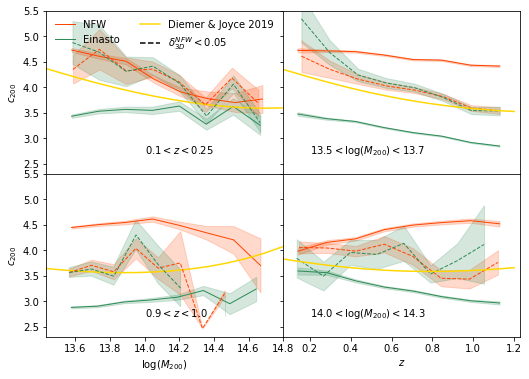

In [61]:
f, ax = plt.subplots(2,2, figsize=(8.5,6),sharey=True)
f.subplots_adjust(hspace=0,wspace=0)
#cmodel = 'bullock01'
#cmodel = 'ludlow16'
cmodel = 'diemer19'
#cmodel = 'prada12'
#cmodel = 'ishiyama21'
#cmodel = 'dutton14'
#cmodel = 'duffy08'
#cmodel = 'child18'
lM200 = np.linspace(13,15,20)

msel = mfit*mrelax

m = msel*(cNFW_rho_E > 0)*(cNFW_rho_E < 10)*(z > 0.1)*(z < 0.25)*(lgMNFW_rho > 13.5)*(lgMNFW_rho < 14.8)
make_plot2(lgMNFW_rho[m],cNFW_rho_E[m],'orangered',8,label='NFW',error=True,lw=1,plt=ax[0,0])
m = msel*(cEin_rho_E> 0)*(cEin_rho_E < 10)*(z > 0.1)*(z < 0.25)*(lgMEin_rho > 13.5)*(lgMEin_rho < 14.8)
make_plot2(lgMEin_rho[m],cEin_rho_E[m],'seagreen',8,label='Einasto',error=True,lw=1,plt=ax[0,0])
ax[0,0].plot(lM200,concentration.concentration(10**lM200, '200c', np.median(z[m]), model = cmodel),'gold')
ax[0,0].plot([-1,-1],[-1,-1],'gold',label='Diemer & Joyce 2019')
ax[0,0].plot([-1,-1],[-1,-1],'k--',label=r'$\delta^{NFW}_{3D} < 0.05$')
ax[0,0].legend(loc=2,frameon=False,ncol=2)

m = msel*(cNFW_rho_E > 0)*(cNFW_rho_E < 10)*(z > 0.1)*(z < 0.25)*(lgMNFW_rho > 13.5)*(lgMNFW_rho < 14.8)*(resNFW_rho_E < 0.05)
make_plot2(lgMNFW_rho[m],cNFW_rho_E[m],'orangered',8,label='NFW',error=True,lw=1,plt=ax[0,0],lt='--')
m = msel*(cEin_rho_E> 0)*(cEin_rho_E < 10)*(z > 0.1)*(z < 0.25)*(lgMEin_rho > 13.5)*(lgMNFW_rho < 14.8)*(resNFW_rho_E < 0.05)
make_plot2(lgMEin_rho[m],cEin_rho_E[m],'seagreen',8,label='Einasto',error=True,lw=1,plt=ax[0,0],lt='--')

ax[0,0].set_ylabel(r'$c_{200}$')
ax[1,0].set_ylabel(r'$c_{200}$')
ax[0,0].set_xlim([13.43,14.8])
ax[1,0].set_xlim([13.43,14.8])
ax[0,0].set_ylim([2.3,5.5])

m = msel*(cNFW_rho_E > 0)*(cNFW_rho_E < 10)*(z > 0.9)*(z < 1)*(lgMNFW_rho > 13.5)*(lgMNFW_rho < 14.8)
make_plot2(lgMNFW_rho[m],cNFW_rho_E[m],'orangered',8,label='NFW',error=True,lw=1,plt=ax[1,0])
ax[1,0].plot(lM200,concentration.concentration(10**lM200, '200c', np.median(z[m]), model = cmodel),'gold')
m = mres2*(cEin_rho_E> 0)*(cEin_rho_E < 10)*(z > 0.9)*(z < 1)*(lgMEin_rho > 13.5)*(lgMNFW_rho < 14.8)
make_plot2(lgMEin_rho[m],cEin_rho_E[m],'seagreen',8,label='Einasto',error=True,lw=1,plt=ax[1,0])

m = msel*(cNFW_rho_E > 0)*(cNFW_rho_E < 10)*(z > 0.9)*(z < 1)*(lgMNFW_rho > 13.5)*(lgMNFW_rho < 14.8)*(resNFW_rho_E < 0.05)
make_plot2(lgMNFW_rho[m],cNFW_rho_E[m],'orangered',8,label='NFW',error=True,lw=1,plt=ax[1,0],lt='--')
m = msel*(cEin_rho_E> 0)*(cEin_rho_E < 10)*(z > 0.9)*(z < 1)*(lgMEin_rho > 13.5)*(lgMNFW_rho < 14.8)*(resNFW_rho_E < 0.05)
make_plot2(lgMEin_rho[m],cEin_rho_E[m],'seagreen',8,label='Einasto',error=True,lw=1,plt=ax[1,0],lt='--')

ax[1,0].set_xlabel(r'$\log (M_{200})$')

ax[0,0].text(14.,2.7,'$0.1 < z < 0.25$')
ax[1,0].text(14.,2.7,'$0.9 < z < 1.0$')

m = msel*(cNFW_rho_E > 0)*(cNFW_rho_E < 10)*(z > 0.07)*(z < 1.2)*(lgMNFW_rho > 13.5)*(lgMNFW_rho < 13.7)
make_plot2(z[m],cNFW_rho_E[m],'orangered',8,label='NFW',error=True,lw=1,plt=ax[0,1])
m = msel*(cEin_rho_E> 0)*(cEin_rho_E < 10)*(z > 0.07)*(z < 1.2)*(lgMEin_rho > 13.5)*(lgMEin_rho < 13.7)
make_plot2(z[m],cEin_rho_E[m],'seagreen',8,label='Einasto',error=True,lw=1,plt=ax[0,1])

m = msel*(cNFW_rho_E > 0)*(cNFW_rho_E < 10)*(z > 0.07)*(z < 1.2)*(lgMNFW_rho > 13.5)*(lgMNFW_rho < 13.7)*(resNFW_rho_E < 0.05)
m1 = m
make_plot2(z[m],cNFW_rho_E[m],'orangered',8,label='NFW',error=True,lw=1,plt=ax[0,1],lt='--')
m = msel*(cEin_rho_E> 0)*(cEin_rho_E < 10)*(z > 0.07)*(z < 1.2)*(lgMEin_rho > 13.5)*(lgMEin_rho < 13.7)*(resNFW_rho_E < 0.05)
make_plot2(z[m],cEin_rho_E[m],'seagreen',8,label='Einasto',error=True,lw=1,plt=ax[0,1],lt='--')

m = msel*(cNFW_rho_E > 0)*(cNFW_rho_E < 10)*(z > 0.07)*(z < 1.2)*(lgMNFW_rho > 14)*(lgMNFW_rho < 14.3)
make_plot2(z[m],cNFW_rho_E[m],'orangered',8,label='NFW',error=True,lw=1,plt=ax[1,1])
m = msel*(cEin_rho_E> 0)*(cEin_rho_E < 10)*(z > 0.07)*(z < 1.2)*(lgMEin_rho > 14)*(lgMEin_rho < 14.3)
make_plot2(z[m],cEin_rho_E[m],'seagreen',8,label='Einasto',error=True,lw=1,plt=ax[1,1])

m = msel*(cNFW_rho_E > 0)*(cNFW_rho_E < 10)*(z > 0.07)*(z < 1.2)*(lgMNFW_rho > 14)*(lgMNFW_rho < 14.3)*(resNFW_rho_E < 0.05)
m2 = m
make_plot2(z[m],cNFW_rho_E[m],'orangered',8,label='NFW',error=True,lw=1,plt=ax[1,1],lt='--')
m = mres2*(cEin_rho_E> 0)*(cEin_rho_E < 10)*(z > 0.07)*(z < 1.2)*(lgMEin_rho > 14)*(lgMEin_rho < 14.3)*(resNFW_rho_E < 0.05)
make_plot2(z[m],cEin_rho_E[m],'seagreen',8,label='Einasto',error=True,lw=1,plt=ax[1,1],lt='--')

cmodel1 = np.array([])
cmodel2 = np.array([])
for j in np.linspace(0.07,1.2,50):
    cmodel1 = np.append(cmodel1,concentration.concentration(10**np.median(lgMNFW_rho[m1]), '200c', j, model = cmodel))
    cmodel2 = np.append(cmodel2,concentration.concentration(10**np.median(lgMNFW_rho[m2]), '200c', j, model = cmodel))
ax[0,1].plot(np.linspace(0.07,1.2,50),cmodel1, 'gold')
ax[1,1].plot(np.linspace(0.07,1.2,50),cmodel2, 'gold')

ax[0,1].set_xlim([0.07,1.23])
ax[1,1].set_xlim([0.07,1.23])
ax[1,1].set_xlabel(r'$z$')

ax[0,1].text(0.2,2.7,'$13.5 < \log(M_{200}) < 13.7$')
ax[1,1].text(0.2,2.7,'$14.0 < \log(M_{200}) < 14.3$')

f.savefig(plot_path+'concentration_E.pdf',bbox_inches='tight')
hide_toggle()

### Variation of concentration with halo shape

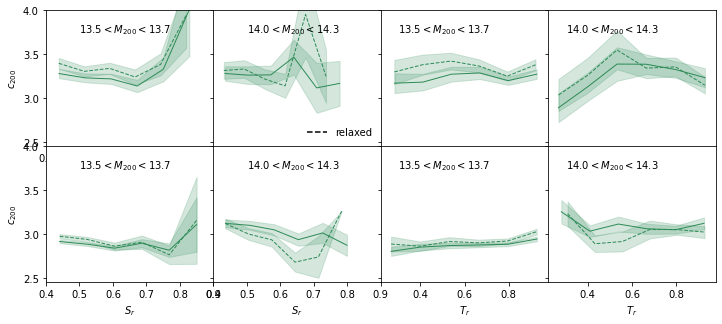

In [55]:
f, ax = plt.subplots(2,4, figsize=(12,5),sharey=True)
f.subplots_adjust(hspace=0,wspace=0)

ax[0,1].plot([-1,-1],[0,-1],'k--',label='relaxed')
ax[0,1].legend(loc=4,frameon=False,ncol=2)

msel = mfit*(s<0.9)*(s>0.4)*(T > 0.2)
mres = mrelax
#m = msel*(cNFW_rho > 0)*(cNFW_rho < 10)*(z > 0.1)*(z < 0.25)*(lgMNFW_rho > 13.5)*(lgMNFW_rho < 13.7)
#make_plot2(s[m],cNFW_rho[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[0,0])
m = msel*(cEin_rho> 0)*(cEin_rho < 10)*(z > 0.1)*(z < 0.25)*(lgMEin_rho > 13.5)*(lgMEin_rho < 13.7)
make_plot2(s[m],cEin_rho[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[0,0])

#m = msel*(cNFW_rho > 0)*(cNFW_rho < 10)*(z > 0.1)*(z < 0.25)*(lgMNFW_rho > 13.5)*(lgMNFW_rho < 13.7)*mres
#make_plot2(s[m],cNFW_rho[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[0,0],lt='--')
m = msel*(cEin_rho> 0)*(cEin_rho < 10)*(z > 0.1)*(z < 0.25)*(lgMEin_rho > 13.5)*(lgMEin_rho < 13.7)*mres
make_plot2(s[m],cEin_rho[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[0,0],lt='--')

ax[0,0].set_ylabel(r'$c_{200}$')
ax[1,0].set_ylabel(r'$c_{200}$')

#m = msel*(cNFW_rho > 0)*(cNFW_rho < 10)*(z > 0.9)*(z < 1)*(lgMNFW_rho > 13.5)*(lgMNFW_rho < 13.7)
#make_plot2(s[m],cNFW_rho[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[1,0])
m = msel*(cEin_rho> 0)*(cEin_rho < 10)*(z > 0.9)*(z < 1)*(lgMEin_rho > 13.5)*(lgMEin_rho < 13.7)
make_plot2(s[m],cEin_rho[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[1,0])

#m = msel*(cNFW_rho > 0)*(cNFW_rho < 10)*(z > 0.9)*(z < 1)*(lgMNFW_rho > 13.5)*(lgMNFW_rho < 13.7)*mres
#make_plot2(s[m],cNFW_rho[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[1,0],lt='--')
m = msel*(cEin_rho> 0)*(cEin_rho < 10)*(z > 0.9)*(z < 1)*(lgMEin_rho > 13.5)*(lgMEin_rho < 13.7)*mres
make_plot2(s[m],cEin_rho[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[1,0],lt='--')

ax[1,0].set_xlabel(r'$S_r$')

ax[0,0].text(0.5,3.75,'$13.5 < M_{200} < 13.7$')
ax[1,0].text(0.5,3.75,'$13.5 < M_{200} < 13.7$')
ax[0,1].text(0.5,3.75,'$14.0 < M_{200} < 14.3$')
ax[1,1].text(0.5,3.75,'$14.0 < M_{200} < 14.3$')

#m = msel*(cNFW_rho > 0)*(cNFW_rho < 10)*(z > 0.1)*(z < 0.25)*(lgMNFW_rho > 14)*(lgMNFW_rho < 14.3)
#make_plot2(s[m],cNFW_rho[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[0,1])
m = msel*(cEin_rho> 0)*(cEin_rho < 10)*(z > 0.1)*(z < 0.25)*(lgMEin_rho > 14)*(lgMEin_rho < 14.3)
make_plot2(s[m],cEin_rho[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[0,1])

#m = msel*(cNFW_rho > 0)*(cNFW_rho < 10)*(z > 0.1)*(z < 0.25)*(lgMNFW_rho > 14)*(lgMNFW_rho < 14.3)*mres
#make_plot2(s[m],cNFW_rho[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[0,1],lt='--')
m = msel*(cEin_rho> 0)*(cEin_rho < 10)*(z > 0.1)*(z < 0.25)*(lgMEin_rho > 14)*(lgMEin_rho < 14.3)*mres
make_plot2(s[m],cEin_rho[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[0,1],lt='--')

#m = msel*(cNFW_rho > 0)*(cNFW_rho < 10)*(z > 0.9)*(z < 1.)*(lgMNFW_rho > 14)*(lgMNFW_rho < 14.3)
#make_plot2(s[m],cNFW_rho[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[1,1])
m = msel*(cEin_rho> 0)*(cEin_rho < 10)*(z > 0.9)*(z < 1.)*(lgMEin_rho > 14)*(lgMEin_rho < 14.3)
make_plot2(s[m],cEin_rho[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[1,1])
#m = msel*(cNFW_rho > 0)*(cNFW_rho < 10)*(z > 0.9)*(z < 1.)*(lgMNFW_rho > 14)*(lgMNFW_rho < 14.3)*mres
#make_plot2(s[m],cNFW_rho[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[1,1],lt='--')
m = msel*(cEin_rho> 0)*(cEin_rho < 10)*(z > 0.9)*(z < 1.)*(lgMEin_rho > 14)*(lgMEin_rho < 14.3)*mres
make_plot2(s[m],cEin_rho[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[1,1],lt='--')

ax[1,1].set_xlabel(r'$S_r$')

#m = msel*(cNFW_rho > 0)*(cNFW_rho < 10)*(z > 0.1)*(z < 0.25)*(lgMNFW_rho > 13.5)*(lgMNFW_rho < 13.7)
#make_plot2(T[m],cNFW_rho[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[0,2])
m = msel*(cEin_rho> 0)*(cEin_rho < 10)*(z > 0.1)*(z < 0.25)*(lgMEin_rho > 13.5)*(lgMEin_rho < 13.7)
make_plot2(T[m],cEin_rho[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[0,2])
#m = msel*(cNFW_rho > 0)*(cNFW_rho < 10)*(z > 0.1)*(z < 0.25)*(lgMNFW_rho > 13.5)*(lgMNFW_rho < 13.7)*mres
#make_plot2(T[m],cNFW_rho[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[0,2],lt='--')
m = msel*(cEin_rho> 0)*(cEin_rho < 10)*(z > 0.1)*(z < 0.25)*(lgMEin_rho > 13.5)*(lgMEin_rho < 13.7)*mres
make_plot2(T[m],cEin_rho[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[0,2],lt='--')

#m = msel*(cNFW_rho > 0)*(cNFW_rho < 10)*(z > 0.9)*(z < 1)*(lgMNFW_rho > 13.5)*(lgMNFW_rho < 13.7)
#make_plot2(T[m],cNFW_rho[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[1,2])
m = msel*(cEin_rho> 0)*(cEin_rho < 10)*(z > 0.9)*(z < 1)*(lgMEin_rho > 13.5)*(lgMEin_rho < 13.7)
make_plot2(T[m],cEin_rho[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[1,2])
#m = msel*(cNFW_rho > 0)*(cNFW_rho < 10)*(z > 0.9)*(z < 1)*(lgMNFW_rho > 13.5)*(lgMNFW_rho < 13.7)*mres
#make_plot2(T[m],cNFW_rho[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[1,2],lt='--')
m = msel*(cEin_rho> 0)*(cEin_rho < 10)*(z > 0.9)*(z < 1)*(lgMEin_rho > 13.5)*(lgMEin_rho < 13.7)*mres
make_plot2(T[m],cEin_rho[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[1,2],lt='--')

ax[1,2].set_xlabel(r'$T_r$')

ax[0,2].text(0.3,3.75,'$13.5 < M_{200} < 13.7$')
ax[1,2].text(0.3,3.75,'$13.5 < M_{200} < 13.7$')
ax[0,3].text(0.3,3.75,'$14.0 < M_{200} < 14.3$')
ax[1,3].text(0.3,3.75,'$14.0 < M_{200} < 14.3$')

#m = msel*(cNFW_rho > 0)*(cNFW_rho < 10)*(z > 0.1)*(z < 0.25)*(lgMNFW_rho > 14)*(lgMNFW_rho < 14.3)
#make_plot2(T[m],cNFW_rho[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[0,3])
m = msel*(cEin_rho> 0)*(cEin_rho < 10)*(z > 0.1)*(z < 0.25)*(lgMEin_rho > 14)*(lgMEin_rho < 14.3)
make_plot2(T[m],cEin_rho[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[0,3])
#m = msel*(cNFW_rho > 0)*(cNFW_rho < 10)*(z > 0.1)*(z < 0.25)*(lgMNFW_rho > 14)*(lgMNFW_rho < 14.3)*mres
#make_plot2(T[m],cNFW_rho[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[0,3],lt='--')
m = msel*(cEin_rho> 0)*(cEin_rho < 10)*(z > 0.1)*(z < 0.25)*(lgMEin_rho > 14)*(lgMEin_rho < 14.3)*mres
make_plot2(T[m],cEin_rho[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[0,3],lt='--')

#m = msel*(cNFW_rho > 0)*(cNFW_rho < 10)*(z > 0.9)*(z < 1.)*(lgMNFW_rho > 14)*(lgMNFW_rho < 14.3)
#make_plot2(T[m],cNFW_rho[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[1,3])
m = msel*(cEin_rho> 0)*(cEin_rho < 10)*(z > 0.9)*(z < 1.)*(lgMEin_rho > 14)*(lgMEin_rho < 14.3)
make_plot2(T[m],cEin_rho[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[1,3])
#m = msel*(cNFW_rho > 0)*(cNFW_rho < 10)*(z > 0.9)*(z < 1.)*(lgMNFW_rho > 14)*(lgMNFW_rho < 14.3)*mres
#make_plot2(T[m],cNFW_rho[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[1,3],lt='--')
m = msel*(cEin_rho> 0)*(cEin_rho < 10)*(z > 0.9)*(z < 1.)*(lgMEin_rho > 14)*(lgMEin_rho < 14.3)*mres
make_plot2(T[m],cEin_rho[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[1,3],lt='--')

ax[1,3].set_xlabel(r'$T_r$')
ax[0,0].set_ylim([2.45,4])
for j in range(2):
    for i in range(2):
        ax[i,j].set_xlim([0.4,0.9])
        ax[i,j+2].set_xlim([0.22,0.98])

f.savefig(plot_path+'concentration_shape_standard.pdf',bbox_inches='tight')
hide_toggle()

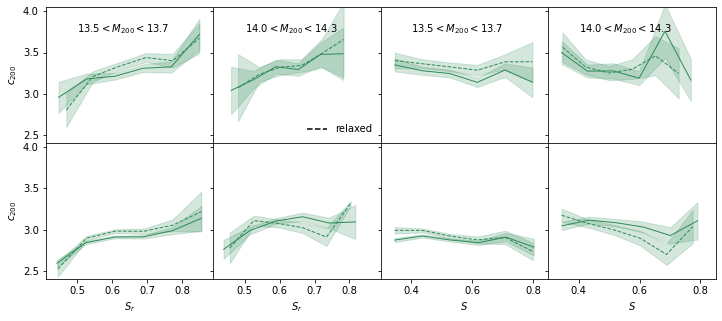

In [6]:
f, ax = plt.subplots(2,4, figsize=(12,5),sharey=True)
f.subplots_adjust(hspace=0,wspace=0)

ax[0,1].plot([-1,-1],[0,-1],'k--',label='relaxed')
ax[0,1].legend(loc=4,frameon=False,ncol=2)

msel = mfit*(sr<0.9)*(sr>0.4)
mres = mrelax
#m = msel*(cNFW_rho > 0)*(cNFW_rho < 10)*(z > 0.1)*(z < 0.25)*(lgMNFW_rho > 13.5)*(lgMNFW_rho < 13.7)
#make_plot2(sr[m],cNFW_rho[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[0,0])
m = msel*(cEin_rho> 0)*(cEin_rho < 10)*(z > 0.1)*(z < 0.25)*(lgMEin_rho > 13.5)*(lgMEin_rho < 13.7)
make_plot2(sr[m],cEin_rho[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[0,0])

#m = msel*(cNFW_rho > 0)*(cNFW_rho < 10)*(z > 0.1)*(z < 0.25)*(lgMNFW_rho > 13.5)*(lgMNFW_rho < 13.7)*mres
#make_plot2(sr[m],cNFW_rho[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[0,0],lt='--')
m = msel*(cEin_rho> 0)*(cEin_rho < 10)*(z > 0.1)*(z < 0.25)*(lgMEin_rho > 13.5)*(lgMEin_rho < 13.7)*mres
make_plot2(sr[m],cEin_rho[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[0,0],lt='--')

ax[0,0].set_ylabel(r'$c_{200}$')
ax[1,0].set_ylabel(r'$c_{200}$')

#m = msel*(cNFW_rho > 0)*(cNFW_rho < 10)*(z > 0.9)*(z < 1)*(lgMNFW_rho > 13.5)*(lgMNFW_rho < 13.7)
#make_plot2(sr[m],cNFW_rho[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[1,0])
m = msel*(cEin_rho> 0)*(cEin_rho < 10)*(z > 0.9)*(z < 1)*(lgMEin_rho > 13.5)*(lgMEin_rho < 13.7)
make_plot2(sr[m],cEin_rho[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[1,0])

#m = msel*(cNFW_rho > 0)*(cNFW_rho < 10)*(z > 0.9)*(z < 1)*(lgMNFW_rho > 13.5)*(lgMNFW_rho < 13.7)*mres
#make_plot2(sr[m],cNFW_rho[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[1,0],lt='--')
m = msel*(cEin_rho> 0)*(cEin_rho < 10)*(z > 0.9)*(z < 1)*(lgMEin_rho > 13.5)*(lgMEin_rho < 13.7)*mres
make_plot2(sr[m],cEin_rho[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[1,0],lt='--')

ax[1,0].set_xlabel(r'$S_r$')

#m = msel*(cNFW_rho > 0)*(cNFW_rho < 10)*(z > 0.1)*(z < 0.25)*(lgMNFW_rho > 14)*(lgMNFW_rho < 14.3)
#make_plot2(sr[m],cNFW_rho[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[0,1])
m = msel*(cEin_rho> 0)*(cEin_rho < 10)*(z > 0.1)*(z < 0.25)*(lgMEin_rho > 14)*(lgMEin_rho < 14.3)
make_plot2(sr[m],cEin_rho[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[0,1])

#m = msel*(cNFW_rho > 0)*(cNFW_rho < 10)*(z > 0.1)*(z < 0.25)*(lgMNFW_rho > 14)*(lgMNFW_rho < 14.3)*mres
#make_plot2(sr[m],cNFW_rho[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[0,1],lt='--')
m = msel*(cEin_rho> 0)*(cEin_rho < 10)*(z > 0.1)*(z < 0.25)*(lgMEin_rho > 14)*(lgMEin_rho < 14.3)*mres
make_plot2(sr[m],cEin_rho[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[0,1],lt='--')

#m = msel*(cNFW_rho > 0)*(cNFW_rho < 10)*(z > 0.9)*(z < 1.)*(lgMNFW_rho > 14)*(lgMNFW_rho < 14.3)
#make_plot2(sr[m],cNFW_rho[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[1,1])
m = msel*(cEin_rho> 0)*(cEin_rho < 10)*(z > 0.9)*(z < 1.)*(lgMEin_rho > 14)*(lgMEin_rho < 14.3)
make_plot2(sr[m],cEin_rho[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[1,1])
#m = msel*(cNFW_rho > 0)*(cNFW_rho < 10)*(z > 0.9)*(z < 1.)*(lgMNFW_rho > 14)*(lgMNFW_rho < 14.3)*mres
#make_plot2(sr[m],cNFW_rho[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[1,1],lt='--')
m = msel*(cEin_rho> 0)*(cEin_rho < 10)*(z > 0.9)*(z < 1.)*(lgMEin_rho > 14)*(lgMEin_rho < 14.3)*mres
make_plot2(sr[m],cEin_rho[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[1,1],lt='--')

ax[1,1].set_xlabel(r'$S_r$')

msel = mfit*(s<0.85)*(s>0.3)

#m = msel*(cNFW_rho > 0)*(cNFW_rho < 10)*(z > 0.1)*(z < 0.25)*(lgMNFW_rho > 13.5)*(lgMNFW_rho < 13.7)
#make_plot2(s[m],cNFW_rho[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[0,2])
m = msel*(cEin_rho> 0)*(cEin_rho < 10)*(z > 0.1)*(z < 0.25)*(lgMEin_rho > 13.5)*(lgMEin_rho < 13.7)
make_plot2(s[m],cEin_rho[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[0,2])
#m = msel*(cNFW_rho > 0)*(cNFW_rho < 10)*(z > 0.1)*(z < 0.25)*(lgMNFW_rho > 13.5)*(lgMNFW_rho < 13.7)*mres
#make_plot2(s[m],cNFW_rho[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[0,2],lt='--')
m = msel*(cEin_rho> 0)*(cEin_rho < 10)*(z > 0.1)*(z < 0.25)*(lgMEin_rho > 13.5)*(lgMEin_rho < 13.7)*mres
make_plot2(s[m],cEin_rho[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[0,2],lt='--')

#m = msel*(cNFW_rho > 0)*(cNFW_rho < 10)*(z > 0.9)*(z < 1)*(lgMNFW_rho > 13.5)*(lgMNFW_rho < 13.7)
#make_plot2(s[m],cNFW_rho[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[1,2])
m = msel*(cEin_rho> 0)*(cEin_rho < 10)*(z > 0.9)*(z < 1)*(lgMEin_rho > 13.5)*(lgMEin_rho < 13.7)
make_plot2(s[m],cEin_rho[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[1,2])
#m = msel*(cNFW_rho > 0)*(cNFW_rho < 10)*(z > 0.9)*(z < 1)*(lgMNFW_rho > 13.5)*(lgMNFW_rho < 13.7)*mres
#make_plot2(s[m],cNFW_rho[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[1,2],lt='--')
m = msel*(cEin_rho> 0)*(cEin_rho < 10)*(z > 0.9)*(z < 1)*(lgMEin_rho > 13.5)*(lgMEin_rho < 13.7)*mres
make_plot2(s[m],cEin_rho[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[1,2],lt='--')

ax[1,2].set_xlabel(r'$S$')

ax[0,0].text(0.5,3.75,'$13.5 < M_{200} < 13.7$')
ax[0,1].text(0.5,3.75,'$14.0 < M_{200} < 14.3$')
ax[0,2].text(0.4,3.75,'$13.5 < M_{200} < 13.7$')
ax[0,3].text(0.4,3.75,'$14.0 < M_{200} < 14.3$')

#m = msel*(cNFW_rho > 0)*(cNFW_rho < 10)*(z > 0.1)*(z < 0.25)*(lgMNFW_rho > 14)*(lgMNFW_rho < 14.3)
#make_plot2(s[m],cNFW_rho[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[0,3])
m = msel*(cEin_rho> 0)*(cEin_rho < 10)*(z > 0.1)*(z < 0.25)*(lgMEin_rho > 14)*(lgMEin_rho < 14.3)
make_plot2(s[m],cEin_rho[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[0,3])
#m = msel*(cNFW_rho > 0)*(cNFW_rho < 10)*(z > 0.1)*(z < 0.25)*(lgMNFW_rho > 14)*(lgMNFW_rho < 14.3)*mres
#make_plot2(s[m],cNFW_rho[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[0,3],lt='--')
m = msel*(cEin_rho> 0)*(cEin_rho < 10)*(z > 0.1)*(z < 0.25)*(lgMEin_rho > 14)*(lgMEin_rho < 14.3)*mres
make_plot2(s[m],cEin_rho[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[0,3],lt='--')

#m = msel*(cNFW_rho > 0)*(cNFW_rho < 10)*(z > 0.9)*(z < 1.)*(lgMNFW_rho > 14)*(lgMNFW_rho < 14.3)
#make_plot2(s[m],cNFW_rho[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[1,3])
m = msel*(cEin_rho> 0)*(cEin_rho < 10)*(z > 0.9)*(z < 1.)*(lgMEin_rho > 14)*(lgMEin_rho < 14.3)
make_plot2(s[m],cEin_rho[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[1,3])
#m = msel*(cNFW_rho > 0)*(cNFW_rho < 10)*(z > 0.9)*(z < 1.)*(lgMNFW_rho > 14)*(lgMNFW_rho < 14.3)*mres
#make_plot2(s[m],cNFW_rho[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[1,3],lt='--')
m = msel*(cEin_rho> 0)*(cEin_rho < 10)*(z > 0.9)*(z < 1.)*(lgMEin_rho > 14)*(lgMEin_rho < 14.3)*mres
make_plot2(s[m],cEin_rho[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[1,3],lt='--')

ax[1,3].set_xlabel(r'$S$')
ax[0,0].set_ylim([2.4,4.05])
for j in range(2):
    for i in range(2):
        ax[i,j].set_xlim([0.41,0.89])
        ax[i,j+2].set_xlim([0.3,0.85])

f.savefig(plot_path+'concentration_shape.pdf',bbox_inches='tight')
hide_toggle()

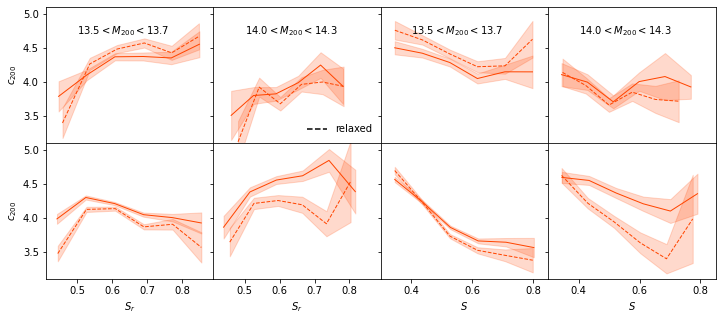

In [15]:
f, ax = plt.subplots(2,4, figsize=(12,5),sharey=True)
f.subplots_adjust(hspace=0,wspace=0)

ax[0,1].plot([-1,-1],[0,-1],'k--',label='relaxed')
ax[0,1].legend(loc=4,frameon=False,ncol=2)

msel = mfit*(sr<0.9)*(sr>0.4)
mres = mrelax
m = msel*(cNFW_rho > 0)*(cNFW_rho < 10)*(z > 0.1)*(z < 0.25)*(lgMNFW_rho > 13.5)*(lgMNFW_rho < 13.7)
make_plot2(sr[m],cNFW_rho[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[0,0])
#m = msel*(cEin_rho> 0)*(cEin_rho < 10)*(z > 0.1)*(z < 0.25)*(lgMEin_rho > 13.5)*(lgMEin_rho < 13.7)
#make_plot2(sr[m],cEin_rho[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[0,0])

m = msel*(cNFW_rho > 0)*(cNFW_rho < 10)*(z > 0.1)*(z < 0.25)*(lgMNFW_rho > 13.5)*(lgMNFW_rho < 13.7)*mres
make_plot2(sr[m],cNFW_rho[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[0,0],lt='--')
#m = msel*(cEin_rho> 0)*(cEin_rho < 10)*(z > 0.1)*(z < 0.25)*(lgMEin_rho > 13.5)*(lgMEin_rho < 13.7)*mres
#make_plot2(sr[m],cEin_rho[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[0,0],lt='--')

ax[0,0].set_ylabel(r'$c_{200}$')
ax[1,0].set_ylabel(r'$c_{200}$')

m = msel*(cNFW_rho > 0)*(cNFW_rho < 10)*(z > 0.9)*(z < 1)*(lgMNFW_rho > 13.5)*(lgMNFW_rho < 13.7)
make_plot2(sr[m],cNFW_rho[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[1,0])
#m = msel*(cEin_rho> 0)*(cEin_rho < 10)*(z > 0.9)*(z < 1)*(lgMEin_rho > 13.5)*(lgMEin_rho < 13.7)
#make_plot2(sr[m],cEin_rho[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[1,0])

m = msel*(cNFW_rho > 0)*(cNFW_rho < 10)*(z > 0.9)*(z < 1)*(lgMNFW_rho > 13.5)*(lgMNFW_rho < 13.7)*mres
make_plot2(sr[m],cNFW_rho[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[1,0],lt='--')
#m = msel*(cEin_rho> 0)*(cEin_rho < 10)*(z > 0.9)*(z < 1)*(lgMEin_rho > 13.5)*(lgMEin_rho < 13.7)*mres
#make_plot2(sr[m],cEin_rho[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[1,0],lt='--')

ax[1,0].set_xlabel(r'$S_r$')

m = msel*(cNFW_rho > 0)*(cNFW_rho < 10)*(z > 0.1)*(z < 0.25)*(lgMNFW_rho > 14)*(lgMNFW_rho < 14.3)
make_plot2(sr[m],cNFW_rho[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[0,1])
#m = msel*(cEin_rho> 0)*(cEin_rho < 10)*(z > 0.1)*(z < 0.25)*(lgMEin_rho > 14)*(lgMEin_rho < 14.3)
#make_plot2(sr[m],cEin_rho[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[0,1])

m = msel*(cNFW_rho > 0)*(cNFW_rho < 10)*(z > 0.1)*(z < 0.25)*(lgMNFW_rho > 14)*(lgMNFW_rho < 14.3)*mres
make_plot2(sr[m],cNFW_rho[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[0,1],lt='--')
#m = msel*(cEin_rho> 0)*(cEin_rho < 10)*(z > 0.1)*(z < 0.25)*(lgMEin_rho > 14)*(lgMEin_rho < 14.3)*mres
#make_plot2(sr[m],cEin_rho[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[0,1],lt='--')

m = msel*(cNFW_rho > 0)*(cNFW_rho < 10)*(z > 0.9)*(z < 1.)*(lgMNFW_rho > 14)*(lgMNFW_rho < 14.3)
make_plot2(sr[m],cNFW_rho[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[1,1])
#m = msel*(cEin_rho> 0)*(cEin_rho < 10)*(z > 0.9)*(z < 1.)*(lgMEin_rho > 14)*(lgMEin_rho < 14.3)
#make_plot2(sr[m],cEin_rho[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[1,1])
m = msel*(cNFW_rho > 0)*(cNFW_rho < 10)*(z > 0.9)*(z < 1.)*(lgMNFW_rho > 14)*(lgMNFW_rho < 14.3)*mres
make_plot2(sr[m],cNFW_rho[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[1,1],lt='--')
#m = msel*(cEin_rho> 0)*(cEin_rho < 10)*(z > 0.9)*(z < 1.)*(lgMEin_rho > 14)*(lgMEin_rho < 14.3)*mres
#make_plot2(sr[m],cEin_rho[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[1,1],lt='--')

ax[1,1].set_xlabel(r'$S_r$')

msel = mfit*(s<0.85)*(s>0.3)

m = msel*(cNFW_rho > 0)*(cNFW_rho < 10)*(z > 0.1)*(z < 0.25)*(lgMNFW_rho > 13.5)*(lgMNFW_rho < 13.7)
make_plot2(s[m],cNFW_rho[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[0,2])
#m = msel*(cEin_rho> 0)*(cEin_rho < 10)*(z > 0.1)*(z < 0.25)*(lgMEin_rho > 13.5)*(lgMEin_rho < 13.7)
#make_plot2(s[m],cEin_rho[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[0,2])
m = msel*(cNFW_rho > 0)*(cNFW_rho < 10)*(z > 0.1)*(z < 0.25)*(lgMNFW_rho > 13.5)*(lgMNFW_rho < 13.7)*mres
make_plot2(s[m],cNFW_rho[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[0,2],lt='--')
#m = msel*(cEin_rho> 0)*(cEin_rho < 10)*(z > 0.1)*(z < 0.25)*(lgMEin_rho > 13.5)*(lgMEin_rho < 13.7)*mres
#make_plot2(s[m],cEin_rho[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[0,2],lt='--')

m = msel*(cNFW_rho > 0)*(cNFW_rho < 10)*(z > 0.9)*(z < 1)*(lgMNFW_rho > 13.5)*(lgMNFW_rho < 13.7)
make_plot2(s[m],cNFW_rho[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[1,2])
#m = msel*(cEin_rho> 0)*(cEin_rho < 10)*(z > 0.9)*(z < 1)*(lgMEin_rho > 13.5)*(lgMEin_rho < 13.7)
#make_plot2(s[m],cEin_rho[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[1,2])
m = msel*(cNFW_rho > 0)*(cNFW_rho < 10)*(z > 0.9)*(z < 1)*(lgMNFW_rho > 13.5)*(lgMNFW_rho < 13.7)*mres
make_plot2(s[m],cNFW_rho[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[1,2],lt='--')
#m = msel*(cEin_rho> 0)*(cEin_rho < 10)*(z > 0.9)*(z < 1)*(lgMEin_rho > 13.5)*(lgMEin_rho < 13.7)*mres
#make_plot2(s[m],cEin_rho[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[1,2],lt='--')

ax[1,2].set_xlabel(r'$S$')

ax[0,0].text(0.5,4.7,'$13.5 < M_{200} < 13.7$')
ax[0,1].text(0.5,4.7,'$14.0 < M_{200} < 14.3$')
ax[0,2].text(0.4,4.7,'$13.5 < M_{200} < 13.7$')
ax[0,3].text(0.4,4.7,'$14.0 < M_{200} < 14.3$')


m = msel*(cNFW_rho > 0)*(cNFW_rho < 10)*(z > 0.1)*(z < 0.25)*(lgMNFW_rho > 14)*(lgMNFW_rho < 14.3)
make_plot2(s[m],cNFW_rho[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[0,3])
#m = msel*(cEin_rho> 0)*(cEin_rho < 10)*(z > 0.1)*(z < 0.25)*(lgMEin_rho > 14)*(lgMEin_rho < 14.3)
#make_plot2(s[m],cEin_rho[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[0,3])
m = msel*(cNFW_rho > 0)*(cNFW_rho < 10)*(z > 0.1)*(z < 0.25)*(lgMNFW_rho > 14)*(lgMNFW_rho < 14.3)*mres
make_plot2(s[m],cNFW_rho[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[0,3],lt='--')
#m = msel*(cEin_rho> 0)*(cEin_rho < 10)*(z > 0.1)*(z < 0.25)*(lgMEin_rho > 14)*(lgMEin_rho < 14.3)*mres
#make_plot2(s[m],cEin_rho[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[0,3],lt='--')

m = msel*(cNFW_rho > 0)*(cNFW_rho < 10)*(z > 0.9)*(z < 1.)*(lgMNFW_rho > 14)*(lgMNFW_rho < 14.3)
make_plot2(s[m],cNFW_rho[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[1,3])
#m = msel*(cEin_rho> 0)*(cEin_rho < 10)*(z > 0.9)*(z < 1.)*(lgMEin_rho > 14)*(lgMEin_rho < 14.3)
#make_plot2(s[m],cEin_rho[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[1,3])
m = msel*(cNFW_rho > 0)*(cNFW_rho < 10)*(z > 0.9)*(z < 1.)*(lgMNFW_rho > 14)*(lgMNFW_rho < 14.3)*mres
make_plot2(s[m],cNFW_rho[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[1,3],lt='--')
#m = msel*(cEin_rho> 0)*(cEin_rho < 10)*(z > 0.9)*(z < 1.)*(lgMEin_rho > 14)*(lgMEin_rho < 14.3)*mres
#make_plot2(s[m],cEin_rho[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[1,3],lt='--')

ax[1,3].set_xlabel(r'$S$')
ax[0,0].set_ylim([3.1,5.1])
for j in range(2):
    for i in range(2):
        ax[i,j].set_xlim([0.41,0.89])
        ax[i,j+2].set_xlim([0.3,0.85])

f.savefig(plot_path+'concentration_shape_NFW.pdf',bbox_inches='tight')
hide_toggle()

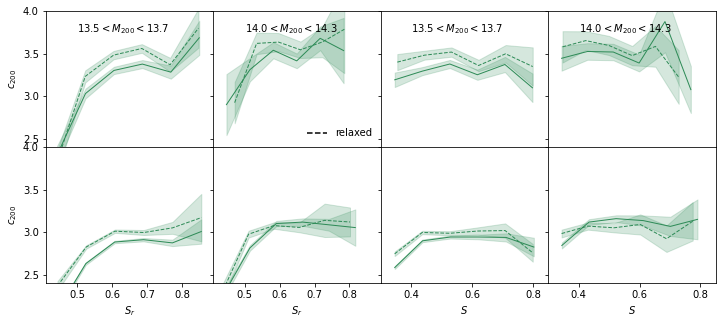

In [21]:
f, ax = plt.subplots(2,4, figsize=(12,5),sharey=True)
f.subplots_adjust(hspace=0,wspace=0)

ax[0,1].plot([-1,-1],[0,-1],'k--',label='relaxed')
ax[0,1].legend(loc=4,frameon=False,ncol=2)

msel = mfit*(sr<0.9)*(sr>0.4)
mres = mrelax
#m = msel*(cNFW_rho_E > 0)*(cNFW_rho_E < 10)*(z > 0.1)*(z < 0.25)*(lgMNFW_rho_E > 13.5)*(lgMNFW_rho_E < 13.7)
#make_plot2(sr[m],cNFW_rho_E[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[0,0])
m = msel*(cEin_rho_E> 0)*(cEin_rho_E < 10)*(z > 0.1)*(z < 0.25)*(lgMEin_rho_E > 13.5)*(lgMEin_rho_E < 13.7)
make_plot2(sr[m],cEin_rho_E[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[0,0])

#m = msel*(cNFW_rho_E > 0)*(cNFW_rho_E < 10)*(z > 0.1)*(z < 0.25)*(lgMNFW_rho_E > 13.5)*(lgMNFW_rho_E < 13.7)*mres
#make_plot2(sr[m],cNFW_rho_E[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[0,0],lt='--')
m = msel*(cEin_rho_E> 0)*(cEin_rho_E < 10)*(z > 0.1)*(z < 0.25)*(lgMEin_rho_E > 13.5)*(lgMEin_rho_E < 13.7)*mres
make_plot2(sr[m],cEin_rho_E[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[0,0],lt='--')

ax[0,0].set_ylabel(r'$c_{200}$')
ax[1,0].set_ylabel(r'$c_{200}$')

#m = msel*(cNFW_rho_E > 0)*(cNFW_rho_E < 10)*(z > 0.9)*(z < 1)*(lgMNFW_rho_E > 13.5)*(lgMNFW_rho_E < 13.7)
#make_plot2(sr[m],cNFW_rho_E[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[1,0])
m = msel*(cEin_rho_E> 0)*(cEin_rho_E < 10)*(z > 0.9)*(z < 1)*(lgMEin_rho_E > 13.5)*(lgMEin_rho_E < 13.7)
make_plot2(sr[m],cEin_rho_E[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[1,0])

#m = msel*(cNFW_rho_E > 0)*(cNFW_rho_E < 10)*(z > 0.9)*(z < 1)*(lgMNFW_rho_E > 13.5)*(lgMNFW_rho_E < 13.7)*mres
#make_plot2(sr[m],cNFW_rho_E[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[1,0],lt='--')
m = msel*(cEin_rho_E> 0)*(cEin_rho_E < 10)*(z > 0.9)*(z < 1)*(lgMEin_rho_E > 13.5)*(lgMEin_rho_E < 13.7)*mres
make_plot2(sr[m],cEin_rho_E[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[1,0],lt='--')

ax[1,0].set_xlabel(r'$S_r$')

#m = msel*(cNFW_rho_E > 0)*(cNFW_rho_E < 10)*(z > 0.1)*(z < 0.25)*(lgMNFW_rho_E > 14)*(lgMNFW_rho_E < 14.3)
#make_plot2(sr[m],cNFW_rho_E[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[0,1])
m = msel*(cEin_rho_E> 0)*(cEin_rho_E < 10)*(z > 0.1)*(z < 0.25)*(lgMEin_rho_E > 14)*(lgMEin_rho_E < 14.3)
make_plot2(sr[m],cEin_rho_E[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[0,1])

#m = msel*(cNFW_rho_E > 0)*(cNFW_rho_E < 10)*(z > 0.1)*(z < 0.25)*(lgMNFW_rho_E > 14)*(lgMNFW_rho_E < 14.3)*mres
#make_plot2(sr[m],cNFW_rho_E[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[0,1],lt='--')
m = msel*(cEin_rho_E> 0)*(cEin_rho_E < 10)*(z > 0.1)*(z < 0.25)*(lgMEin_rho_E > 14)*(lgMEin_rho_E < 14.3)*mres
make_plot2(sr[m],cEin_rho_E[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[0,1],lt='--')

#m = msel*(cNFW_rho_E > 0)*(cNFW_rho_E < 10)*(z > 0.9)*(z < 1.)*(lgMNFW_rho_E > 14)*(lgMNFW_rho_E < 14.3)
#make_plot2(sr[m],cNFW_rho_E[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[1,1])
m = msel*(cEin_rho_E> 0)*(cEin_rho_E < 10)*(z > 0.9)*(z < 1.)*(lgMEin_rho_E > 14)*(lgMEin_rho_E < 14.3)
make_plot2(sr[m],cEin_rho_E[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[1,1])
#m = msel*(cNFW_rho_E > 0)*(cNFW_rho_E < 10)*(z > 0.9)*(z < 1.)*(lgMNFW_rho_E > 14)*(lgMNFW_rho_E < 14.3)*mres
#make_plot2(sr[m],cNFW_rho_E[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[1,1],lt='--')
m = msel*(cEin_rho_E> 0)*(cEin_rho_E < 10)*(z > 0.9)*(z < 1.)*(lgMEin_rho_E > 14)*(lgMEin_rho_E < 14.3)*mres
make_plot2(sr[m],cEin_rho_E[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[1,1],lt='--')

ax[1,1].set_xlabel(r'$S_r$')

msel = mfit*(s<0.85)*(s>0.3)

#m = msel*(cNFW_rho_E > 0)*(cNFW_rho_E < 10)*(z > 0.1)*(z < 0.25)*(lgMNFW_rho_E > 13.5)*(lgMNFW_rho_E < 13.7)
#make_plot2(s[m],cNFW_rho_E[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[0,2])
m = msel*(cEin_rho_E> 0)*(cEin_rho_E < 10)*(z > 0.1)*(z < 0.25)*(lgMEin_rho_E > 13.5)*(lgMEin_rho_E < 13.7)
make_plot2(s[m],cEin_rho_E[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[0,2])
#m = msel*(cNFW_rho_E > 0)*(cNFW_rho_E < 10)*(z > 0.1)*(z < 0.25)*(lgMNFW_rho_E > 13.5)*(lgMNFW_rho_E < 13.7)*mres
#make_plot2(s[m],cNFW_rho_E[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[0,2],lt='--')
m = msel*(cEin_rho_E> 0)*(cEin_rho_E < 10)*(z > 0.1)*(z < 0.25)*(lgMEin_rho_E > 13.5)*(lgMEin_rho_E < 13.7)*mres
make_plot2(s[m],cEin_rho_E[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[0,2],lt='--')

#m = msel*(cNFW_rho_E > 0)*(cNFW_rho_E < 10)*(z > 0.9)*(z < 1)*(lgMNFW_rho_E > 13.5)*(lgMNFW_rho_E < 13.7)
#make_plot2(s[m],cNFW_rho_E[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[1,2])
m = msel*(cEin_rho_E> 0)*(cEin_rho_E < 10)*(z > 0.9)*(z < 1)*(lgMEin_rho_E > 13.5)*(lgMEin_rho_E < 13.7)
make_plot2(s[m],cEin_rho_E[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[1,2])
#m = msel*(cNFW_rho_E > 0)*(cNFW_rho_E < 10)*(z > 0.9)*(z < 1)*(lgMNFW_rho_E > 13.5)*(lgMNFW_rho_E < 13.7)*mres
#make_plot2(s[m],cNFW_rho_E[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[1,2],lt='--')
m = msel*(cEin_rho_E> 0)*(cEin_rho_E < 10)*(z > 0.9)*(z < 1)*(lgMEin_rho_E > 13.5)*(lgMEin_rho_E < 13.7)*mres
make_plot2(s[m],cEin_rho_E[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[1,2],lt='--')

ax[1,2].set_xlabel(r'$S$')

ax[0,0].text(0.5,3.75,'$13.5 < M_{200} < 13.7$')
ax[0,1].text(0.5,3.75,'$14.0 < M_{200} < 14.3$')
ax[0,2].text(0.4,3.75,'$13.5 < M_{200} < 13.7$')
ax[0,3].text(0.4,3.75,'$14.0 < M_{200} < 14.3$')

#m = msel*(cNFW_rho_E > 0)*(cNFW_rho_E < 10)*(z > 0.1)*(z < 0.25)*(lgMNFW_rho_E > 14)*(lgMNFW_rho_E < 14.3)
#make_plot2(s[m],cNFW_rho_E[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[0,3])
m = msel*(cEin_rho_E> 0)*(cEin_rho_E < 10)*(z > 0.1)*(z < 0.25)*(lgMEin_rho_E > 14)*(lgMEin_rho_E < 14.3)
make_plot2(s[m],cEin_rho_E[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[0,3])
#m = msel*(cNFW_rho_E > 0)*(cNFW_rho_E < 10)*(z > 0.1)*(z < 0.25)*(lgMNFW_rho_E > 14)*(lgMNFW_rho_E < 14.3)*mres
#make_plot2(s[m],cNFW_rho_E[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[0,3],lt='--')
m = msel*(cEin_rho_E> 0)*(cEin_rho_E < 10)*(z > 0.1)*(z < 0.25)*(lgMEin_rho_E > 14)*(lgMEin_rho_E < 14.3)*mres
make_plot2(s[m],cEin_rho_E[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[0,3],lt='--')

#m = msel*(cNFW_rho_E > 0)*(cNFW_rho_E < 10)*(z > 0.9)*(z < 1.)*(lgMNFW_rho_E > 14)*(lgMNFW_rho_E < 14.3)
#make_plot2(s[m],cNFW_rho_E[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[1,3])
m = msel*(cEin_rho_E> 0)*(cEin_rho_E < 10)*(z > 0.9)*(z < 1.)*(lgMEin_rho_E > 14)*(lgMEin_rho_E < 14.3)
make_plot2(s[m],cEin_rho_E[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[1,3])
#m = msel*(cNFW_rho_E > 0)*(cNFW_rho_E < 10)*(z > 0.9)*(z < 1.)*(lgMNFW_rho_E > 14)*(lgMNFW_rho_E < 14.3)*mres
#make_plot2(s[m],cNFW_rho_E[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[1,3],lt='--')
m = msel*(cEin_rho_E> 0)*(cEin_rho_E < 10)*(z > 0.9)*(z < 1.)*(lgMEin_rho_E > 14)*(lgMEin_rho_E < 14.3)*mres
make_plot2(s[m],cEin_rho_E[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[1,3],lt='--')

ax[1,3].set_xlabel(r'$S$')
ax[0,0].set_ylim([2.4,4])
for j in range(2):
    for i in range(2):
        ax[i,j].set_xlim([0.41,0.89])
        ax[i,j+2].set_xlim([0.3,0.85])

f.savefig(plot_path+'concentration_shape.pdf',bbox_inches='tight')
hide_toggle()

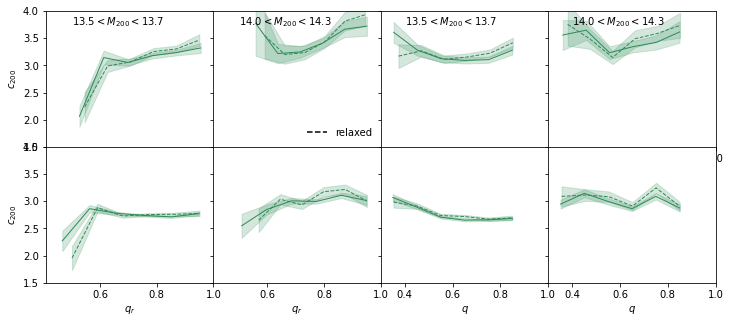

In [25]:
f, ax = plt.subplots(2,4, figsize=(12,5),sharey=True)
f.subplots_adjust(hspace=0,wspace=0)

ax[0,1].plot([-1,-1],[0,-1],'k--',label='relaxed')
ax[0,1].legend(loc=4,frameon=False,ncol=2)

msel = mfit*(q2dr<1.)*(q2dr>0.4)
mres = mrelax
#m = msel*(cNFW_S > 0)*(cNFW_S < 10)*(z > 0.1)*(z < 0.25)*(lgMNFW_S > 13.5)*(lgMNFW_S < 13.7)
#make_plot2(q2dr[m],cNFW_S[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[0,0])
m = msel*(cEin_S> 0)*(cEin_S < 10)*(z > 0.1)*(z < 0.25)*(lgMEin_S > 13.5)*(lgMEin_S < 13.7)
make_plot2(q2dr[m],cEin_S[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[0,0])

#m = msel*(cNFW_S > 0)*(cNFW_S < 10)*(z > 0.1)*(z < 0.25)*(lgMNFW_S > 13.5)*(lgMNFW_S < 13.7)*mres
#make_plot2(q2dr[m],cNFW_S[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[0,0],lt='--')
m = msel*(cEin_S> 0)*(cEin_S < 10)*(z > 0.1)*(z < 0.25)*(lgMEin_S > 13.5)*(lgMEin_S < 13.7)*mres
make_plot2(q2dr[m],cEin_S[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[0,0],lt='--')

ax[0,0].set_ylabel(r'$c_{200}$')
ax[1,0].set_ylabel(r'$c_{200}$')

#m = msel*(cNFW_S > 0)*(cNFW_S < 10)*(z > 0.9)*(z < 1)*(lgMNFW_S > 13.5)*(lgMNFW_S < 13.7)
#make_plot2(q2dr[m],cNFW_S[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[1,0])
m = msel*(cEin_S> 0)*(cEin_S < 10)*(z > 0.9)*(z < 1)*(lgMEin_S > 13.5)*(lgMEin_S < 13.7)
make_plot2(q2dr[m],cEin_S[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[1,0])

#m = msel*(cNFW_S > 0)*(cNFW_S < 10)*(z > 0.9)*(z < 1)*(lgMNFW_S > 13.5)*(lgMNFW_S < 13.7)*mres
#make_plot2(q2dr[m],cNFW_S[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[1,0],lt='--')
m = msel*(cEin_S> 0)*(cEin_S < 10)*(z > 0.9)*(z < 1)*(lgMEin_S > 13.5)*(lgMEin_S < 13.7)*mres
make_plot2(q2dr[m],cEin_S[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[1,0],lt='--')

ax[1,0].set_xlabel(r'$q_r$')

#m = msel*(cNFW_S > 0)*(cNFW_S < 10)*(z > 0.1)*(z < 0.25)*(lgMNFW_S > 14)*(lgMNFW_S < 14.3)
#make_plot2(q2dr[m],cNFW_S[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[0,1])
m = msel*(cEin_S> 0)*(cEin_S < 10)*(z > 0.1)*(z < 0.25)*(lgMEin_S > 14)*(lgMEin_S < 14.3)
make_plot2(q2dr[m],cEin_S[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[0,1])

#m = msel*(cNFW_S > 0)*(cNFW_S < 10)*(z > 0.1)*(z < 0.25)*(lgMNFW_S > 14)*(lgMNFW_S < 14.3)*mres
#make_plot2(q2dr[m],cNFW_S[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[0,1],lt='--')
m = msel*(cEin_S> 0)*(cEin_S < 10)*(z > 0.1)*(z < 0.25)*(lgMEin_S > 14)*(lgMEin_S < 14.3)*mres
make_plot2(q2dr[m],cEin_S[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[0,1],lt='--')

#m = msel*(cNFW_S > 0)*(cNFW_S < 10)*(z > 0.9)*(z < 1.)*(lgMNFW_S > 14)*(lgMNFW_S < 14.3)
#make_plot2(q2dr[m],cNFW_S[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[1,1])
m = msel*(cEin_S> 0)*(cEin_S < 10)*(z > 0.9)*(z < 1.)*(lgMEin_S > 14)*(lgMEin_S < 14.3)
make_plot2(q2dr[m],cEin_S[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[1,1])
#m = msel*(cNFW_S > 0)*(cNFW_S < 10)*(z > 0.9)*(z < 1.)*(lgMNFW_S > 14)*(lgMNFW_S < 14.3)*mres
#make_plot2(q2dr[m],cNFW_S[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[1,1],lt='--')
m = msel*(cEin_S> 0)*(cEin_S < 10)*(z > 0.9)*(z < 1.)*(lgMEin_S > 14)*(lgMEin_S < 14.3)*mres
make_plot2(q2dr[m],cEin_S[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[1,1],lt='--')

ax[1,1].set_xlabel(r'$q_r$')

msel = mfit*(q2d<0.9)*(q2d>0.3)

#m = msel*(cNFW_S > 0)*(cNFW_S < 10)*(z > 0.1)*(z < 0.25)*(lgMNFW_S > 13.5)*(lgMNFW_S < 13.7)
#make_plot2(q2d[m],cNFW_S[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[0,2])
m = msel*(cEin_S> 0)*(cEin_S < 10)*(z > 0.1)*(z < 0.25)*(lgMEin_S > 13.5)*(lgMEin_S < 13.7)
make_plot2(q2d[m],cEin_S[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[0,2])
#m = msel*(cNFW_S > 0)*(cNFW_S < 10)*(z > 0.1)*(z < 0.25)*(lgMNFW_S > 13.5)*(lgMNFW_S < 13.7)*mres
#make_plot2(q2d[m],cNFW_S[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[0,2],lt='--')
m = msel*(cEin_S> 0)*(cEin_S < 10)*(z > 0.1)*(z < 0.25)*(lgMEin_S > 13.5)*(lgMEin_S < 13.7)*mres
make_plot2(q2d[m],cEin_S[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[0,2],lt='--')

#m = msel*(cNFW_S > 0)*(cNFW_S < 10)*(z > 0.9)*(z < 1)*(lgMNFW_S > 13.5)*(lgMNFW_S < 13.7)
#make_plot2(q2d[m],cNFW_S[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[1,2])
m = msel*(cEin_S> 0)*(cEin_S < 10)*(z > 0.9)*(z < 1)*(lgMEin_S > 13.5)*(lgMEin_S < 13.7)
make_plot2(q2d[m],cEin_S[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[1,2])
#m = msel*(cNFW_S > 0)*(cNFW_S < 10)*(z > 0.9)*(z < 1)*(lgMNFW_S > 13.5)*(lgMNFW_S < 13.7)*mres
#make_plot2(q2d[m],cNFW_S[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[1,2],lt='--')
m = msel*(cEin_S> 0)*(cEin_S < 10)*(z > 0.9)*(z < 1)*(lgMEin_S > 13.5)*(lgMEin_S < 13.7)*mres
make_plot2(q2d[m],cEin_S[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[1,2],lt='--')

ax[1,2].set_xlabel(r'$q$')

ax[0,0].text(0.5,3.75,'$13.5 < M_{200} < 13.7$')
ax[0,1].text(0.5,3.75,'$14.0 < M_{200} < 14.3$')
ax[0,2].text(0.4,3.75,'$13.5 < M_{200} < 13.7$')
ax[0,3].text(0.4,3.75,'$14.0 < M_{200} < 14.3$')

#m = msel*(cNFW_S > 0)*(cNFW_S < 10)*(z > 0.1)*(z < 0.25)*(lgMNFW_S > 14)*(lgMNFW_S < 14.3)
#make_plot2(q2d[m],cNFW_S[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[0,3])
m = msel*(cEin_S> 0)*(cEin_S < 10)*(z > 0.1)*(z < 0.25)*(lgMEin_S > 14)*(lgMEin_S < 14.3)
make_plot2(q2d[m],cEin_S[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[0,3])
#m = msel*(cNFW_S > 0)*(cNFW_S < 10)*(z > 0.1)*(z < 0.25)*(lgMNFW_S > 14)*(lgMNFW_S < 14.3)*mres
#make_plot2(q2d[m],cNFW_S[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[0,3],lt='--')
m = msel*(cEin_S> 0)*(cEin_S < 10)*(z > 0.1)*(z < 0.25)*(lgMEin_S > 14)*(lgMEin_S < 14.3)*mres
make_plot2(q2d[m],cEin_S[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[0,3],lt='--')

#m = msel*(cNFW_S > 0)*(cNFW_S < 10)*(z > 0.9)*(z < 1.)*(lgMNFW_S > 14)*(lgMNFW_S < 14.3)
#make_plot2(q2d[m],cNFW_S[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[1,3])
m = msel*(cEin_S> 0)*(cEin_S < 10)*(z > 0.9)*(z < 1.)*(lgMEin_S > 14)*(lgMEin_S < 14.3)
make_plot2(q2d[m],cEin_S[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[1,3])
#m = msel*(cNFW_S > 0)*(cNFW_S < 10)*(z > 0.9)*(z < 1.)*(lgMNFW_S > 14)*(lgMNFW_S < 14.3)*mres
#make_plot2(q2d[m],cNFW_S[m],'orangered',6,label='NFW',error=True,lw=1,plt=ax[1,3],lt='--')
m = msel*(cEin_S> 0)*(cEin_S < 10)*(z > 0.9)*(z < 1.)*(lgMEin_S > 14)*(lgMEin_S < 14.3)*mres
make_plot2(q2d[m],cEin_S[m],'seagreen',6,label='Einasto',error=True,lw=1,plt=ax[1,3],lt='--')

ax[1,3].set_xlabel(r'$q$')
ax[0,0].set_ylim([1.5,4])
for j in range(2):
    for i in range(2):
        ax[i,j].set_xlim([0.41,1])
        ax[i,j+2].set_xlim([0.3,1])

f.savefig(plot_path+'concentration_shape_projected.pdf',bbox_inches='tight')
hide_toggle()

In [5]:
prev = pd.read_csv('../halo_props_1_1.csv.bz2')

## Variation of alpha with mass and redshift

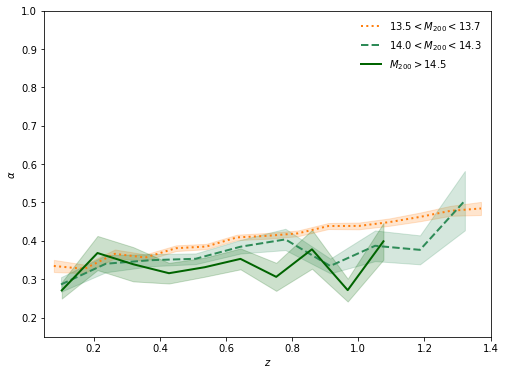

In [24]:
plt.figure(figsize=(8,6))
m = mrelax*(lgMEin_rho > 13.5)*(lgMEin_rho > 13.7)*(resEin_rho < 0.05)*mfit
make_plot2(z[m],alpha_rho[m],nbins=15,lw=2,lt=':',color='C1',label='$13.5 < M_{200} < 13.7$',error=True)
m = mrelax*(lgMEin_rho > 14.)*(lgMEin_rho > 14.3)*(resEin_rho < 0.05)*mfit
make_plot2(z[m],alpha_rho[m],nbins=10,lw=2,lt='--',color='seagreen',label='$14.0 < M_{200} < 14.3$',error=True)
m = mrelax*(lgMEin_rho > 14.5)*(resEin_rho < 0.05)*mfit
make_plot2(z[m],alpha_rho[m],nbins=10,lw=2,lt='-',color='darkgreen',label='$M_{200} > 14.5$',error=True)
plt.legend(frameon=False)
plt.xlabel(r'$z$')
plt.ylabel(r'$\alpha$')
plt.axis([0.05,1.4,0.15,1])
plt.savefig(plot_path+'alpha_z.pdf',bbox_inches='tight')
hide_toggle()


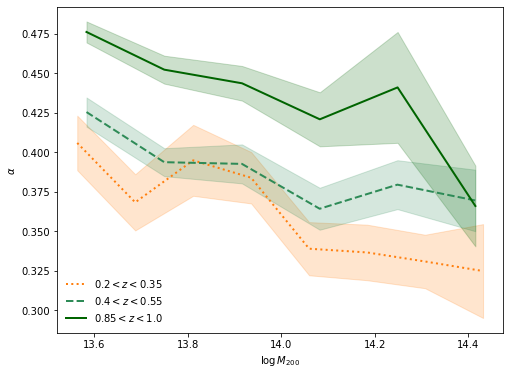

In [25]:
plt.figure(figsize=(8,6))
msel = mfit*(resEin_rho < 0.05)*(lgMEin_rho > 13.5)*(lgMEin_rho < 14.5)*mrelax
m = msel*(z > 0.2)*(z < 0.35)
make_plot2(lgMEin_rho[m],alpha_rho[m],label='$0.2 < z < 0.35$',nbins=8,lw=2,lt=':',color='C1',error=True)
m = msel*(z > 0.4)*(z < 0.55)
make_plot2(lgMEin_rho[m],alpha_rho[m],nbins=6,label = '$0.4 < z < 0.55$',lw=2,lt='--',color='seagreen',error=True)
m = msel*(z > 0.85)*(z < 1.0)
make_plot2(lgMEin_rho[m],alpha_rho[m],nbins=6,label = '$0.85 < z < 1.0$',lw=2,lt='-',color='darkgreen',error=True)
plt.legend(loc=3,frameon=False)
plt.xlabel(r'$\log M_{200}$')
plt.ylabel(r'$\alpha$')
plt.savefig(plot_path+'alpha_nu.pdf',bbox_inches='tight')
#plt.axis([1.6,4.5,0,1])
hide_toggle()


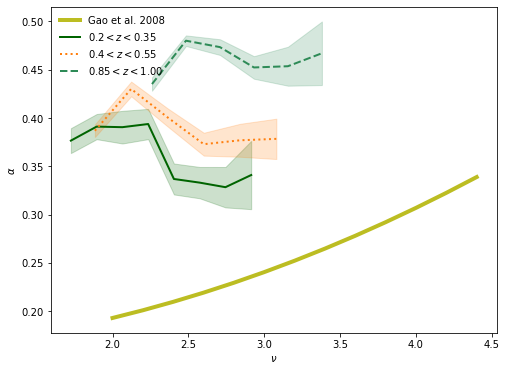

In [28]:
plt.figure(figsize=(8,6))
plt.plot(np.arange(2,4.5,0.2),0.155+0.0095*(np.arange(2,4.5,0.2))**2,'C8',lw=4,label='Gao et al. 2008')
msel = mrelax*mfit*(resEin_rho < 0.05)
m = msel*(z > 0.2)*(z < 0.35)*(nu < 3.0)*(nu > 1.5)
make_plot2(nu[m],alpha_rho[m],label='$0.2 < z < 0.35$',nbins=8,lw=2,lt='-',color='darkgreen',error=True)
m = msel*(z > 0.4)*(z < 0.55)*(nu < 3.2)*(nu > 1.6)
make_plot2(nu[m],alpha_rho[m],nbins=6,lw=2,lt=':',color='C1',error=True,label = '$0.4 < z < 0.55$')
m = msel*(z > 0.85)*(z < 1.0)*(nu < 3.5)*(nu > 2.1)
make_plot2(nu[m],alpha_rho[m],nbins=6,lw=2,lt='--',color='seagreen',error=True,label = '$0.85 < z < 1.00$')
plt.legend(loc=2,frameon=False)
plt.xlabel(r'$\nu$')
plt.ylabel(r'$\alpha$')
plt.savefig(plot_path+'alpha_nu.pdf',bbox_inches='tight')
#plt.axis([1.6,4.5,0,1])
hide_toggle()


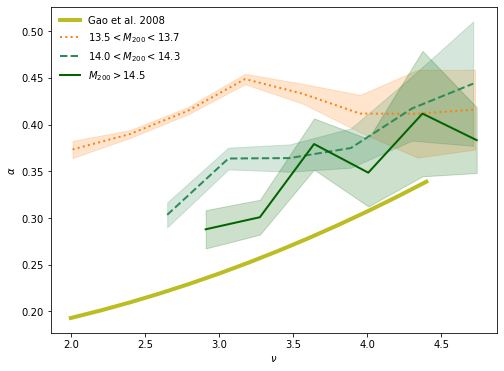

In [27]:
plt.figure(figsize=(8,6))
plt.plot(np.arange(2,4.5,0.2),0.155+0.0095*(np.arange(2,4.5,0.2))**2,'C8',lw=4,label='Gao et al. 2008')
msel = mrelax*mfit*(resEin_rho < 0.05)
m = msel*(lgMEin_rho > 13.5)*(lgMEin_rho > 13.7)
make_plot2(nu[m],alpha_rho[m],label='$13.5 < M_{200} < 13.7$',nbins=8,lw=2,lt=':',color='C1',error=True)
m = msel*(lgMEin_rho > 14.)*(lgMEin_rho > 14.3)
make_plot2(nu[m],alpha_rho[m],nbins=6,label='$14.0 < M_{200} < 14.3$',lw=2,lt='--',color='seagreen',error=True)
m = msel*(lgMEin_rho > 14.5)
make_plot2(nu[m],alpha_rho[m],nbins=6,label='$M_{200} > 14.5$',lw=2,lt='-',color='darkgreen',error=True)
plt.legend(loc=2,frameon=False)
plt.xlabel(r'$\nu$')
plt.ylabel(r'$\alpha$')
plt.savefig(plot_path+'alpha_nu.pdf',bbox_inches='tight')
#plt.axis([1.6,4.5,0,1])
hide_toggle()
